# Training

## Setup

In [9]:
import torch
import torchvision
from torchvision import datasets, transforms
import pandas as pd
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import MultiheadAttention
#from torch.autograd import Variable

In [10]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
#torch.backends.cudnn.enabled = False
val_size = 5000
test_size = 5000
batch_size = 64
num_workers = 4

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
transform_valid_test = transforms.Compose([transforms.Resize((299, 299)), 
                                           transforms.ToTensor()])

# Downloading MNIST again :) Training (60k) and test(5k) + val(5k) split
train_loader = torch.utils.data.DataLoader(datasets.CIFAR10('./CIFAR_data2',
                                            download=True,
                                            train=True,
                                            transform=transform),
                                            batch_size=batch_size,
                                            shuffle=True, num_workers=num_workers, persistent_workers=True, drop_last=True)

test_dataset = datasets.CIFAR10('./CIFAR_data2',
                               download=True,
                               train=False,
                               transform=transform_valid_test)

val_dataset, test_dataset = random_split(test_dataset, [val_size, test_size])

# Test set to compare with DDPM paper
test_loader = torch.utils.data.DataLoader(test_dataset,
                                            batch_size=batch_size,
                                            shuffle=False, num_workers=num_workers)

# Validation set so we can keep track of approximated FID score while training
validation_loader = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=batch_size,
                                            shuffle=False, num_workers=num_workers)
    

Files already downloaded and verified
Files already downloaded and verified


# Ny block: Trækker 5000 CIFAR10 billeder til at beregne training FID

In [11]:
train_FID_dataset = datasets.CIFAR10('./CIFAR_data2',
                               download=True,
                               train=True,
                               transform=transform_valid_test)

train_for_FID, _ = random_split(train_FID_dataset, [5000, 45000])

train_for_FID_loader = torch.utils.data.DataLoader(train_for_FID, batch_size=batch_size, shuffle=False, num_workers=num_workers)


Files already downloaded and verified


In [3]:
# COSINE SCHEDULE

def f(t, s=torch.tensor([0.008]), T=torch.tensor([1000])):
    return (torch.cos((t / T + s) / (1 + s) * (torch.pi / 2)).pow(2)).clamp(max=0.99999)

T = 1000
ts = torch.arange(T)
alpha_bar = torch.tensor([(f(t)/f(torch.tensor([0]))).clamp(max=0.99999) for t in ts]) 
beta = torch.tensor([1 - alpha_bar[t]/(alpha_bar[t-1]) if t > 0 else torch.tensor([0]) for t in ts])
alpha = 1 - beta
alpha = alpha.view((1000, 1, 1, 1)).to(device)
beta = beta.view((1000, 1, 1, 1)).to(device)
alpha_bar = alpha_bar.view((1000, 1, 1, 1)).to(device)

In [12]:
# Sets up alpha_bar for training and test so alpha_bar_t = alpha_bar[t]
# LINEAR SCHEDULE
T = 1000
beta_start, beta_end = [1e-4, 2e-02]
beta = torch.linspace(beta_start, beta_end, T)
alpha = 1-beta
alpha_bar = alpha.clone()
for e in range(T-1):
    alpha_bar[e+1] *= alpha_bar[e]

alpha = alpha.view((1000, 1, 1, 1)).to(device)
beta = beta.view((1000, 1, 1, 1)).to(device)
alpha_bar = alpha_bar.view((1000, 1, 1, 1)).to(device)

## Model

In [13]:
class UNET(torch.nn.Module):
    def __init__(self):
        super(UNET, self).__init__()
        channels = [64, 128, 256]
        self.mha = MultiheadAttention(256, 8)
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(4, channels[0], kernel_size=3, padding=1),  # (batchsize, 32, 28, 28)
                nn.GroupNorm(num_groups=8, num_channels=channels[0]),
                nn.ReLU(),
            ),
            nn.Sequential(
                nn.MaxPool2d(2),  # (batchsize, 32, 14, 14)
                nn.Conv2d(channels[0], channels[1], kernel_size=3, padding=1),  # (batchsize, 64, 14, 14)
                nn.GroupNorm(num_groups=8, num_channels=channels[1]),
                nn.ReLU(),
            ),
            nn.Sequential(
                nn.MaxPool2d(2),  # (batchsize, 64, 7, 7)
                nn.Conv2d(channels[1], channels[2], kernel_size=3, padding=1),  # (batchsize, 128, 7, 7)
                nn.ReLU(),
            )
        ])

        self.midconvs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(channels[-1], channels[0], kernel_size=3, padding=1),
                nn.BatchNorm2d(channels[0]),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Conv2d(channels[-1]+channels[0], channels[1], kernel_size=3, padding=1),
                nn.BatchNorm2d(channels[1]),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Conv2d(channels[0]+channels[1], channels[2], kernel_size=3, padding=1),
                nn.BatchNorm2d(channels[2]),
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Conv2d(channels[2]+channels[1], channels[2]*2, kernel_size=3, padding=1),
                nn.BatchNorm2d(channels[2]*2),
                nn.ReLU()
            )
        ])

        self.tconvs = nn.ModuleList([
            nn.Sequential(
                nn.ConvTranspose2d(channels[2]*2, channels[1], kernel_size=3,
                                   stride=2, padding=1, output_padding=1),   # (batchsize, 64, 14, 14)
                nn.ReLU()
            ),
            nn.Sequential(
                nn.ConvTranspose2d(channels[1]*2, channels[0], kernel_size=3, 
                                   stride=2, padding=1, output_padding=1),   # (batchsize, 32, 28, 28)
                nn.ReLU()
            ),
            nn.Sequential(
                nn.Conv2d(channels[0]*2,channels[0],kernel_size=3,padding=1),  # (batchsize, 32, 28, 28)
                nn.ReLU(),
                nn.Conv2d(channels[0],3,kernel_size=1) # (batchsize, 1, 28, 28)
            )            
        ])
    
    def forward(self, x, t):
        #print(x.shape)
        #print(t.shape)
        x_trans = torch.cat((x, t), dim=-3)

        signal = x_trans

        signals = []

        for i, conv in enumerate(self.convs):
            # print(f"conv {i}")
            #print(signal.shape)
            signal = conv(signal)
            # print(signal.shape)
            if i < len(self.convs)-1:
                signals.append(signal)
        #for s in signals:
            #print(s.shape)
        #print(signal.shape)
        mid_conv_signals = [signal]
        #signal = self.midconvs(signal)
        for i, conv in enumerate(self.midconvs):
            # print(f"conv {i}")
            #print(signal.shape)
            if i == 0:
                #print(signal.shape)
                signal = conv(signal)
            else:
                #print(signal.shape, signals[-i].shape)
                signal = torch.cat((signal, mid_conv_signals[i-1]), dim=-3)
                signal = conv(signal)
            mid_conv_signals.append(signal)
        
        for i, tconv in enumerate(self.tconvs):
            #print(signal.shape)
            #print(i)
            # print(f"tconv {i}")
            # print(f"signal shape: {signal.shape}")
            if i == 0:
                #print(signal.shape)
                signal = tconv(signal)
            elif i == 1:
                signal = torch.cat((signal, signals[-i]), dim=-3)
                #print(signal.shape)
                #print(signal.shape)
                signal = signal.reshape(batch_size, 256, 16**2).permute(2, 0, 1)
                signal, _ = self.mha(signal, signal, signal)
                signal = signal.permute(1, 2, 0)
                signal = signal.reshape(batch_size, 256, 16, 16)
                signal = tconv(signal)
            else:
                #print(signal.shape, signals[-i].shape)
                signal = torch.cat((signal, signals[-i]), dim=-3)
                #print(signal.shape)
                signal = tconv(signal)
        return signal

## Training loop

In [14]:
#from UNET import UNET
epochs = 1707
model = UNET()
model.to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.MSELoss(reduction="sum")
running_loss = 0
batch_size = 64

In [14]:
#model = UNET()
#model.to(device)
#model.load_state_dict(torch.load("DDPM_final_linear_499.pth"))
#model.train()
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
#criterion = torch.nn.MSELoss(reduction="sum")
#running_loss = 0
#batch_size = 16

# Træner og gemmer model 1, 100, 200, 300, 400, 500, 800, 1100, 1400 og 1707. Gemmer losses i losses.txt. Kan evt. ændres til at gemme færre modeller hvis det tager lang tid

In [7]:
for epoch in range(epochs+1):
    for e, data in enumerate(train_loader):
        x0, _ = data
        x0 = x0.to(device)
        t = torch.randint(1, T+1, (batch_size,)).to(device)
        #print(t.shape)
        eps = torch.randn(batch_size, 3, 32, 32).to(device)
        # print(eps.shape)
        # print(x0.shape)
        loss = criterion(eps, model(torch.sqrt(alpha_bar[t-1]) * x0 + 
                                    torch.sqrt(1 - alpha_bar[t-1]) * eps, (t.view(batch_size, 1, 1, 1).expand(batch_size, 1, 32, 32)-1) / 1000))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if e % 100 == 99:
            print(f'{epoch, e+1}, loss: {running_loss:.3f}')
            with open("losses_bottleneck_3", "a") as file:
                file.write(f"{running_loss:.3f}\n")
            
            running_loss = 0.0
        
    if epoch in [1, 100, 200, 300, 400, 500, 600, 700, 800, 1100, 1400]:
        torch.save(model.state_dict(), f"DDPM_final_bottleneck_3_{epoch}.pth")
torch.save(model.state_dict(), f"DDPM_final_bottleneck_3_{epoch}.pth")

(0, 100), loss: 9570119.180
(0, 200), loss: 2647679.746
(0, 300), loss: 2177475.254
(0, 400), loss: 1963355.224
(0, 500), loss: 1898834.470
(0, 600), loss: 1720435.037
(0, 700), loss: 1608286.323
(1, 100), loss: 2710217.417
(1, 200), loss: 1355564.531
(1, 300), loss: 1328637.758
(1, 400), loss: 1274021.037
(1, 500), loss: 1218390.351
(1, 600), loss: 1233021.836
(1, 700), loss: 1158873.248
(2, 100), loss: 2104078.186
(2, 200), loss: 1132449.628
(2, 300), loss: 1136856.552
(2, 400), loss: 1064205.742
(2, 500), loss: 1081824.594
(2, 600), loss: 1074155.438
(2, 700), loss: 1055352.036
(3, 100), loss: 1869517.492
(3, 200), loss: 1041561.784
(3, 300), loss: 969955.510
(3, 400), loss: 975261.989
(3, 500), loss: 1005247.331
(3, 600), loss: 1004219.099
(3, 700), loss: 1029259.346
(4, 100), loss: 1721944.850
(4, 200), loss: 941943.346
(4, 300), loss: 948489.920
(4, 400), loss: 992142.064
(4, 500), loss: 922048.105
(4, 600), loss: 954267.250
(4, 700), loss: 898407.428
(5, 100), loss: 1631105.230


KeyboardInterrupt: 

In [18]:
torch.save(model.state_dict(), f"DDPM_final_bottleneck_2_{epoch}.pth")

In [19]:
epoch

1064

# Sampling

In [8]:
import matplotlib.pyplot as plt
model.eval()

UNET(
  (mha): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (convs): ModuleList(
    (0): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(8, 64, eps=1e-05, affine=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): GroupNorm(8, 128, eps=1e-05, affine=True)
      (3): ReLU()
    )
    (2): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU()
    )
  )
  (midconvs): ModuleList(
    (0): Sequential(
      (0): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [15]:
model = UNET()
model.to(device)
model.load_state_dict(torch.load("DDPM_final_bottleneck_3_500.pth"))

<All keys matched successfully>

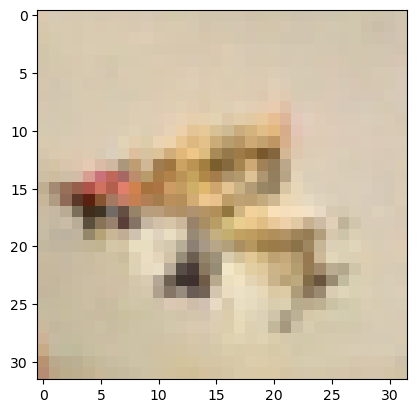

In [25]:
model.eval()
batch_size = 1
with torch.no_grad():
    xt = torch.randn(batch_size, 3, 32, 32).to(device)
    for t in torch.arange(T, 0, -1):
        #print(t)
        t = t.to(device)
        z = torch.randn(batch_size, 3, 32, 32).to(device) if t > 1 else torch.zeros(batch_size, 3, 32, 32).to(device)
        xt_new = 1 / torch.sqrt(alpha[t - 1]) * (xt - (1 - alpha[t - 1])/(torch.sqrt(1 - alpha_bar[t - 1])) * 
                                                       model(xt, (t.expand(batch_size).view(batch_size, 1, 1, 1).expand(batch_size, 1, 32, 32)-1)/1000)) + torch.sqrt(beta[t-1]) * z
        xt = xt_new
        #if t == 1:
            #print((xt - (1 - alpha[t - 1])/(torch.sqrt(1 - alpha_bar[t - 1]))))
    im = xt[0].permute(1, 2, 0)
    im = im.cpu().detach().numpy()
    im = (im + 1) / 2 
    im = im.clip(0, 1)
    #print(im.max())
    plt.savefig("model4gen.png")
    plt.imshow(im)

# Making test and valid set - commented out, don't touch again

In [ ]:
#print("Test set: ")
#for i, (img, _) in tqdm(enumerate(test_loader)):
#    for j in range(img.size(0)):
#        save_image(img[j], os.path.join(test_dir, f"{i * 16 + j}.png"))

In [19]:
#print("Valid set: ")
#for i, (img, _) in tqdm(enumerate(validation_loader)):
#    for j in range(img.size(0)):
#        save_image(img[j], os.path.join(valid_dir, f"{i * 16 + j}.png"))

Valid set: 


313it [02:34,  2.03it/s]


In [22]:
#print("Train set: ")
#for i, (img, _) in tqdm(enumerate(train_for_FID_loader)):
#    for j in range(img.size(0)):
#        save_image(img[j], os.path.join(train_dir, f"{i * 16 + j}.png"))

Train set: 


5000it [02:37, 31.80it/s]


# Make samples from the models we have trained. Currently set up for batch size 1 and conc. T

In [8]:
#pip install pytorch-fid
import os
import torch
from torchvision import datasets, transforms
from torchvision.utils import save_image
from pytorch_fid import fid_score
from tqdm import tqdm

valid_dir = './valid_images'
test_dir = './test_images'
train_dir = './train_images'
gen_dir = './gen_images_att2'
os.makedirs(valid_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(gen_dir, exist_ok=True)
for epoch in [1, 300, 500]:
    os.makedirs(f"./gen_images_att2/{epoch}", exist_ok=True)
with torch.no_grad():
    resize_transform = transforms.Resize((299, 299))
    
    for epoch in [1, 300, 500]:
        model = UNET()
        model.to(device)
        model.load_state_dict(torch.load(f"DDPM_final_bottleneck_3_{epoch}.pth"))
        model.eval()
        batch_size = 1
        
        print("Starting generation set: ")
        for i in tqdm(range(1000)):
            xt = torch.randn(batch_size, 3, 32, 32).to(device)
            
            for t in torch.arange(T, 0, -1):
                #print(t)
                t = t.to(device)
                z = torch.randn(batch_size, 3, 32, 32).to(device) if t > 1 else torch.zeros(batch_size, 3, 32, 32).to(device)
                xt_new = 1 / torch.sqrt(alpha[t - 1]) * (xt - (1 - alpha[t - 1])/(torch.sqrt(1 - alpha_bar[t - 1])) * 
                                                               model(xt, (t.expand(batch_size).view(batch_size, 1, 1, 1).expand(batch_size, 1, 32, 32)-1)/1000)) + torch.sqrt(beta[t-1]) * z
                xt = xt_new
                #if t == 1:
                    #print((xt - (1 - alpha[t - 1])/(torch.sqrt(1 - alpha_bar[t - 1]))))
            im = xt[0]
            print(im.shape)
            im = resize_transform(im)
            im = (im + 1) / 2
            im = im.clamp(0, 1)
            print(im.shape)
            print("Saving generated image: ")
            save_image(im, os.path.join(f"./gen_images_att2/{epoch}", f"{i}.png"))
            print(epoch, i)

Starting generation set: 


  0%|                                                                               | 1/1000 [00:03<1:01:21,  3.69s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 0


  0%|▏                                                                                | 2/1000 [00:07<59:47,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 1


  0%|▏                                                                                | 3/1000 [00:10<59:09,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 2


  0%|▎                                                                                | 4/1000 [00:14<58:31,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 3


  0%|▍                                                                                | 5/1000 [00:17<58:06,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 4


  1%|▍                                                                                | 6/1000 [00:21<57:50,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 5


  1%|▌                                                                                | 7/1000 [00:24<57:19,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 6


  1%|▋                                                                                | 8/1000 [00:27<57:06,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 7


  1%|▋                                                                                | 9/1000 [00:31<57:57,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 8


  1%|▊                                                                               | 10/1000 [00:35<58:14,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 9


  1%|▉                                                                               | 11/1000 [00:38<58:35,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 10


  1%|▉                                                                               | 12/1000 [00:42<59:02,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 11


  1%|█                                                                               | 13/1000 [00:46<58:47,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 12


  1%|█                                                                               | 14/1000 [00:49<59:03,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 13


  2%|█▏                                                                              | 15/1000 [00:53<58:36,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 14


  2%|█▎                                                                              | 16/1000 [00:56<58:37,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 15


  2%|█▎                                                                              | 17/1000 [01:00<58:58,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 16


  2%|█▍                                                                              | 18/1000 [01:03<58:23,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 17


  2%|█▌                                                                              | 19/1000 [01:07<57:45,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 18


  2%|█▌                                                                              | 20/1000 [01:10<58:08,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 19


  2%|█▋                                                                              | 21/1000 [01:14<57:42,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 20


  2%|█▊                                                                              | 22/1000 [01:17<57:27,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 21


  2%|█▊                                                                              | 23/1000 [01:21<57:59,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 22


  2%|█▉                                                                              | 24/1000 [01:25<59:18,  3.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 23


  2%|██                                                                              | 25/1000 [01:28<58:06,  3.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 24


  3%|██                                                                              | 26/1000 [01:32<58:17,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 25


  3%|██▏                                                                             | 27/1000 [01:36<58:03,  3.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 26


  3%|██▏                                                                             | 28/1000 [01:39<58:13,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 27


  3%|██▎                                                                             | 29/1000 [01:43<58:59,  3.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 28


  3%|██▍                                                                             | 30/1000 [01:46<58:20,  3.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 29


  3%|██▍                                                                             | 31/1000 [01:50<57:06,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 30


  3%|██▌                                                                             | 32/1000 [01:53<56:53,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 31


  3%|██▋                                                                             | 33/1000 [01:57<56:46,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 32


  3%|██▋                                                                             | 34/1000 [02:00<56:51,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 33


  4%|██▊                                                                             | 35/1000 [02:04<56:37,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 34


  4%|██▉                                                                             | 36/1000 [02:08<57:08,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 35


  4%|██▉                                                                             | 37/1000 [02:11<57:12,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 36


  4%|███                                                                             | 38/1000 [02:15<57:38,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 37


  4%|███                                                                             | 39/1000 [02:19<59:00,  3.68s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 38


  4%|███▏                                                                            | 40/1000 [02:22<58:29,  3.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 39


  4%|███▎                                                                            | 41/1000 [02:26<57:55,  3.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 40


  4%|███▎                                                                            | 42/1000 [02:29<57:35,  3.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 41


  4%|███▍                                                                            | 43/1000 [02:33<57:00,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 42


  4%|███▌                                                                            | 44/1000 [02:36<57:10,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 43


  4%|███▌                                                                            | 45/1000 [02:40<57:40,  3.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 44


  5%|███▋                                                                            | 46/1000 [02:44<59:02,  3.71s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 45


  5%|███▋                                                                          | 47/1000 [02:48<1:01:01,  3.84s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 46


  5%|███▋                                                                          | 48/1000 [02:52<1:01:02,  3.85s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 47


  5%|███▊                                                                          | 49/1000 [02:56<1:02:18,  3.93s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 48


  5%|███▉                                                                          | 50/1000 [03:00<1:00:42,  3.83s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 49


  5%|████                                                                            | 51/1000 [03:03<59:17,  3.75s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 50


  5%|████▏                                                                           | 52/1000 [03:07<59:05,  3.74s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 51


  5%|████▏                                                                           | 53/1000 [03:11<58:06,  3.68s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 52


  5%|████▎                                                                           | 54/1000 [03:14<57:28,  3.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 53


  6%|████▍                                                                           | 55/1000 [03:18<57:49,  3.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 54


  6%|████▍                                                                           | 56/1000 [03:22<57:41,  3.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 55


  6%|████▌                                                                           | 57/1000 [03:25<57:29,  3.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 56


  6%|████▋                                                                           | 58/1000 [03:29<57:56,  3.69s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 57


  6%|████▋                                                                           | 59/1000 [03:33<57:52,  3.69s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 58


  6%|████▊                                                                           | 60/1000 [03:36<56:33,  3.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 59


  6%|████▉                                                                           | 61/1000 [03:40<56:04,  3.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 60


  6%|████▉                                                                           | 62/1000 [03:43<54:53,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 61


  6%|█████                                                                           | 63/1000 [03:46<54:09,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 62


  6%|█████                                                                           | 64/1000 [03:50<54:47,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 63


  6%|█████▏                                                                          | 65/1000 [03:53<54:39,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 64


  7%|█████▎                                                                          | 66/1000 [03:57<54:23,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 65


  7%|█████▎                                                                          | 67/1000 [04:00<54:25,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 66


  7%|█████▍                                                                          | 68/1000 [04:04<53:45,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 67


  7%|█████▌                                                                          | 69/1000 [04:07<53:44,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 68


  7%|█████▌                                                                          | 70/1000 [04:11<54:42,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 69


  7%|█████▋                                                                          | 71/1000 [04:14<54:31,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 70


  7%|█████▊                                                                          | 72/1000 [04:18<54:33,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 71


  7%|█████▊                                                                          | 73/1000 [04:22<54:58,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 72


  7%|█████▉                                                                          | 74/1000 [04:25<54:13,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 73


  8%|██████                                                                          | 75/1000 [04:29<54:05,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 74


  8%|██████                                                                          | 76/1000 [04:32<53:51,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 75


  8%|██████▏                                                                         | 77/1000 [04:35<53:39,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 76


  8%|██████▏                                                                         | 78/1000 [04:39<53:31,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 77


  8%|██████▎                                                                         | 79/1000 [04:43<53:49,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 78


  8%|██████▍                                                                         | 80/1000 [04:46<53:57,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 79


  8%|██████▍                                                                         | 81/1000 [04:50<54:05,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 80


  8%|██████▌                                                                         | 82/1000 [04:53<54:37,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 81


  8%|██████▋                                                                         | 83/1000 [04:57<53:22,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 82


  8%|██████▋                                                                         | 84/1000 [05:00<53:43,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 83


  8%|██████▊                                                                         | 85/1000 [05:04<53:59,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 84


  9%|██████▉                                                                         | 86/1000 [05:07<53:24,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 85


  9%|██████▉                                                                         | 87/1000 [05:11<53:31,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 86


  9%|███████                                                                         | 88/1000 [05:14<53:53,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 87


  9%|███████                                                                         | 89/1000 [05:18<53:58,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 88


  9%|███████▏                                                                        | 90/1000 [05:22<54:05,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 89


  9%|███████▎                                                                        | 91/1000 [05:25<53:48,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 90


  9%|███████▎                                                                        | 92/1000 [05:28<53:17,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 91


  9%|███████▍                                                                        | 93/1000 [05:32<53:35,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 92


  9%|███████▌                                                                        | 94/1000 [05:36<53:24,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 93


 10%|███████▌                                                                        | 95/1000 [05:39<53:05,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 94


 10%|███████▋                                                                        | 96/1000 [05:43<52:42,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 95


 10%|███████▊                                                                        | 97/1000 [05:46<52:18,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 96


 10%|███████▊                                                                        | 98/1000 [05:49<52:30,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 97


 10%|███████▉                                                                        | 99/1000 [05:53<52:58,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 98


 10%|███████▉                                                                       | 100/1000 [05:57<52:55,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 99


 10%|███████▉                                                                       | 101/1000 [06:00<52:16,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 100


 10%|████████                                                                       | 102/1000 [06:04<52:10,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 101


 10%|████████▏                                                                      | 103/1000 [06:07<52:14,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 102


 10%|████████▏                                                                      | 104/1000 [06:10<51:46,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 103


 10%|████████▎                                                                      | 105/1000 [06:14<51:35,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 104


 11%|████████▎                                                                      | 106/1000 [06:18<52:29,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 105


 11%|████████▍                                                                      | 107/1000 [06:21<52:16,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 106


 11%|████████▌                                                                      | 108/1000 [06:24<51:40,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 107


 11%|████████▌                                                                      | 109/1000 [06:28<51:43,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 108


 11%|████████▋                                                                      | 110/1000 [06:32<52:46,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 109


 11%|████████▊                                                                      | 111/1000 [06:35<52:40,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 110


 11%|████████▊                                                                      | 112/1000 [06:39<52:51,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 111


 11%|████████▉                                                                      | 113/1000 [06:42<52:34,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 112


 11%|█████████                                                                      | 114/1000 [06:46<52:14,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 113


 12%|█████████                                                                      | 115/1000 [06:49<52:32,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 114


 12%|█████████▏                                                                     | 116/1000 [06:53<52:02,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 115


 12%|█████████▏                                                                     | 117/1000 [06:56<51:36,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 116


 12%|█████████▎                                                                     | 118/1000 [07:00<51:19,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 117


 12%|█████████▍                                                                     | 119/1000 [07:03<51:02,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 118


 12%|█████████▍                                                                     | 120/1000 [07:07<50:35,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 119


 12%|█████████▌                                                                     | 121/1000 [07:10<51:44,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 120


 12%|█████████▋                                                                     | 122/1000 [07:14<50:58,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 121


 12%|█████████▋                                                                     | 123/1000 [07:17<50:34,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 122


 12%|█████████▊                                                                     | 124/1000 [07:21<50:37,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 123


 12%|█████████▉                                                                     | 125/1000 [07:24<50:51,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 124


 13%|█████████▉                                                                     | 126/1000 [07:28<50:24,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 125


 13%|██████████                                                                     | 127/1000 [07:31<50:56,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 126


 13%|██████████                                                                     | 128/1000 [07:35<51:30,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 127


 13%|██████████▏                                                                    | 129/1000 [07:38<51:28,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 128


 13%|██████████▎                                                                    | 130/1000 [07:42<51:08,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 129


 13%|██████████▎                                                                    | 131/1000 [07:45<50:42,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 130


 13%|██████████▍                                                                    | 132/1000 [07:49<53:02,  3.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 131


 13%|██████████▌                                                                    | 133/1000 [07:53<52:36,  3.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 132


 13%|██████████▌                                                                    | 134/1000 [07:56<51:50,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 133


 14%|██████████▋                                                                    | 135/1000 [08:00<53:12,  3.69s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 134


 14%|██████████▋                                                                    | 136/1000 [08:04<52:30,  3.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 135


 14%|██████████▊                                                                    | 137/1000 [08:07<51:38,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 136


 14%|██████████▉                                                                    | 138/1000 [08:11<50:57,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 137


 14%|██████████▉                                                                    | 139/1000 [08:14<50:26,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 138


 14%|███████████                                                                    | 140/1000 [08:18<50:12,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 139


 14%|███████████▏                                                                   | 141/1000 [08:22<52:49,  3.69s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 140


 14%|███████████▏                                                                   | 142/1000 [08:25<52:29,  3.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 141


 14%|███████████▎                                                                   | 143/1000 [08:29<52:11,  3.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 142


 14%|███████████▍                                                                   | 144/1000 [08:33<52:19,  3.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 143


 14%|███████████▍                                                                   | 145/1000 [08:36<52:20,  3.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 144


 15%|███████████▌                                                                   | 146/1000 [08:40<51:52,  3.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 145


 15%|███████████▌                                                                   | 147/1000 [08:44<52:18,  3.68s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 146


 15%|███████████▋                                                                   | 148/1000 [08:47<51:23,  3.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 147


 15%|███████████▊                                                                   | 149/1000 [08:51<52:06,  3.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 148


 15%|███████████▊                                                                   | 150/1000 [08:55<51:22,  3.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 149


 15%|███████████▉                                                                   | 151/1000 [08:58<51:42,  3.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 150


 15%|████████████                                                                   | 152/1000 [09:02<51:24,  3.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 151


 15%|████████████                                                                   | 153/1000 [09:06<51:47,  3.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 152


 15%|████████████▏                                                                  | 154/1000 [09:09<51:11,  3.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 153


 16%|████████████▏                                                                  | 155/1000 [09:13<51:02,  3.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 154


 16%|████████████▎                                                                  | 156/1000 [09:16<51:09,  3.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 155


 16%|████████████▍                                                                  | 157/1000 [09:20<50:52,  3.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 156


 16%|████████████▍                                                                  | 158/1000 [09:24<51:39,  3.68s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 157


 16%|████████████▌                                                                  | 159/1000 [09:28<54:38,  3.90s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 158


 16%|████████████▋                                                                  | 160/1000 [09:32<53:05,  3.79s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 159


 16%|████████████▋                                                                  | 161/1000 [09:35<52:34,  3.76s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 160


 16%|████████████▊                                                                  | 162/1000 [09:39<51:23,  3.68s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 161


 16%|████████████▉                                                                  | 163/1000 [09:43<50:54,  3.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 162


 16%|████████████▉                                                                  | 164/1000 [09:46<50:08,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 163


 16%|█████████████                                                                  | 165/1000 [09:50<50:12,  3.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 164


 17%|█████████████                                                                  | 166/1000 [09:53<50:08,  3.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 165


 17%|█████████████▏                                                                 | 167/1000 [09:57<51:13,  3.69s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 166


 17%|█████████████▎                                                                 | 168/1000 [10:01<51:25,  3.71s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 167


 17%|█████████████▎                                                                 | 169/1000 [10:05<53:17,  3.85s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 168


 17%|█████████████▍                                                                 | 170/1000 [10:09<52:08,  3.77s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 169


 17%|█████████████▌                                                                 | 171/1000 [10:12<50:56,  3.69s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 170


 17%|█████████████▌                                                                 | 172/1000 [10:16<50:45,  3.68s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 171


 17%|█████████████▋                                                                 | 173/1000 [10:19<50:17,  3.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 172


 17%|█████████████▋                                                                 | 174/1000 [10:23<50:53,  3.70s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 173


 18%|█████████████▊                                                                 | 175/1000 [10:27<50:01,  3.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 174


 18%|█████████████▉                                                                 | 176/1000 [10:31<50:49,  3.70s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 175


 18%|█████████████▉                                                                 | 177/1000 [10:35<53:21,  3.89s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 176


 18%|██████████████                                                                 | 178/1000 [10:38<52:06,  3.80s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 177


 18%|██████████████▏                                                                | 179/1000 [10:42<51:08,  3.74s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 178


 18%|██████████████▏                                                                | 180/1000 [10:46<49:59,  3.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 179


 18%|██████████████▎                                                                | 181/1000 [10:49<49:17,  3.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 180


 18%|██████████████▍                                                                | 182/1000 [10:53<49:28,  3.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 181


 18%|██████████████▍                                                                | 183/1000 [10:56<49:42,  3.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 182


 18%|██████████████▌                                                                | 184/1000 [11:00<50:09,  3.69s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 183


 18%|██████████████▌                                                                | 185/1000 [11:04<49:40,  3.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 184


 19%|██████████████▋                                                                | 186/1000 [11:07<49:21,  3.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 185


 19%|██████████████▊                                                                | 187/1000 [11:11<48:29,  3.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 186


 19%|██████████████▊                                                                | 188/1000 [11:14<48:21,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 187


 19%|██████████████▉                                                                | 189/1000 [11:18<48:25,  3.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 188


 19%|███████████████                                                                | 190/1000 [11:22<48:19,  3.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 189


 19%|███████████████                                                                | 191/1000 [11:25<48:02,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 190


 19%|███████████████▏                                                               | 192/1000 [11:29<48:05,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 191


 19%|███████████████▏                                                               | 193/1000 [11:32<47:48,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 192


 19%|███████████████▎                                                               | 194/1000 [11:36<48:08,  3.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 193


 20%|███████████████▍                                                               | 195/1000 [11:40<49:46,  3.71s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 194


 20%|███████████████▍                                                               | 196/1000 [11:44<49:38,  3.70s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 195


 20%|███████████████▌                                                               | 197/1000 [11:47<48:34,  3.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 196


 20%|███████████████▋                                                               | 198/1000 [11:51<48:14,  3.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 197


 20%|███████████████▋                                                               | 199/1000 [11:54<48:07,  3.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 198


 20%|███████████████▊                                                               | 200/1000 [11:58<47:23,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 199


 20%|███████████████▉                                                               | 201/1000 [12:01<47:15,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 200


 20%|███████████████▉                                                               | 202/1000 [12:05<47:29,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 201


 20%|████████████████                                                               | 203/1000 [12:08<46:54,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 202


 20%|████████████████                                                               | 204/1000 [12:12<46:32,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 203


 20%|████████████████▏                                                              | 205/1000 [12:15<45:53,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 204


 21%|████████████████▎                                                              | 206/1000 [12:18<46:01,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 205


 21%|████████████████▎                                                              | 207/1000 [12:22<46:43,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 206


 21%|████████████████▍                                                              | 208/1000 [12:26<46:26,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 207


 21%|████████████████▌                                                              | 209/1000 [12:29<45:59,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 208


 21%|████████████████▌                                                              | 210/1000 [12:32<45:38,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 209


 21%|████████████████▋                                                              | 211/1000 [12:36<47:01,  3.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 210


 21%|████████████████▋                                                              | 212/1000 [12:40<46:35,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 211


 21%|████████████████▊                                                              | 213/1000 [12:44<47:20,  3.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 212


 21%|████████████████▉                                                              | 214/1000 [12:47<46:55,  3.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 213


 22%|████████████████▉                                                              | 215/1000 [12:51<47:12,  3.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 214


 22%|█████████████████                                                              | 216/1000 [12:54<47:18,  3.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 215


 22%|█████████████████▏                                                             | 217/1000 [12:58<47:49,  3.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 216


 22%|█████████████████▏                                                             | 218/1000 [13:02<47:23,  3.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 217


 22%|█████████████████▎                                                             | 219/1000 [13:06<48:52,  3.75s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 218


 22%|█████████████████▍                                                             | 220/1000 [13:09<48:26,  3.73s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 219


 22%|█████████████████▍                                                             | 221/1000 [13:13<47:40,  3.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 220


 22%|█████████████████▌                                                             | 222/1000 [13:16<46:48,  3.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 221


 22%|█████████████████▌                                                             | 223/1000 [13:20<46:45,  3.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 222


 22%|█████████████████▋                                                             | 224/1000 [13:23<46:00,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 223


 22%|█████████████████▊                                                             | 225/1000 [13:27<46:24,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 224


 23%|█████████████████▊                                                             | 226/1000 [13:31<46:46,  3.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 225


 23%|█████████████████▉                                                             | 227/1000 [13:34<46:18,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 226


 23%|██████████████████                                                             | 228/1000 [13:38<45:37,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 227


 23%|██████████████████                                                             | 229/1000 [13:41<45:30,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 228


 23%|██████████████████▏                                                            | 230/1000 [13:45<45:02,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 229


 23%|██████████████████▏                                                            | 231/1000 [13:48<45:10,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 230


 23%|██████████████████▎                                                            | 232/1000 [13:52<45:05,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 231


 23%|██████████████████▍                                                            | 233/1000 [13:55<44:46,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 232


 23%|██████████████████▍                                                            | 234/1000 [13:59<44:42,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 233


 24%|██████████████████▌                                                            | 235/1000 [14:02<44:45,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 234


 24%|██████████████████▋                                                            | 236/1000 [14:06<45:26,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 235


 24%|██████████████████▋                                                            | 237/1000 [14:10<45:56,  3.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 236


 24%|██████████████████▊                                                            | 238/1000 [14:13<45:38,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 237


 24%|██████████████████▉                                                            | 239/1000 [14:17<45:41,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 238


 24%|██████████████████▉                                                            | 240/1000 [14:20<45:16,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 239


 24%|███████████████████                                                            | 241/1000 [14:24<44:40,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 240


 24%|███████████████████                                                            | 242/1000 [14:27<44:26,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 241


 24%|███████████████████▏                                                           | 243/1000 [14:31<45:33,  3.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 242


 24%|███████████████████▎                                                           | 244/1000 [14:35<45:35,  3.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 243


 24%|███████████████████▎                                                           | 245/1000 [14:38<45:13,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 244


 25%|███████████████████▍                                                           | 246/1000 [14:42<44:33,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 245


 25%|███████████████████▌                                                           | 247/1000 [14:45<44:53,  3.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 246


 25%|███████████████████▌                                                           | 248/1000 [14:49<44:56,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 247


 25%|███████████████████▋                                                           | 249/1000 [14:52<44:25,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 248


 25%|███████████████████▊                                                           | 250/1000 [14:56<44:21,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 249


 25%|███████████████████▊                                                           | 251/1000 [15:00<44:34,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 250


 25%|███████████████████▉                                                           | 252/1000 [15:03<45:04,  3.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 251


 25%|███████████████████▉                                                           | 253/1000 [15:07<44:48,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 252


 25%|████████████████████                                                           | 254/1000 [15:10<44:26,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 253


 26%|████████████████████▏                                                          | 255/1000 [15:14<43:45,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 254


 26%|████████████████████▏                                                          | 256/1000 [15:17<44:00,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 255


 26%|████████████████████▎                                                          | 257/1000 [15:21<44:33,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 256


 26%|████████████████████▍                                                          | 258/1000 [15:25<44:53,  3.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 257


 26%|████████████████████▍                                                          | 259/1000 [15:29<44:46,  3.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 258


 26%|████████████████████▌                                                          | 260/1000 [15:32<44:05,  3.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 259


 26%|████████████████████▌                                                          | 261/1000 [15:35<43:48,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 260


 26%|████████████████████▋                                                          | 262/1000 [15:39<43:20,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 261


 26%|████████████████████▊                                                          | 263/1000 [15:43<43:50,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 262


 26%|████████████████████▊                                                          | 264/1000 [15:46<44:25,  3.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 263


 26%|████████████████████▉                                                          | 265/1000 [15:50<43:36,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 264


 27%|█████████████████████                                                          | 266/1000 [15:53<43:20,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 265


 27%|█████████████████████                                                          | 267/1000 [15:57<42:52,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 266


 27%|█████████████████████▏                                                         | 268/1000 [16:00<42:13,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 267


 27%|█████████████████████▎                                                         | 269/1000 [16:03<41:38,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 268


 27%|█████████████████████▎                                                         | 270/1000 [16:07<42:50,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 269


 27%|█████████████████████▍                                                         | 271/1000 [16:11<43:19,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 270


 27%|█████████████████████▍                                                         | 272/1000 [16:14<42:41,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 271


 27%|█████████████████████▌                                                         | 273/1000 [16:18<43:07,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 272


 27%|█████████████████████▋                                                         | 274/1000 [16:21<42:47,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 273


 28%|█████████████████████▋                                                         | 275/1000 [16:25<42:36,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 274


 28%|█████████████████████▊                                                         | 276/1000 [16:28<42:41,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 275


 28%|█████████████████████▉                                                         | 277/1000 [16:32<42:29,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 276


 28%|█████████████████████▉                                                         | 278/1000 [16:35<42:14,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 277


 28%|██████████████████████                                                         | 279/1000 [16:39<42:41,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 278


 28%|██████████████████████                                                         | 280/1000 [16:43<43:03,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 279


 28%|██████████████████████▏                                                        | 281/1000 [16:46<42:41,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 280


 28%|██████████████████████▎                                                        | 282/1000 [16:50<42:33,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 281


 28%|██████████████████████▎                                                        | 283/1000 [16:53<42:49,  3.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 282


 28%|██████████████████████▍                                                        | 284/1000 [16:57<42:30,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 283


 28%|██████████████████████▌                                                        | 285/1000 [17:00<42:18,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 284


 29%|██████████████████████▌                                                        | 286/1000 [17:04<42:00,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 285


 29%|██████████████████████▋                                                        | 287/1000 [17:07<41:16,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 286


 29%|██████████████████████▊                                                        | 288/1000 [17:11<42:38,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 287


 29%|██████████████████████▊                                                        | 289/1000 [17:15<42:48,  3.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 288


 29%|██████████████████████▉                                                        | 290/1000 [17:18<42:36,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 289


 29%|██████████████████████▉                                                        | 291/1000 [17:22<42:48,  3.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 290


 29%|███████████████████████                                                        | 292/1000 [17:26<42:22,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 291


 29%|███████████████████████▏                                                       | 293/1000 [17:29<42:36,  3.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 292


 29%|███████████████████████▏                                                       | 294/1000 [17:33<42:14,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 293


 30%|███████████████████████▎                                                       | 295/1000 [17:36<41:50,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 294


 30%|███████████████████████▍                                                       | 296/1000 [17:40<41:41,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 295


 30%|███████████████████████▍                                                       | 297/1000 [17:43<41:28,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 296


 30%|███████████████████████▌                                                       | 298/1000 [17:47<41:22,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 297


 30%|███████████████████████▌                                                       | 299/1000 [17:50<41:17,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 298


 30%|███████████████████████▋                                                       | 300/1000 [17:54<41:28,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 299


 30%|███████████████████████▊                                                       | 301/1000 [17:58<41:37,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 300


 30%|███████████████████████▊                                                       | 302/1000 [18:01<41:19,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 301


 30%|███████████████████████▉                                                       | 303/1000 [18:05<41:10,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 302


 30%|████████████████████████                                                       | 304/1000 [18:08<41:11,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 303


 30%|████████████████████████                                                       | 305/1000 [18:12<41:33,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 304


 31%|████████████████████████▏                                                      | 306/1000 [18:15<41:28,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 305


 31%|████████████████████████▎                                                      | 307/1000 [18:19<41:09,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 306


 31%|████████████████████████▎                                                      | 308/1000 [18:22<41:02,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 307


 31%|████████████████████████▍                                                      | 309/1000 [18:26<40:44,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 308


 31%|████████████████████████▍                                                      | 310/1000 [18:29<40:13,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 309


 31%|████████████████████████▌                                                      | 311/1000 [18:33<40:46,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 310


 31%|████████████████████████▋                                                      | 312/1000 [18:37<40:47,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 311


 31%|████████████████████████▋                                                      | 313/1000 [18:40<40:29,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 312


 31%|████████████████████████▊                                                      | 314/1000 [18:44<40:30,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 313


 32%|████████████████████████▉                                                      | 315/1000 [18:47<40:02,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 314


 32%|████████████████████████▉                                                      | 316/1000 [18:51<39:50,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 315


 32%|█████████████████████████                                                      | 317/1000 [18:54<40:01,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 316


 32%|█████████████████████████                                                      | 318/1000 [18:58<40:07,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 317


 32%|█████████████████████████▏                                                     | 319/1000 [19:01<40:10,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 318


 32%|█████████████████████████▎                                                     | 320/1000 [19:05<40:01,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 319


 32%|█████████████████████████▎                                                     | 321/1000 [19:08<40:32,  3.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 320


 32%|█████████████████████████▍                                                     | 322/1000 [19:12<40:51,  3.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 321


 32%|█████████████████████████▌                                                     | 323/1000 [19:16<40:39,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 322


 32%|█████████████████████████▌                                                     | 324/1000 [19:19<40:03,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 323


 32%|█████████████████████████▋                                                     | 325/1000 [19:23<39:38,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 324


 33%|█████████████████████████▊                                                     | 326/1000 [19:26<39:39,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 325


 33%|█████████████████████████▊                                                     | 327/1000 [19:30<39:29,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 326


 33%|█████████████████████████▉                                                     | 328/1000 [19:33<39:07,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 327


 33%|█████████████████████████▉                                                     | 329/1000 [19:37<39:33,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 328


 33%|██████████████████████████                                                     | 330/1000 [19:40<39:59,  3.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 329


 33%|██████████████████████████▏                                                    | 331/1000 [19:44<39:42,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 330


 33%|██████████████████████████▏                                                    | 332/1000 [19:48<39:45,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 331


 33%|██████████████████████████▎                                                    | 333/1000 [19:51<39:55,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 332


 33%|██████████████████████████▍                                                    | 334/1000 [19:55<39:55,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 333


 34%|██████████████████████████▍                                                    | 335/1000 [19:58<39:49,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 334


 34%|██████████████████████████▌                                                    | 336/1000 [20:02<39:23,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 335


 34%|██████████████████████████▌                                                    | 337/1000 [20:05<39:15,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 336


 34%|██████████████████████████▋                                                    | 338/1000 [20:09<39:20,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 337


 34%|██████████████████████████▊                                                    | 339/1000 [20:13<40:49,  3.71s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 338


 34%|██████████████████████████▊                                                    | 340/1000 [20:17<40:21,  3.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 339


 34%|██████████████████████████▉                                                    | 341/1000 [20:20<39:48,  3.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 340


 34%|███████████████████████████                                                    | 342/1000 [20:24<40:55,  3.73s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 341


 34%|███████████████████████████                                                    | 343/1000 [20:28<40:27,  3.69s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 342


 34%|███████████████████████████▏                                                   | 344/1000 [20:32<40:52,  3.74s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 343


 34%|███████████████████████████▎                                                   | 345/1000 [20:36<42:08,  3.86s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 344


 35%|███████████████████████████▎                                                   | 346/1000 [20:40<42:50,  3.93s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 345


 35%|███████████████████████████▍                                                   | 347/1000 [20:44<42:41,  3.92s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 346


 35%|███████████████████████████▍                                                   | 348/1000 [20:48<42:25,  3.90s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 347


 35%|███████████████████████████▌                                                   | 349/1000 [20:51<41:56,  3.87s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 348


 35%|███████████████████████████▋                                                   | 350/1000 [20:56<42:56,  3.96s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 349


 35%|███████████████████████████▋                                                   | 351/1000 [20:59<42:02,  3.89s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 350


 35%|███████████████████████████▊                                                   | 352/1000 [21:03<43:04,  3.99s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 351


 35%|███████████████████████████▉                                                   | 353/1000 [21:07<42:15,  3.92s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 352


 35%|███████████████████████████▉                                                   | 354/1000 [21:11<41:50,  3.89s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 353


 36%|████████████████████████████                                                   | 355/1000 [21:15<40:53,  3.80s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 354


 36%|████████████████████████████                                                   | 356/1000 [21:18<40:04,  3.73s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 355


 36%|████████████████████████████▏                                                  | 357/1000 [21:22<39:41,  3.70s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 356


 36%|████████████████████████████▎                                                  | 358/1000 [21:25<39:21,  3.68s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 357


 36%|████████████████████████████▎                                                  | 359/1000 [21:29<38:08,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 358


 36%|████████████████████████████▍                                                  | 360/1000 [21:32<37:15,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 359


 36%|████████████████████████████▌                                                  | 361/1000 [21:35<36:44,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 360


 36%|████████████████████████████▌                                                  | 362/1000 [21:39<36:07,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 361


 36%|████████████████████████████▋                                                  | 363/1000 [21:42<35:45,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 362


 36%|████████████████████████████▊                                                  | 364/1000 [21:46<36:16,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 363


 36%|████████████████████████████▊                                                  | 365/1000 [21:49<35:51,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 364


 37%|████████████████████████████▉                                                  | 366/1000 [21:52<35:32,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 365


 37%|████████████████████████████▉                                                  | 367/1000 [21:56<35:29,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 366


 37%|█████████████████████████████                                                  | 368/1000 [21:59<35:07,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 367


 37%|█████████████████████████████▏                                                 | 369/1000 [22:02<34:56,  3.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 368


 37%|█████████████████████████████▏                                                 | 370/1000 [22:05<35:00,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 369


 37%|█████████████████████████████▎                                                 | 371/1000 [22:09<34:47,  3.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 370


 37%|█████████████████████████████▍                                                 | 372/1000 [22:12<34:31,  3.30s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 371


 37%|█████████████████████████████▍                                                 | 373/1000 [22:15<34:39,  3.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 372


 37%|█████████████████████████████▌                                                 | 374/1000 [22:19<34:49,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 373


 38%|█████████████████████████████▋                                                 | 375/1000 [22:22<34:39,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 374


 38%|█████████████████████████████▋                                                 | 376/1000 [22:25<34:24,  3.31s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 375


 38%|█████████████████████████████▊                                                 | 377/1000 [22:29<34:24,  3.31s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 376


 38%|█████████████████████████████▊                                                 | 378/1000 [22:32<34:16,  3.31s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 377


 38%|█████████████████████████████▉                                                 | 379/1000 [22:35<34:59,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 378


 38%|██████████████████████████████                                                 | 380/1000 [22:39<34:43,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 379


 38%|██████████████████████████████                                                 | 381/1000 [22:42<34:21,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 380


 38%|██████████████████████████████▏                                                | 382/1000 [22:46<36:54,  3.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 381


 38%|██████████████████████████████▎                                                | 383/1000 [22:50<36:18,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 382


 38%|██████████████████████████████▎                                                | 384/1000 [22:53<35:26,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 383


 38%|██████████████████████████████▍                                                | 385/1000 [22:56<34:54,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 384


 39%|██████████████████████████████▍                                                | 386/1000 [23:00<35:34,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 385


 39%|██████████████████████████████▌                                                | 387/1000 [23:03<34:52,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 386


 39%|██████████████████████████████▋                                                | 388/1000 [23:06<34:22,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 387


 39%|██████████████████████████████▋                                                | 389/1000 [23:10<34:10,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 388


 39%|██████████████████████████████▊                                                | 390/1000 [23:13<33:53,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 389


 39%|██████████████████████████████▉                                                | 391/1000 [23:16<33:39,  3.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 390


 39%|██████████████████████████████▉                                                | 392/1000 [23:20<34:47,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 391


 39%|███████████████████████████████                                                | 393/1000 [23:23<34:31,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 392


 39%|███████████████████████████████▏                                               | 394/1000 [23:27<34:40,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 393


 40%|███████████████████████████████▏                                               | 395/1000 [23:30<34:26,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 394


 40%|███████████████████████████████▎                                               | 396/1000 [23:34<35:29,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 395


 40%|███████████████████████████████▎                                               | 397/1000 [23:37<35:23,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 396


 40%|███████████████████████████████▍                                               | 398/1000 [23:41<34:56,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 397


 40%|███████████████████████████████▌                                               | 399/1000 [23:44<35:16,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 398


 40%|███████████████████████████████▌                                               | 400/1000 [23:48<35:42,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 399


 40%|███████████████████████████████▋                                               | 401/1000 [23:52<35:03,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 400


 40%|███████████████████████████████▊                                               | 402/1000 [23:55<35:54,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 401


 40%|███████████████████████████████▊                                               | 403/1000 [23:59<34:58,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 402


 40%|███████████████████████████████▉                                               | 404/1000 [24:02<34:27,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 403


 40%|███████████████████████████████▉                                               | 405/1000 [24:05<34:26,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 404


 41%|████████████████████████████████                                               | 406/1000 [24:09<33:43,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 405


 41%|████████████████████████████████▏                                              | 407/1000 [24:12<33:42,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 406


 41%|████████████████████████████████▏                                              | 408/1000 [24:15<33:21,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 407


 41%|████████████████████████████████▎                                              | 409/1000 [24:19<33:40,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 408


 41%|████████████████████████████████▍                                              | 410/1000 [24:22<33:26,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 409


 41%|████████████████████████████████▍                                              | 411/1000 [24:26<33:20,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 410


 41%|████████████████████████████████▌                                              | 412/1000 [24:29<32:58,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 411


 41%|████████████████████████████████▋                                              | 413/1000 [24:32<32:47,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 412


 41%|████████████████████████████████▋                                              | 414/1000 [24:36<33:34,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 413


 42%|████████████████████████████████▊                                              | 415/1000 [24:39<33:06,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 414


 42%|████████████████████████████████▊                                              | 416/1000 [24:43<33:57,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 415


 42%|████████████████████████████████▉                                              | 417/1000 [24:46<33:22,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 416


 42%|█████████████████████████████████                                              | 418/1000 [24:50<33:03,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 417


 42%|█████████████████████████████████                                              | 419/1000 [24:53<32:43,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 418


 42%|█████████████████████████████████▏                                             | 420/1000 [24:56<32:39,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 419


 42%|█████████████████████████████████▎                                             | 421/1000 [25:00<32:21,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 420


 42%|█████████████████████████████████▎                                             | 422/1000 [25:03<32:04,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 421


 42%|█████████████████████████████████▍                                             | 423/1000 [25:06<32:13,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 422


 42%|█████████████████████████████████▍                                             | 424/1000 [25:10<31:54,  3.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 423


 42%|█████████████████████████████████▌                                             | 425/1000 [25:14<34:38,  3.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 424


 43%|█████████████████████████████████▋                                             | 426/1000 [25:17<33:51,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 425


 43%|█████████████████████████████████▋                                             | 427/1000 [25:20<33:03,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 426


 43%|█████████████████████████████████▊                                             | 428/1000 [25:24<33:42,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 427


 43%|█████████████████████████████████▉                                             | 429/1000 [25:27<32:57,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 428


 43%|█████████████████████████████████▉                                             | 430/1000 [25:31<32:23,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 429


 43%|██████████████████████████████████                                             | 431/1000 [25:34<31:57,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 430


 43%|██████████████████████████████████▏                                            | 432/1000 [25:38<32:35,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 431


 43%|██████████████████████████████████▏                                            | 433/1000 [25:41<32:07,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 432


 43%|██████████████████████████████████▎                                            | 434/1000 [25:44<32:07,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 433


 44%|██████████████████████████████████▎                                            | 435/1000 [25:48<32:12,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 434


 44%|██████████████████████████████████▍                                            | 436/1000 [25:51<32:14,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 435


 44%|██████████████████████████████████▌                                            | 437/1000 [25:55<31:45,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 436


 44%|██████████████████████████████████▌                                            | 438/1000 [25:58<33:12,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 437


 44%|██████████████████████████████████▋                                            | 439/1000 [26:02<33:39,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 438


 44%|██████████████████████████████████▊                                            | 440/1000 [26:05<32:36,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 439


 44%|██████████████████████████████████▊                                            | 441/1000 [26:09<33:31,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 440


 44%|██████████████████████████████████▉                                            | 442/1000 [26:13<32:37,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 441


 44%|██████████████████████████████████▉                                            | 443/1000 [26:16<31:53,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 442


 44%|███████████████████████████████████                                            | 444/1000 [26:20<32:53,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 443


 44%|███████████████████████████████████▏                                           | 445/1000 [26:23<32:09,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 444


 45%|███████████████████████████████████▏                                           | 446/1000 [26:26<31:37,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 445


 45%|███████████████████████████████████▎                                           | 447/1000 [26:30<31:14,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 446


 45%|███████████████████████████████████▍                                           | 448/1000 [26:33<30:56,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 447


 45%|███████████████████████████████████▍                                           | 449/1000 [26:36<30:42,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 448


 45%|███████████████████████████████████▌                                           | 450/1000 [26:40<30:34,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 449


 45%|███████████████████████████████████▋                                           | 451/1000 [26:43<30:31,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 450


 45%|███████████████████████████████████▋                                           | 452/1000 [26:46<30:33,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 451


 45%|███████████████████████████████████▊                                           | 453/1000 [26:50<30:39,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 452


 45%|███████████████████████████████████▊                                           | 454/1000 [26:53<30:39,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 453


 46%|███████████████████████████████████▉                                           | 455/1000 [26:56<30:24,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 454


 46%|████████████████████████████████████                                           | 456/1000 [27:00<30:38,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 455


 46%|████████████████████████████████████                                           | 457/1000 [27:04<32:08,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 456


 46%|████████████████████████████████████▏                                          | 458/1000 [27:07<31:26,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 457


 46%|████████████████████████████████████▎                                          | 459/1000 [27:10<31:01,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 458


 46%|████████████████████████████████████▎                                          | 460/1000 [27:14<31:40,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 459


 46%|████████████████████████████████████▍                                          | 461/1000 [27:17<30:55,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 460


 46%|████████████████████████████████████▍                                          | 462/1000 [27:21<30:30,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 461


 46%|████████████████████████████████████▌                                          | 463/1000 [27:24<30:36,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 462


 46%|████████████████████████████████████▋                                          | 464/1000 [27:27<30:12,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 463


 46%|████████████████████████████████████▋                                          | 465/1000 [27:31<30:45,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 464


 47%|████████████████████████████████████▊                                          | 466/1000 [27:34<30:22,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 465


 47%|████████████████████████████████████▉                                          | 467/1000 [27:38<29:55,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 466


 47%|████████████████████████████████████▉                                          | 468/1000 [27:41<29:38,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 467


 47%|█████████████████████████████████████                                          | 469/1000 [27:44<29:35,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 468


 47%|█████████████████████████████████████▏                                         | 470/1000 [27:48<29:59,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 469


 47%|█████████████████████████████████████▏                                         | 471/1000 [27:51<29:45,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 470


 47%|█████████████████████████████████████▎                                         | 472/1000 [27:55<29:49,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 471


 47%|█████████████████████████████████████▎                                         | 473/1000 [27:58<29:32,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 472


 47%|█████████████████████████████████████▍                                         | 474/1000 [28:01<29:57,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 473


 48%|█████████████████████████████████████▌                                         | 475/1000 [28:05<31:23,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 474


 48%|█████████████████████████████████████▌                                         | 476/1000 [28:09<31:12,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 475


 48%|█████████████████████████████████████▋                                         | 477/1000 [28:12<30:40,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 476


 48%|█████████████████████████████████████▊                                         | 478/1000 [28:16<30:58,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 477


 48%|█████████████████████████████████████▊                                         | 479/1000 [28:19<30:38,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 478


 48%|█████████████████████████████████████▉                                         | 480/1000 [28:23<30:50,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 479


 48%|█████████████████████████████████████▉                                         | 481/1000 [28:26<30:05,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 480


 48%|██████████████████████████████████████                                         | 482/1000 [28:30<31:25,  3.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 481


 48%|██████████████████████████████████████▏                                        | 483/1000 [28:34<30:30,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 482


 48%|██████████████████████████████████████▏                                        | 484/1000 [28:37<30:01,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 483


 48%|██████████████████████████████████████▎                                        | 485/1000 [28:40<29:54,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 484


 49%|██████████████████████████████████████▍                                        | 486/1000 [28:44<29:29,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 485


 49%|██████████████████████████████████████▍                                        | 487/1000 [28:47<29:25,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 486


 49%|██████████████████████████████████████▌                                        | 488/1000 [28:51<28:59,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 487


 49%|██████████████████████████████████████▋                                        | 489/1000 [28:54<28:40,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 488


 49%|██████████████████████████████████████▋                                        | 490/1000 [28:57<28:22,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 489


 49%|██████████████████████████████████████▊                                        | 491/1000 [29:00<28:12,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 490


 49%|██████████████████████████████████████▊                                        | 492/1000 [29:04<27:59,  3.31s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 491


 49%|██████████████████████████████████████▉                                        | 493/1000 [29:07<27:56,  3.31s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 492


 49%|███████████████████████████████████████                                        | 494/1000 [29:10<28:00,  3.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 493


 50%|███████████████████████████████████████                                        | 495/1000 [29:14<27:52,  3.31s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 494


 50%|███████████████████████████████████████▏                                       | 496/1000 [29:17<27:46,  3.31s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 495


 50%|███████████████████████████████████████▎                                       | 497/1000 [29:20<27:42,  3.31s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 496


 50%|███████████████████████████████████████▎                                       | 498/1000 [29:24<28:03,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 497


 50%|███████████████████████████████████████▍                                       | 499/1000 [29:27<28:39,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 498


 50%|███████████████████████████████████████▌                                       | 500/1000 [29:31<28:26,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 499


 50%|███████████████████████████████████████▌                                       | 501/1000 [29:34<28:45,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 500


 50%|███████████████████████████████████████▋                                       | 502/1000 [29:38<29:00,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 501


 50%|███████████████████████████████████████▋                                       | 503/1000 [29:41<28:32,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 502


 50%|███████████████████████████████████████▊                                       | 504/1000 [29:45<30:41,  3.71s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 503


 50%|███████████████████████████████████████▉                                       | 505/1000 [29:49<29:41,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 504


 51%|███████████████████████████████████████▉                                       | 506/1000 [29:52<29:06,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 505


 51%|████████████████████████████████████████                                       | 507/1000 [29:55<28:20,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 506


 51%|████████████████████████████████████████▏                                      | 508/1000 [29:59<27:50,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 507


 51%|████████████████████████████████████████▏                                      | 509/1000 [30:02<27:46,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 508


 51%|████████████████████████████████████████▎                                      | 510/1000 [30:06<29:05,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 509


 51%|████████████████████████████████████████▎                                      | 511/1000 [30:09<28:25,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 510


 51%|████████████████████████████████████████▍                                      | 512/1000 [30:13<28:02,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 511


 51%|████████████████████████████████████████▌                                      | 513/1000 [30:16<27:32,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 512


 51%|████████████████████████████████████████▌                                      | 514/1000 [30:20<28:04,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 513


 52%|████████████████████████████████████████▋                                      | 515/1000 [30:23<27:45,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 514


 52%|████████████████████████████████████████▊                                      | 516/1000 [30:26<27:14,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 515


 52%|████████████████████████████████████████▊                                      | 517/1000 [30:30<26:54,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 516


 52%|████████████████████████████████████████▉                                      | 518/1000 [30:33<27:00,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 517


 52%|█████████████████████████████████████████                                      | 519/1000 [30:36<26:45,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 518


 52%|█████████████████████████████████████████                                      | 520/1000 [30:40<26:44,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 519


 52%|█████████████████████████████████████████▏                                     | 521/1000 [30:43<26:41,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 520


 52%|█████████████████████████████████████████▏                                     | 522/1000 [30:46<26:36,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 521


 52%|█████████████████████████████████████████▎                                     | 523/1000 [30:49<26:20,  3.31s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 522


 52%|█████████████████████████████████████████▍                                     | 524/1000 [30:53<26:12,  3.30s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 523


 52%|█████████████████████████████████████████▍                                     | 525/1000 [30:56<26:23,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 524


 53%|█████████████████████████████████████████▌                                     | 526/1000 [31:00<27:08,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 525


 53%|█████████████████████████████████████████▋                                     | 527/1000 [31:03<26:43,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 526


 53%|█████████████████████████████████████████▋                                     | 528/1000 [31:07<26:39,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 527


 53%|█████████████████████████████████████████▊                                     | 529/1000 [31:10<26:21,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 528


 53%|█████████████████████████████████████████▊                                     | 530/1000 [31:13<26:02,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 529


 53%|█████████████████████████████████████████▉                                     | 531/1000 [31:16<25:53,  3.31s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 530


 53%|██████████████████████████████████████████                                     | 532/1000 [31:20<25:48,  3.31s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 531


 53%|██████████████████████████████████████████                                     | 533/1000 [31:23<25:47,  3.31s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 532


 53%|██████████████████████████████████████████▏                                    | 534/1000 [31:26<25:56,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 533


 54%|██████████████████████████████████████████▎                                    | 535/1000 [31:30<25:53,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 534


 54%|██████████████████████████████████████████▎                                    | 536/1000 [31:33<25:40,  3.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 535


 54%|██████████████████████████████████████████▍                                    | 537/1000 [31:36<25:50,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 536


 54%|██████████████████████████████████████████▌                                    | 538/1000 [31:40<26:23,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 537


 54%|██████████████████████████████████████████▌                                    | 539/1000 [31:43<26:02,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 538


 54%|██████████████████████████████████████████▋                                    | 540/1000 [31:47<25:56,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 539


 54%|██████████████████████████████████████████▋                                    | 541/1000 [31:50<25:46,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 540


 54%|██████████████████████████████████████████▊                                    | 542/1000 [31:53<25:32,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 541


 54%|██████████████████████████████████████████▉                                    | 543/1000 [31:57<26:09,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 542


 54%|██████████████████████████████████████████▉                                    | 544/1000 [32:00<25:54,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 543


 55%|███████████████████████████████████████████                                    | 545/1000 [32:04<25:30,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 544


 55%|███████████████████████████████████████████▏                                   | 546/1000 [32:07<25:18,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 545


 55%|███████████████████████████████████████████▏                                   | 547/1000 [32:11<26:05,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 546


 55%|███████████████████████████████████████████▎                                   | 548/1000 [32:14<25:36,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 547


 55%|███████████████████████████████████████████▎                                   | 549/1000 [32:17<25:19,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 548


 55%|███████████████████████████████████████████▍                                   | 550/1000 [32:20<25:16,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 549


 55%|███████████████████████████████████████████▌                                   | 551/1000 [32:24<25:22,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 550


 55%|███████████████████████████████████████████▌                                   | 552/1000 [32:27<25:02,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 551


 55%|███████████████████████████████████████████▋                                   | 553/1000 [32:30<24:50,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 552


 55%|███████████████████████████████████████████▊                                   | 554/1000 [32:34<24:36,  3.31s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 553


 56%|███████████████████████████████████████████▊                                   | 555/1000 [32:37<24:50,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 554


 56%|███████████████████████████████████████████▉                                   | 556/1000 [32:40<24:39,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 555


 56%|████████████████████████████████████████████                                   | 557/1000 [32:44<24:37,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 556


 56%|████████████████████████████████████████████                                   | 558/1000 [32:48<25:29,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 557


 56%|████████████████████████████████████████████▏                                  | 559/1000 [32:51<25:21,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 558


 56%|████████████████████████████████████████████▏                                  | 560/1000 [32:55<25:34,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 559


 56%|████████████████████████████████████████████▎                                  | 561/1000 [32:58<25:30,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 560


 56%|████████████████████████████████████████████▍                                  | 562/1000 [33:02<25:24,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 561


 56%|████████████████████████████████████████████▍                                  | 563/1000 [33:05<25:28,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 562


 56%|████████████████████████████████████████████▌                                  | 564/1000 [33:09<25:43,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 563


 56%|████████████████████████████████████████████▋                                  | 565/1000 [33:12<26:06,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 564


 57%|████████████████████████████████████████████▋                                  | 566/1000 [33:16<25:25,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 565


 57%|████████████████████████████████████████████▊                                  | 567/1000 [33:19<24:54,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 566


 57%|████████████████████████████████████████████▊                                  | 568/1000 [33:22<24:28,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 567


 57%|████████████████████████████████████████████▉                                  | 569/1000 [33:26<24:22,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 568


 57%|█████████████████████████████████████████████                                  | 570/1000 [33:30<25:26,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 569


 57%|█████████████████████████████████████████████                                  | 571/1000 [33:33<24:52,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 570


 57%|█████████████████████████████████████████████▏                                 | 572/1000 [33:36<24:24,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 571


 57%|█████████████████████████████████████████████▎                                 | 573/1000 [33:40<25:06,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 572


 57%|█████████████████████████████████████████████▎                                 | 574/1000 [33:43<24:40,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 573


 57%|█████████████████████████████████████████████▍                                 | 575/1000 [33:47<24:13,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 574


 58%|█████████████████████████████████████████████▌                                 | 576/1000 [33:50<23:50,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 575


 58%|█████████████████████████████████████████████▌                                 | 577/1000 [33:54<24:46,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 576


 58%|█████████████████████████████████████████████▋                                 | 578/1000 [33:57<24:54,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 577


 58%|█████████████████████████████████████████████▋                                 | 579/1000 [34:01<24:32,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 578


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [34:04<24:09,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 579


 58%|█████████████████████████████████████████████▉                                 | 581/1000 [34:07<23:40,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 580


 58%|█████████████████████████████████████████████▉                                 | 582/1000 [34:11<23:23,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 581


 58%|██████████████████████████████████████████████                                 | 583/1000 [34:14<24:05,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 582


 58%|██████████████████████████████████████████████▏                                | 584/1000 [34:18<23:50,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 583


 58%|██████████████████████████████████████████████▏                                | 585/1000 [34:21<23:24,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 584


 59%|██████████████████████████████████████████████▎                                | 586/1000 [34:24<23:09,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 585


 59%|██████████████████████████████████████████████▎                                | 587/1000 [34:28<23:08,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 586


 59%|██████████████████████████████████████████████▍                                | 588/1000 [34:31<22:56,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 587


 59%|██████████████████████████████████████████████▌                                | 589/1000 [34:34<23:15,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 588


 59%|██████████████████████████████████████████████▌                                | 590/1000 [34:38<23:09,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 589


 59%|██████████████████████████████████████████████▋                                | 591/1000 [34:41<22:52,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 590


 59%|██████████████████████████████████████████████▊                                | 592/1000 [34:44<22:44,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 591


 59%|██████████████████████████████████████████████▊                                | 593/1000 [34:48<22:40,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 592


 59%|██████████████████████████████████████████████▉                                | 594/1000 [34:51<22:39,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 593


 60%|███████████████████████████████████████████████                                | 595/1000 [34:54<22:28,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 594


 60%|███████████████████████████████████████████████                                | 596/1000 [34:58<22:20,  3.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 595


 60%|███████████████████████████████████████████████▏                               | 597/1000 [35:01<22:16,  3.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 596


 60%|███████████████████████████████████████████████▏                               | 598/1000 [35:04<22:22,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 597


 60%|███████████████████████████████████████████████▎                               | 599/1000 [35:08<22:23,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 598


 60%|███████████████████████████████████████████████▍                               | 600/1000 [35:11<22:44,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 599


 60%|███████████████████████████████████████████████▍                               | 601/1000 [35:15<22:30,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 600


 60%|███████████████████████████████████████████████▌                               | 602/1000 [35:18<22:25,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 601


 60%|███████████████████████████████████████████████▋                               | 603/1000 [35:21<22:19,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 602


 60%|███████████████████████████████████████████████▋                               | 604/1000 [35:25<22:10,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 603


 60%|███████████████████████████████████████████████▊                               | 605/1000 [35:28<21:58,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 604


 61%|███████████████████████████████████████████████▊                               | 606/1000 [35:31<21:52,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 605


 61%|███████████████████████████████████████████████▉                               | 607/1000 [35:35<21:44,  3.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 606


 61%|████████████████████████████████████████████████                               | 608/1000 [35:38<21:36,  3.31s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 607


 61%|████████████████████████████████████████████████                               | 609/1000 [35:41<21:35,  3.31s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 608


 61%|████████████████████████████████████████████████▏                              | 610/1000 [35:45<22:25,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 609


 61%|████████████████████████████████████████████████▎                              | 611/1000 [35:48<22:00,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 610


 61%|████████████████████████████████████████████████▎                              | 612/1000 [35:52<21:50,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 611


 61%|████████████████████████████████████████████████▍                              | 613/1000 [35:55<21:39,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 612


 61%|████████████████████████████████████████████████▌                              | 614/1000 [35:58<21:43,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 613


 62%|████████████████████████████████████████████████▌                              | 615/1000 [36:02<21:33,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 614


 62%|████████████████████████████████████████████████▋                              | 616/1000 [36:05<21:26,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 615


 62%|████████████████████████████████████████████████▋                              | 617/1000 [36:08<21:21,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 616


 62%|████████████████████████████████████████████████▊                              | 618/1000 [36:12<21:14,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 617


 62%|████████████████████████████████████████████████▉                              | 619/1000 [36:15<21:03,  3.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 618


 62%|████████████████████████████████████████████████▉                              | 620/1000 [36:18<21:23,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 619


 62%|█████████████████████████████████████████████████                              | 621/1000 [36:22<21:17,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 620


 62%|█████████████████████████████████████████████████▏                             | 622/1000 [36:25<21:06,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 621


 62%|█████████████████████████████████████████████████▏                             | 623/1000 [36:28<20:51,  3.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 622


 62%|█████████████████████████████████████████████████▎                             | 624/1000 [36:32<21:19,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 623


 62%|█████████████████████████████████████████████████▍                             | 625/1000 [36:36<21:35,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 624


 63%|█████████████████████████████████████████████████▍                             | 626/1000 [36:39<21:26,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 625


 63%|█████████████████████████████████████████████████▌                             | 627/1000 [36:42<21:38,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 626


 63%|█████████████████████████████████████████████████▌                             | 628/1000 [36:46<21:14,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 627


 63%|█████████████████████████████████████████████████▋                             | 629/1000 [36:49<20:58,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 628


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [36:52<20:48,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 629


 63%|█████████████████████████████████████████████████▊                             | 631/1000 [36:56<20:43,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 630


 63%|█████████████████████████████████████████████████▉                             | 632/1000 [36:59<20:28,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 631


 63%|██████████████████████████████████████████████████                             | 633/1000 [37:02<20:22,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 632


 63%|██████████████████████████████████████████████████                             | 634/1000 [37:06<20:25,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 633


 64%|██████████████████████████████████████████████████▏                            | 635/1000 [37:09<20:16,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 634


 64%|██████████████████████████████████████████████████▏                            | 636/1000 [37:12<20:11,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 635


 64%|██████████████████████████████████████████████████▎                            | 637/1000 [37:16<20:49,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 636


 64%|██████████████████████████████████████████████████▍                            | 638/1000 [37:20<21:11,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 637


 64%|██████████████████████████████████████████████████▍                            | 639/1000 [37:23<21:18,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 638


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [37:27<20:56,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 639


 64%|██████████████████████████████████████████████████▋                            | 641/1000 [37:30<20:30,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 640


 64%|██████████████████████████████████████████████████▋                            | 642/1000 [37:34<20:36,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 641


 64%|██████████████████████████████████████████████████▊                            | 643/1000 [37:37<20:23,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 642


 64%|██████████████████████████████████████████████████▉                            | 644/1000 [37:40<20:24,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 643


 64%|██████████████████████████████████████████████████▉                            | 645/1000 [37:44<20:10,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 644


 65%|███████████████████████████████████████████████████                            | 646/1000 [37:47<20:31,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 645


 65%|███████████████████████████████████████████████████                            | 647/1000 [37:51<20:21,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 646


 65%|███████████████████████████████████████████████████▏                           | 648/1000 [37:54<20:45,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 647


 65%|███████████████████████████████████████████████████▎                           | 649/1000 [37:58<20:18,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 648


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [38:01<19:56,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 649


 65%|███████████████████████████████████████████████████▍                           | 651/1000 [38:04<19:46,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 650


 65%|███████████████████████████████████████████████████▌                           | 652/1000 [38:08<19:45,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 651


 65%|███████████████████████████████████████████████████▌                           | 653/1000 [38:11<19:29,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 652


 65%|███████████████████████████████████████████████████▋                           | 654/1000 [38:15<19:23,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 653


 66%|███████████████████████████████████████████████████▋                           | 655/1000 [38:18<19:14,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 654


 66%|███████████████████████████████████████████████████▊                           | 656/1000 [38:21<19:10,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 655


 66%|███████████████████████████████████████████████████▉                           | 657/1000 [38:24<19:04,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 656


 66%|███████████████████████████████████████████████████▉                           | 658/1000 [38:28<19:03,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 657


 66%|████████████████████████████████████████████████████                           | 659/1000 [38:31<19:11,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 658


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [38:35<19:00,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 659


 66%|████████████████████████████████████████████████████▏                          | 661/1000 [38:38<19:00,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 660


 66%|████████████████████████████████████████████████████▎                          | 662/1000 [38:41<19:01,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 661


 66%|████████████████████████████████████████████████████▍                          | 663/1000 [38:45<18:47,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 662


 66%|████████████████████████████████████████████████████▍                          | 664/1000 [38:48<18:34,  3.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 663


 66%|████████████████████████████████████████████████████▌                          | 665/1000 [38:52<19:08,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 664


 67%|████████████████████████████████████████████████████▌                          | 666/1000 [38:55<19:13,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 665


 67%|████████████████████████████████████████████████████▋                          | 667/1000 [38:59<19:41,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 666


 67%|████████████████████████████████████████████████████▊                          | 668/1000 [39:02<19:15,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 667


 67%|████████████████████████████████████████████████████▊                          | 669/1000 [39:06<19:16,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 668


 67%|████████████████████████████████████████████████████▉                          | 670/1000 [39:09<19:00,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 669


 67%|█████████████████████████████████████████████████████                          | 671/1000 [39:12<18:47,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 670


 67%|█████████████████████████████████████████████████████                          | 672/1000 [39:16<18:31,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 671


 67%|█████████████████████████████████████████████████████▏                         | 673/1000 [39:19<18:21,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 672


 67%|█████████████████████████████████████████████████████▏                         | 674/1000 [39:22<18:18,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 673


 68%|█████████████████████████████████████████████████████▎                         | 675/1000 [39:26<18:04,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 674


 68%|█████████████████████████████████████████████████████▍                         | 676/1000 [39:29<17:53,  3.31s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 675


 68%|█████████████████████████████████████████████████████▍                         | 677/1000 [39:32<17:50,  3.31s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 676


 68%|█████████████████████████████████████████████████████▌                         | 678/1000 [39:36<17:50,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 677


 68%|█████████████████████████████████████████████████████▋                         | 679/1000 [39:39<17:40,  3.31s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 678


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [39:42<17:33,  3.29s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 679


 68%|█████████████████████████████████████████████████████▊                         | 681/1000 [39:45<17:31,  3.30s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 680


 68%|█████████████████████████████████████████████████████▉                         | 682/1000 [39:49<18:07,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 681


 68%|█████████████████████████████████████████████████████▉                         | 683/1000 [39:53<17:55,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 682


 68%|██████████████████████████████████████████████████████                         | 684/1000 [39:56<17:45,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 683


 68%|██████████████████████████████████████████████████████                         | 685/1000 [39:59<17:32,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 684


 69%|██████████████████████████████████████████████████████▏                        | 686/1000 [40:02<17:25,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 685


 69%|██████████████████████████████████████████████████████▎                        | 687/1000 [40:06<17:52,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 686


 69%|██████████████████████████████████████████████████████▎                        | 688/1000 [40:09<17:33,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 687


 69%|██████████████████████████████████████████████████████▍                        | 689/1000 [40:13<17:24,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 688


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [40:16<17:22,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 689


 69%|██████████████████████████████████████████████████████▌                        | 691/1000 [40:19<17:11,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 690


 69%|██████████████████████████████████████████████████████▋                        | 692/1000 [40:23<17:05,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 691


 69%|██████████████████████████████████████████████████████▋                        | 693/1000 [40:26<17:05,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 692


 69%|██████████████████████████████████████████████████████▊                        | 694/1000 [40:29<17:05,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 693


 70%|██████████████████████████████████████████████████████▉                        | 695/1000 [40:33<17:41,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 694


 70%|██████████████████████████████████████████████████████▉                        | 696/1000 [40:36<17:24,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 695


 70%|███████████████████████████████████████████████████████                        | 697/1000 [40:41<18:32,  3.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 696


 70%|███████████████████████████████████████████████████████▏                       | 698/1000 [40:44<17:54,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 697


 70%|███████████████████████████████████████████████████████▏                       | 699/1000 [40:47<17:35,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 698


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [40:51<17:15,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 699


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [40:54<17:00,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 700


 70%|███████████████████████████████████████████████████████▍                       | 702/1000 [40:57<16:54,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 701


 70%|███████████████████████████████████████████████████████▌                       | 703/1000 [41:01<16:43,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 702


 70%|███████████████████████████████████████████████████████▌                       | 704/1000 [41:04<16:31,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 703


 70%|███████████████████████████████████████████████████████▋                       | 705/1000 [41:07<16:38,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 704


 71%|███████████████████████████████████████████████████████▊                       | 706/1000 [41:11<16:40,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 705


 71%|███████████████████████████████████████████████████████▊                       | 707/1000 [41:14<16:30,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 706


 71%|███████████████████████████████████████████████████████▉                       | 708/1000 [41:18<16:17,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 707


 71%|████████████████████████████████████████████████████████                       | 709/1000 [41:21<16:21,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 708


 71%|████████████████████████████████████████████████████████                       | 710/1000 [41:24<16:12,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 709


 71%|████████████████████████████████████████████████████████▏                      | 711/1000 [41:28<16:08,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 710


 71%|████████████████████████████████████████████████████████▏                      | 712/1000 [41:31<16:33,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 711


 71%|████████████████████████████████████████████████████████▎                      | 713/1000 [41:35<16:17,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 712


 71%|████████████████████████████████████████████████████████▍                      | 714/1000 [41:38<16:03,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 713


 72%|████████████████████████████████████████████████████████▍                      | 715/1000 [41:41<16:00,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 714


 72%|████████████████████████████████████████████████████████▌                      | 716/1000 [41:45<16:19,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 715


 72%|████████████████████████████████████████████████████████▋                      | 717/1000 [41:48<16:04,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 716


 72%|████████████████████████████████████████████████████████▋                      | 718/1000 [41:52<16:00,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 717


 72%|████████████████████████████████████████████████████████▊                      | 719/1000 [41:55<16:18,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 718


 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [41:59<16:06,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 719


 72%|████████████████████████████████████████████████████████▉                      | 721/1000 [42:02<15:58,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 720


 72%|█████████████████████████████████████████████████████████                      | 722/1000 [42:05<15:42,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 721


 72%|█████████████████████████████████████████████████████████                      | 723/1000 [42:09<15:33,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 722


 72%|█████████████████████████████████████████████████████████▏                     | 724/1000 [42:12<15:32,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 723


 72%|█████████████████████████████████████████████████████████▎                     | 725/1000 [42:15<15:25,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 724


 73%|█████████████████████████████████████████████████████████▎                     | 726/1000 [42:19<15:16,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 725


 73%|█████████████████████████████████████████████████████████▍                     | 727/1000 [42:22<15:25,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 726


 73%|█████████████████████████████████████████████████████████▌                     | 728/1000 [42:26<15:26,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 727


 73%|█████████████████████████████████████████████████████████▌                     | 729/1000 [42:29<15:13,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 728


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [42:32<15:04,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 729


 73%|█████████████████████████████████████████████████████████▋                     | 731/1000 [42:36<15:02,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 730


 73%|█████████████████████████████████████████████████████████▊                     | 732/1000 [42:39<14:55,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 731


 73%|█████████████████████████████████████████████████████████▉                     | 733/1000 [42:42<14:47,  3.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 732


 73%|█████████████████████████████████████████████████████████▉                     | 734/1000 [42:46<14:58,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 733


 74%|██████████████████████████████████████████████████████████                     | 735/1000 [42:49<14:44,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 734


 74%|██████████████████████████████████████████████████████████▏                    | 736/1000 [42:53<15:28,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 735


 74%|██████████████████████████████████████████████████████████▏                    | 737/1000 [42:56<15:10,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 736


 74%|██████████████████████████████████████████████████████████▎                    | 738/1000 [42:59<14:54,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 737


 74%|██████████████████████████████████████████████████████████▍                    | 739/1000 [43:03<14:44,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 738


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [43:06<14:38,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 739


 74%|██████████████████████████████████████████████████████████▌                    | 741/1000 [43:09<14:30,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 740


 74%|██████████████████████████████████████████████████████████▌                    | 742/1000 [43:13<14:29,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 741


 74%|██████████████████████████████████████████████████████████▋                    | 743/1000 [43:16<14:28,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 742


 74%|██████████████████████████████████████████████████████████▊                    | 744/1000 [43:20<14:17,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 743


 74%|██████████████████████████████████████████████████████████▊                    | 745/1000 [43:23<14:09,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 744


 75%|██████████████████████████████████████████████████████████▉                    | 746/1000 [43:26<14:07,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 745


 75%|███████████████████████████████████████████████████████████                    | 747/1000 [43:29<13:59,  3.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 746


 75%|███████████████████████████████████████████████████████████                    | 748/1000 [43:33<13:55,  3.31s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 747


 75%|███████████████████████████████████████████████████████████▏                   | 749/1000 [43:36<13:51,  3.31s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 748


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [43:39<13:50,  3.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 749


 75%|███████████████████████████████████████████████████████████▎                   | 751/1000 [43:43<13:43,  3.31s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 750


 75%|███████████████████████████████████████████████████████████▍                   | 752/1000 [43:46<13:41,  3.31s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 751


 75%|███████████████████████████████████████████████████████████▍                   | 753/1000 [43:49<13:36,  3.30s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 752


 75%|███████████████████████████████████████████████████████████▌                   | 754/1000 [43:53<13:33,  3.31s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 753


 76%|███████████████████████████████████████████████████████████▋                   | 755/1000 [43:56<13:28,  3.30s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 754


 76%|███████████████████████████████████████████████████████████▋                   | 756/1000 [43:59<13:25,  3.30s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 755


 76%|███████████████████████████████████████████████████████████▊                   | 757/1000 [44:02<13:21,  3.30s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 756


 76%|███████████████████████████████████████████████████████████▉                   | 758/1000 [44:06<13:17,  3.29s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 757


 76%|███████████████████████████████████████████████████████████▉                   | 759/1000 [44:10<13:54,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 758


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [44:13<13:39,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 759


 76%|████████████████████████████████████████████████████████████                   | 761/1000 [44:16<13:28,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 760


 76%|████████████████████████████████████████████████████████████▏                  | 762/1000 [44:20<13:18,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 761


 76%|████████████████████████████████████████████████████████████▎                  | 763/1000 [44:23<13:10,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 762


 76%|████████████████████████████████████████████████████████████▎                  | 764/1000 [44:27<13:32,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 763


 76%|████████████████████████████████████████████████████████████▍                  | 765/1000 [44:30<13:18,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 764


 77%|████████████████████████████████████████████████████████████▌                  | 766/1000 [44:33<13:14,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 765


 77%|████████████████████████████████████████████████████████████▌                  | 767/1000 [44:37<13:11,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 766


 77%|████████████████████████████████████████████████████████████▋                  | 768/1000 [44:40<13:05,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 767


 77%|████████████████████████████████████████████████████████████▊                  | 769/1000 [44:43<12:56,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 768


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [44:47<13:00,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 769


 77%|████████████████████████████████████████████████████████████▉                  | 771/1000 [44:50<12:56,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 770


 77%|████████████████████████████████████████████████████████████▉                  | 772/1000 [44:53<12:49,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 771


 77%|█████████████████████████████████████████████████████████████                  | 773/1000 [44:57<12:45,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 772


 77%|█████████████████████████████████████████████████████████████▏                 | 774/1000 [45:00<12:38,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 773


 78%|█████████████████████████████████████████████████████████████▏                 | 775/1000 [45:03<12:35,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 774


 78%|█████████████████████████████████████████████████████████████▎                 | 776/1000 [45:07<13:05,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 775


 78%|█████████████████████████████████████████████████████████████▍                 | 777/1000 [45:11<12:52,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 776


 78%|█████████████████████████████████████████████████████████████▍                 | 778/1000 [45:14<12:41,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 777


 78%|█████████████████████████████████████████████████████████████▌                 | 779/1000 [45:17<12:28,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 778


 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [45:21<12:19,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 779


 78%|█████████████████████████████████████████████████████████████▋                 | 781/1000 [45:24<12:21,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 780


 78%|█████████████████████████████████████████████████████████████▊                 | 782/1000 [45:27<12:11,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 781


 78%|█████████████████████████████████████████████████████████████▊                 | 783/1000 [45:31<12:03,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 782


 78%|█████████████████████████████████████████████████████████████▉                 | 784/1000 [45:34<12:08,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 783


 78%|██████████████████████████████████████████████████████████████                 | 785/1000 [45:37<11:59,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 784


 79%|██████████████████████████████████████████████████████████████                 | 786/1000 [45:41<11:53,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 785


 79%|██████████████████████████████████████████████████████████████▏                | 787/1000 [45:44<12:02,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 786


 79%|██████████████████████████████████████████████████████████████▎                | 788/1000 [45:48<12:05,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 787


 79%|██████████████████████████████████████████████████████████████▎                | 789/1000 [45:51<11:54,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 788


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [45:54<11:50,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 789


 79%|██████████████████████████████████████████████████████████████▍                | 791/1000 [45:58<11:49,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 790


 79%|██████████████████████████████████████████████████████████████▌                | 792/1000 [46:01<11:40,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 791


 79%|██████████████████████████████████████████████████████████████▋                | 793/1000 [46:05<11:38,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 792


 79%|██████████████████████████████████████████████████████████████▋                | 794/1000 [46:08<11:38,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 793


 80%|██████████████████████████████████████████████████████████████▊                | 795/1000 [46:12<11:50,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 794


 80%|██████████████████████████████████████████████████████████████▉                | 796/1000 [46:15<11:50,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 795


 80%|██████████████████████████████████████████████████████████████▉                | 797/1000 [46:18<11:32,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 796


 80%|███████████████████████████████████████████████████████████████                | 798/1000 [46:22<11:19,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 797


 80%|███████████████████████████████████████████████████████████████                | 799/1000 [46:25<11:15,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 798


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [46:28<11:13,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 799


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [46:32<11:06,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 800


 80%|███████████████████████████████████████████████████████████████▎               | 802/1000 [46:35<11:04,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 801


 80%|███████████████████████████████████████████████████████████████▍               | 803/1000 [46:38<11:00,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 802


 80%|███████████████████████████████████████████████████████████████▌               | 804/1000 [46:42<10:51,  3.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 803


 80%|███████████████████████████████████████████████████████████████▌               | 805/1000 [46:45<10:46,  3.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 804


 81%|███████████████████████████████████████████████████████████████▋               | 806/1000 [46:48<10:47,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 805


 81%|███████████████████████████████████████████████████████████████▊               | 807/1000 [46:52<10:59,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 806


 81%|███████████████████████████████████████████████████████████████▊               | 808/1000 [46:55<10:57,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 807


 81%|███████████████████████████████████████████████████████████████▉               | 809/1000 [46:59<10:51,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 808


 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [47:02<10:41,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 809


 81%|████████████████████████████████████████████████████████████████               | 811/1000 [47:06<11:07,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 810


 81%|████████████████████████████████████████████████████████████████▏              | 812/1000 [47:09<10:55,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 811


 81%|████████████████████████████████████████████████████████████████▏              | 813/1000 [47:13<10:38,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 812


 81%|████████████████████████████████████████████████████████████████▎              | 814/1000 [47:16<10:39,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 813


 82%|████████████████████████████████████████████████████████████████▍              | 815/1000 [47:19<10:32,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 814


 82%|████████████████████████████████████████████████████████████████▍              | 816/1000 [47:23<10:22,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 815


 82%|████████████████████████████████████████████████████████████████▌              | 817/1000 [47:26<10:13,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 816


 82%|████████████████████████████████████████████████████████████████▌              | 818/1000 [47:29<10:09,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 817


 82%|████████████████████████████████████████████████████████████████▋              | 819/1000 [47:33<10:12,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 818


 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [47:36<10:06,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 819


 82%|████████████████████████████████████████████████████████████████▊              | 821/1000 [47:40<10:09,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 820


 82%|████████████████████████████████████████████████████████████████▉              | 822/1000 [47:43<10:04,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 821


 82%|█████████████████████████████████████████████████████████████████              | 823/1000 [47:46<09:55,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 822


 82%|█████████████████████████████████████████████████████████████████              | 824/1000 [47:50<09:46,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 823


 82%|█████████████████████████████████████████████████████████████████▏             | 825/1000 [47:53<09:44,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 824


 83%|█████████████████████████████████████████████████████████████████▎             | 826/1000 [47:56<09:43,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 825


 83%|█████████████████████████████████████████████████████████████████▎             | 827/1000 [48:00<09:38,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 826


 83%|█████████████████████████████████████████████████████████████████▍             | 828/1000 [48:03<09:35,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 827


 83%|█████████████████████████████████████████████████████████████████▍             | 829/1000 [48:07<09:42,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 828


 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [48:10<09:35,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 829


 83%|█████████████████████████████████████████████████████████████████▋             | 831/1000 [48:13<09:34,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 830


 83%|█████████████████████████████████████████████████████████████████▋             | 832/1000 [48:17<09:25,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 831


 83%|█████████████████████████████████████████████████████████████████▊             | 833/1000 [48:20<09:24,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 832


 83%|█████████████████████████████████████████████████████████████████▉             | 834/1000 [48:23<09:16,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 833


 84%|█████████████████████████████████████████████████████████████████▉             | 835/1000 [48:27<09:28,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 834


 84%|██████████████████████████████████████████████████████████████████             | 836/1000 [48:30<09:20,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 835


 84%|██████████████████████████████████████████████████████████████████             | 837/1000 [48:34<09:16,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 836


 84%|██████████████████████████████████████████████████████████████████▏            | 838/1000 [48:37<09:29,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 837


 84%|██████████████████████████████████████████████████████████████████▎            | 839/1000 [48:41<09:13,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 838


 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [48:44<09:07,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 839


 84%|██████████████████████████████████████████████████████████████████▍            | 841/1000 [48:48<09:09,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 840


 84%|██████████████████████████████████████████████████████████████████▌            | 842/1000 [48:51<08:55,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 841


 84%|██████████████████████████████████████████████████████████████████▌            | 843/1000 [48:54<08:48,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 842


 84%|██████████████████████████████████████████████████████████████████▋            | 844/1000 [48:57<08:41,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 843


 84%|██████████████████████████████████████████████████████████████████▊            | 845/1000 [49:01<08:37,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 844


 85%|██████████████████████████████████████████████████████████████████▊            | 846/1000 [49:04<08:32,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 845


 85%|██████████████████████████████████████████████████████████████████▉            | 847/1000 [49:07<08:27,  3.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 846


 85%|██████████████████████████████████████████████████████████████████▉            | 848/1000 [49:11<08:22,  3.31s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 847


 85%|███████████████████████████████████████████████████████████████████            | 849/1000 [49:14<08:31,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 848


 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [49:18<08:27,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 849


 85%|███████████████████████████████████████████████████████████████████▏           | 851/1000 [49:21<08:18,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 850


 85%|███████████████████████████████████████████████████████████████████▎           | 852/1000 [49:24<08:20,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 851


 85%|███████████████████████████████████████████████████████████████████▍           | 853/1000 [49:28<08:14,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 852


 85%|███████████████████████████████████████████████████████████████████▍           | 854/1000 [49:31<08:07,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 853


 86%|███████████████████████████████████████████████████████████████████▌           | 855/1000 [49:34<08:01,  3.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 854


 86%|███████████████████████████████████████████████████████████████████▌           | 856/1000 [49:38<08:12,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 855


 86%|███████████████████████████████████████████████████████████████████▋           | 857/1000 [49:41<08:04,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 856


 86%|███████████████████████████████████████████████████████████████████▊           | 858/1000 [49:45<07:58,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 857


 86%|███████████████████████████████████████████████████████████████████▊           | 859/1000 [49:48<07:56,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 858


 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [49:51<07:49,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 859


 86%|████████████████████████████████████████████████████████████████████           | 861/1000 [49:55<07:55,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 860


 86%|████████████████████████████████████████████████████████████████████           | 862/1000 [49:58<07:49,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 861


 86%|████████████████████████████████████████████████████████████████████▏          | 863/1000 [50:01<07:43,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 862


 86%|████████████████████████████████████████████████████████████████████▎          | 864/1000 [50:05<07:34,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 863


 86%|████████████████████████████████████████████████████████████████████▎          | 865/1000 [50:08<07:32,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 864


 87%|████████████████████████████████████████████████████████████████████▍          | 866/1000 [50:11<07:27,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 865


 87%|████████████████████████████████████████████████████████████████████▍          | 867/1000 [50:15<07:26,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 866


 87%|████████████████████████████████████████████████████████████████████▌          | 868/1000 [50:18<07:34,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 867


 87%|████████████████████████████████████████████████████████████████████▋          | 869/1000 [50:22<07:30,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 868


 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [50:25<07:21,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 869


 87%|████████████████████████████████████████████████████████████████████▊          | 871/1000 [50:29<07:31,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 870


 87%|████████████████████████████████████████████████████████████████████▉          | 872/1000 [50:32<07:23,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 871


 87%|████████████████████████████████████████████████████████████████████▉          | 873/1000 [50:36<07:13,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 872


 87%|█████████████████████████████████████████████████████████████████████          | 874/1000 [50:39<07:06,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 873


 88%|█████████████████████████████████████████████████████████████████████▏         | 875/1000 [50:42<07:02,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 874


 88%|█████████████████████████████████████████████████████████████████████▏         | 876/1000 [50:46<06:56,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 875


 88%|█████████████████████████████████████████████████████████████████████▎         | 877/1000 [50:49<06:51,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 876


 88%|█████████████████████████████████████████████████████████████████████▎         | 878/1000 [50:53<07:11,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 877


 88%|█████████████████████████████████████████████████████████████████████▍         | 879/1000 [50:56<07:00,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 878


 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [51:00<06:55,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 879


 88%|█████████████████████████████████████████████████████████████████████▌         | 881/1000 [51:03<06:47,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 880


 88%|█████████████████████████████████████████████████████████████████████▋         | 882/1000 [51:06<06:40,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 881


 88%|█████████████████████████████████████████████████████████████████████▊         | 883/1000 [51:10<06:33,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 882


 88%|█████████████████████████████████████████████████████████████████████▊         | 884/1000 [51:13<06:31,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 883


 88%|█████████████████████████████████████████████████████████████████████▉         | 885/1000 [51:16<06:25,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 884


 89%|█████████████████████████████████████████████████████████████████████▉         | 886/1000 [51:20<06:25,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 885


 89%|██████████████████████████████████████████████████████████████████████         | 887/1000 [51:23<06:21,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 886


 89%|██████████████████████████████████████████████████████████████████████▏        | 888/1000 [51:26<06:16,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 887


 89%|██████████████████████████████████████████████████████████████████████▏        | 889/1000 [51:30<06:14,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 888


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [51:33<06:11,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 889


 89%|██████████████████████████████████████████████████████████████████████▍        | 891/1000 [51:37<06:06,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 890


 89%|██████████████████████████████████████████████████████████████████████▍        | 892/1000 [51:40<06:01,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 891


 89%|██████████████████████████████████████████████████████████████████████▌        | 893/1000 [51:43<05:54,  3.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 892


 89%|██████████████████████████████████████████████████████████████████████▋        | 894/1000 [51:46<05:51,  3.31s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 893


 90%|██████████████████████████████████████████████████████████████████████▋        | 895/1000 [51:50<05:47,  3.31s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 894


 90%|██████████████████████████████████████████████████████████████████████▊        | 896/1000 [51:53<05:44,  3.31s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 895


 90%|██████████████████████████████████████████████████████████████████████▊        | 897/1000 [51:56<05:41,  3.31s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 896


 90%|██████████████████████████████████████████████████████████████████████▉        | 898/1000 [52:00<05:39,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 897


 90%|███████████████████████████████████████████████████████████████████████        | 899/1000 [52:03<05:33,  3.30s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 898


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [52:06<05:33,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 899


 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [52:10<05:27,  3.31s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 900


 90%|███████████████████████████████████████████████████████████████████████▎       | 902/1000 [52:13<05:24,  3.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 901


 90%|███████████████████████████████████████████████████████████████████████▎       | 903/1000 [52:16<05:23,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 902


 90%|███████████████████████████████████████████████████████████████████████▍       | 904/1000 [52:20<05:23,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 903


 90%|███████████████████████████████████████████████████████████████████████▍       | 905/1000 [52:23<05:19,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 904


 91%|███████████████████████████████████████████████████████████████████████▌       | 906/1000 [52:27<05:16,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 905


 91%|███████████████████████████████████████████████████████████████████████▋       | 907/1000 [52:30<05:09,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 906


 91%|███████████████████████████████████████████████████████████████████████▋       | 908/1000 [52:33<05:04,  3.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 907


 91%|███████████████████████████████████████████████████████████████████████▊       | 909/1000 [52:36<05:00,  3.30s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 908


 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [52:40<04:57,  3.31s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 909


 91%|███████████████████████████████████████████████████████████████████████▉       | 911/1000 [52:43<04:54,  3.31s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 910


 91%|████████████████████████████████████████████████████████████████████████       | 912/1000 [52:46<04:55,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 911


 91%|████████████████████████████████████████████████████████████████████████▏      | 913/1000 [52:50<04:52,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 912


 91%|████████████████████████████████████████████████████████████████████████▏      | 914/1000 [52:53<04:47,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 913


 92%|████████████████████████████████████████████████████████████████████████▎      | 915/1000 [52:56<04:42,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 914


 92%|████████████████████████████████████████████████████████████████████████▎      | 916/1000 [53:00<04:40,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 915


 92%|████████████████████████████████████████████████████████████████████████▍      | 917/1000 [53:03<04:40,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 916


 92%|████████████████████████████████████████████████████████████████████████▌      | 918/1000 [53:07<04:37,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 917


 92%|████████████████████████████████████████████████████████████████████████▌      | 919/1000 [53:10<04:38,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 918


 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [53:13<04:31,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 919


 92%|████████████████████████████████████████████████████████████████████████▊      | 921/1000 [53:17<04:36,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 920


 92%|████████████████████████████████████████████████████████████████████████▊      | 922/1000 [53:21<04:29,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 921


 92%|████████████████████████████████████████████████████████████████████████▉      | 923/1000 [53:24<04:31,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 922


 92%|████████████████████████████████████████████████████████████████████████▉      | 924/1000 [53:28<04:21,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 923


 92%|█████████████████████████████████████████████████████████████████████████      | 925/1000 [53:31<04:17,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 924


 93%|█████████████████████████████████████████████████████████████████████████▏     | 926/1000 [53:34<04:10,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 925


 93%|█████████████████████████████████████████████████████████████████████████▏     | 927/1000 [53:38<04:17,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 926


 93%|█████████████████████████████████████████████████████████████████████████▎     | 928/1000 [53:41<04:11,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 927


 93%|█████████████████████████████████████████████████████████████████████████▍     | 929/1000 [53:45<04:04,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 928


 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [53:48<03:58,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 929


 93%|█████████████████████████████████████████████████████████████████████████▌     | 931/1000 [53:52<03:59,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 930


 93%|█████████████████████████████████████████████████████████████████████████▋     | 932/1000 [53:55<03:53,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 931


 93%|█████████████████████████████████████████████████████████████████████████▋     | 933/1000 [53:58<03:47,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 932


 93%|█████████████████████████████████████████████████████████████████████████▊     | 934/1000 [54:02<03:42,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 933


 94%|█████████████████████████████████████████████████████████████████████████▊     | 935/1000 [54:05<03:38,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 934


 94%|█████████████████████████████████████████████████████████████████████████▉     | 936/1000 [54:08<03:34,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 935


 94%|██████████████████████████████████████████████████████████████████████████     | 937/1000 [54:12<03:40,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 936


 94%|██████████████████████████████████████████████████████████████████████████     | 938/1000 [54:15<03:32,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 937


 94%|██████████████████████████████████████████████████████████████████████████▏    | 939/1000 [54:19<03:26,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 938


 94%|██████████████████████████████████████████████████████████████████████████▎    | 940/1000 [54:22<03:21,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 939


 94%|██████████████████████████████████████████████████████████████████████████▎    | 941/1000 [54:26<03:20,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 940


 94%|██████████████████████████████████████████████████████████████████████████▍    | 942/1000 [54:29<03:15,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 941


 94%|██████████████████████████████████████████████████████████████████████████▍    | 943/1000 [54:32<03:10,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 942


 94%|██████████████████████████████████████████████████████████████████████████▌    | 944/1000 [54:35<03:07,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 943


 94%|██████████████████████████████████████████████████████████████████████████▋    | 945/1000 [54:39<03:03,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 944


 95%|██████████████████████████████████████████████████████████████████████████▋    | 946/1000 [54:42<02:59,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 945


 95%|██████████████████████████████████████████████████████████████████████████▊    | 947/1000 [54:45<02:57,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 946


 95%|██████████████████████████████████████████████████████████████████████████▉    | 948/1000 [54:49<02:52,  3.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 947


 95%|██████████████████████████████████████████████████████████████████████████▉    | 949/1000 [54:52<02:49,  3.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 948


 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [54:55<02:46,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 949


 95%|███████████████████████████████████████████████████████████████████████████▏   | 951/1000 [54:59<02:42,  3.31s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 950


 95%|███████████████████████████████████████████████████████████████████████████▏   | 952/1000 [55:02<02:37,  3.29s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 951


 95%|███████████████████████████████████████████████████████████████████████████▎   | 953/1000 [55:05<02:35,  3.30s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 952


 95%|███████████████████████████████████████████████████████████████████████████▎   | 954/1000 [55:09<02:32,  3.31s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 953


 96%|███████████████████████████████████████████████████████████████████████████▍   | 955/1000 [55:12<02:29,  3.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 954


 96%|███████████████████████████████████████████████████████████████████████████▌   | 956/1000 [55:15<02:26,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 955


 96%|███████████████████████████████████████████████████████████████████████████▌   | 957/1000 [55:19<02:23,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 956


 96%|███████████████████████████████████████████████████████████████████████████▋   | 958/1000 [55:22<02:19,  3.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 957


 96%|███████████████████████████████████████████████████████████████████████████▊   | 959/1000 [55:25<02:15,  3.31s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 958


 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [55:29<02:13,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 959


 96%|███████████████████████████████████████████████████████████████████████████▉   | 961/1000 [55:32<02:12,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 960


 96%|███████████████████████████████████████████████████████████████████████████▉   | 962/1000 [55:35<02:07,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 961


 96%|████████████████████████████████████████████████████████████████████████████   | 963/1000 [55:39<02:08,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 962


 96%|████████████████████████████████████████████████████████████████████████████▏  | 964/1000 [55:42<02:03,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 963


 96%|████████████████████████████████████████████████████████████████████████████▏  | 965/1000 [55:46<01:58,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 964


 97%|████████████████████████████████████████████████████████████████████████████▎  | 966/1000 [55:49<01:54,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 965


 97%|████████████████████████████████████████████████████████████████████████████▍  | 967/1000 [55:52<01:50,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 966


 97%|████████████████████████████████████████████████████████████████████████████▍  | 968/1000 [55:56<01:46,  3.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 967


 97%|████████████████████████████████████████████████████████████████████████████▌  | 969/1000 [55:59<01:43,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 968


 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [56:02<01:39,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 969


 97%|████████████████████████████████████████████████████████████████████████████▋  | 971/1000 [56:06<01:36,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 970


 97%|████████████████████████████████████████████████████████████████████████████▊  | 972/1000 [56:09<01:33,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 971


 97%|████████████████████████████████████████████████████████████████████████████▊  | 973/1000 [56:12<01:29,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 972


 97%|████████████████████████████████████████████████████████████████████████████▉  | 974/1000 [56:16<01:26,  3.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 973


 98%|█████████████████████████████████████████████████████████████████████████████  | 975/1000 [56:19<01:23,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 974


 98%|█████████████████████████████████████████████████████████████████████████████  | 976/1000 [56:22<01:19,  3.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 975


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 977/1000 [56:26<01:18,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 976


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 978/1000 [56:30<01:19,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 977


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 979/1000 [56:33<01:14,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 978


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [56:37<01:10,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 979


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 981/1000 [56:40<01:05,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 980


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 982/1000 [56:43<01:01,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 981


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 983/1000 [56:47<00:57,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 982


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 984/1000 [56:50<00:54,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 983


 98%|█████████████████████████████████████████████████████████████████████████████▊ | 985/1000 [56:53<00:50,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 984


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 986/1000 [56:57<00:48,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 985


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [57:01<00:44,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 986


 99%|██████████████████████████████████████████████████████████████████████████████ | 988/1000 [57:04<00:41,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 987


 99%|██████████████████████████████████████████████████████████████████████████████▏| 989/1000 [57:07<00:37,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 988


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [57:11<00:34,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 989


 99%|██████████████████████████████████████████████████████████████████████████████▎| 991/1000 [57:14<00:30,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 990


 99%|██████████████████████████████████████████████████████████████████████████████▎| 992/1000 [57:18<00:28,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 991


 99%|██████████████████████████████████████████████████████████████████████████████▍| 993/1000 [57:21<00:24,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 992


 99%|██████████████████████████████████████████████████████████████████████████████▌| 994/1000 [57:25<00:20,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 993


100%|██████████████████████████████████████████████████████████████████████████████▌| 995/1000 [57:28<00:16,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 994


100%|██████████████████████████████████████████████████████████████████████████████▋| 996/1000 [57:31<00:13,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 995


100%|██████████████████████████████████████████████████████████████████████████████▊| 997/1000 [57:35<00:10,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 996


100%|██████████████████████████████████████████████████████████████████████████████▊| 998/1000 [57:38<00:06,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 997


100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [57:42<00:03,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 998


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [57:45<00:00,  3.47s/it]


torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
1 999
Starting generation set: 


  0%|                                                                                 | 1/1000 [00:03<55:49,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 0


  0%|▏                                                                                | 2/1000 [00:06<55:13,  3.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 1


  0%|▏                                                                                | 3/1000 [00:10<56:05,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 2


  0%|▎                                                                                | 4/1000 [00:13<56:00,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 3


  0%|▍                                                                                | 5/1000 [00:16<55:24,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 4


  1%|▍                                                                                | 6/1000 [00:20<55:47,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 5


  1%|▌                                                                                | 7/1000 [00:23<55:46,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 6


  1%|▋                                                                                | 8/1000 [00:26<55:45,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 7


  1%|▋                                                                                | 9/1000 [00:30<55:57,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 8


  1%|▊                                                                               | 10/1000 [00:33<56:16,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 9


  1%|▊                                                                             | 11/1000 [00:38<1:02:17,  3.78s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 10


  1%|▉                                                                             | 12/1000 [00:41<1:00:23,  3.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 11


  1%|█                                                                               | 13/1000 [00:45<58:50,  3.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 12


  1%|█                                                                               | 14/1000 [00:48<57:19,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 13


  2%|█▏                                                                              | 15/1000 [00:51<57:01,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 14


  2%|█▎                                                                              | 16/1000 [00:55<56:09,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 15


  2%|█▎                                                                              | 17/1000 [00:58<55:37,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 16


  2%|█▍                                                                              | 18/1000 [01:02<59:24,  3.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 17


  2%|█▍                                                                            | 19/1000 [01:06<1:02:09,  3.80s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 18


  2%|█▌                                                                              | 20/1000 [01:10<59:50,  3.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 19


  2%|█▋                                                                              | 21/1000 [01:13<58:03,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 20


  2%|█▊                                                                              | 22/1000 [01:16<56:35,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 21


  2%|█▊                                                                              | 23/1000 [01:20<55:44,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 22


  2%|█▉                                                                              | 24/1000 [01:23<56:21,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 23


  2%|██                                                                              | 25/1000 [01:27<58:31,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 24


  3%|██                                                                              | 26/1000 [01:30<57:05,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 25


  3%|██▏                                                                             | 27/1000 [01:34<56:34,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 26


  3%|██▏                                                                             | 28/1000 [01:38<59:37,  3.68s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 27


  3%|██▎                                                                             | 29/1000 [01:41<58:11,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 28


  3%|██▍                                                                             | 30/1000 [01:45<56:53,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 29


  3%|██▍                                                                             | 31/1000 [01:48<55:58,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 30


  3%|██▌                                                                             | 32/1000 [01:51<55:20,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 31


  3%|██▋                                                                             | 33/1000 [01:55<55:00,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 32


  3%|██▋                                                                             | 34/1000 [01:58<54:33,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 33


  4%|██▊                                                                             | 35/1000 [02:01<54:08,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 34


  4%|██▉                                                                             | 36/1000 [02:05<54:47,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 35


  4%|██▉                                                                             | 37/1000 [02:08<54:22,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 36


  4%|███                                                                             | 38/1000 [02:12<54:03,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 37


  4%|███                                                                             | 39/1000 [02:15<53:39,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 38


  4%|███▏                                                                            | 40/1000 [02:18<53:37,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 39


  4%|███▎                                                                            | 41/1000 [02:22<53:28,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 40


  4%|███▎                                                                            | 42/1000 [02:25<53:20,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 41


  4%|███▍                                                                            | 43/1000 [02:28<53:31,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 42


  4%|███▌                                                                            | 44/1000 [02:32<53:06,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 43


  4%|███▌                                                                            | 45/1000 [02:35<53:02,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 44


  5%|███▋                                                                            | 46/1000 [02:38<53:21,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 45


  5%|███▊                                                                            | 47/1000 [02:42<56:26,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 46


  5%|███▊                                                                            | 48/1000 [02:46<56:24,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 47


  5%|███▉                                                                            | 49/1000 [02:49<55:39,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 48


  5%|████                                                                            | 50/1000 [02:53<54:32,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 49


  5%|████                                                                            | 51/1000 [02:56<53:57,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 50


  5%|████▏                                                                           | 52/1000 [02:59<53:30,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 51


  5%|████▏                                                                           | 53/1000 [03:03<53:13,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 52


  5%|████▎                                                                           | 54/1000 [03:06<54:05,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 53


  6%|████▍                                                                           | 55/1000 [03:10<54:47,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 54


  6%|████▍                                                                           | 56/1000 [03:13<54:06,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 55


  6%|████▌                                                                           | 57/1000 [03:17<54:37,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 56


  6%|████▋                                                                           | 58/1000 [03:20<54:06,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 57


  6%|████▋                                                                           | 59/1000 [03:23<53:20,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 58


  6%|████▊                                                                           | 60/1000 [03:27<54:10,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 59


  6%|████▉                                                                           | 61/1000 [03:30<53:35,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 60


  6%|████▉                                                                           | 62/1000 [03:34<53:13,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 61


  6%|█████                                                                           | 63/1000 [03:37<52:44,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 62


  6%|█████                                                                           | 64/1000 [03:41<55:44,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 63


  6%|█████▏                                                                          | 65/1000 [03:44<54:19,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 64


  7%|█████▎                                                                          | 66/1000 [03:48<53:39,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 65


  7%|█████▎                                                                          | 67/1000 [03:51<53:18,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 66


  7%|█████▍                                                                          | 68/1000 [03:54<52:41,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 67


  7%|█████▌                                                                          | 69/1000 [03:58<52:15,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 68


  7%|█████▌                                                                          | 70/1000 [04:02<55:42,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 69


  7%|█████▋                                                                          | 71/1000 [04:05<54:33,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 70


  7%|█████▊                                                                          | 72/1000 [04:09<54:32,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 71


  7%|█████▊                                                                          | 73/1000 [04:12<53:52,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 72


  7%|█████▉                                                                          | 74/1000 [04:15<53:08,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 73


  8%|██████                                                                          | 75/1000 [04:19<52:24,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 74


  8%|██████                                                                          | 76/1000 [04:22<51:48,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 75


  8%|██████▏                                                                         | 77/1000 [04:25<51:41,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 76


  8%|██████▏                                                                         | 78/1000 [04:29<51:18,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 77


  8%|██████▎                                                                         | 79/1000 [04:32<51:12,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 78


  8%|██████▍                                                                         | 80/1000 [04:35<51:10,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 79


  8%|██████▍                                                                         | 81/1000 [04:39<51:09,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 80


  8%|██████▌                                                                         | 82/1000 [04:42<51:20,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 81


  8%|██████▋                                                                         | 83/1000 [04:45<51:31,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 82


  8%|██████▋                                                                         | 84/1000 [04:49<52:37,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 83


  8%|██████▊                                                                         | 85/1000 [04:52<52:06,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 84


  9%|██████▉                                                                         | 86/1000 [04:56<51:54,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 85


  9%|██████▉                                                                         | 87/1000 [04:59<52:31,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 86


  9%|███████                                                                         | 88/1000 [05:03<52:52,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 87


  9%|███████                                                                         | 89/1000 [05:06<52:25,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 88


  9%|███████▏                                                                        | 90/1000 [05:10<53:08,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 89


  9%|███████▎                                                                        | 91/1000 [05:13<52:30,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 90


  9%|███████▎                                                                        | 92/1000 [05:17<52:05,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 91


  9%|███████▍                                                                        | 93/1000 [05:20<52:48,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 92


  9%|███████▌                                                                        | 94/1000 [05:24<51:43,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 93


 10%|███████▌                                                                        | 95/1000 [05:27<52:21,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 94


 10%|███████▋                                                                        | 96/1000 [05:30<51:30,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 95


 10%|███████▊                                                                        | 97/1000 [05:34<51:05,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 96


 10%|███████▊                                                                        | 98/1000 [05:37<51:02,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 97


 10%|███████▉                                                                        | 99/1000 [05:40<50:32,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 98


 10%|███████▉                                                                       | 100/1000 [05:44<50:23,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 99


 10%|███████▉                                                                       | 101/1000 [05:47<50:28,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 100


 10%|████████                                                                       | 102/1000 [05:51<50:59,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 101


 10%|████████▏                                                                      | 103/1000 [05:54<52:21,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 102


 10%|████████▏                                                                      | 104/1000 [05:58<51:55,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 103


 10%|████████▎                                                                      | 105/1000 [06:02<53:41,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 104


 11%|████████▎                                                                      | 106/1000 [06:05<52:24,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 105


 11%|████████▍                                                                      | 107/1000 [06:08<51:50,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 106


 11%|████████▌                                                                      | 108/1000 [06:12<51:06,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 107


 11%|████████▌                                                                      | 109/1000 [06:16<53:18,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 108


 11%|████████▋                                                                      | 110/1000 [06:20<54:26,  3.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 109


 11%|████████▊                                                                      | 111/1000 [06:23<54:12,  3.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 110


 11%|████████▊                                                                      | 112/1000 [06:27<52:52,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 111


 11%|████████▉                                                                      | 113/1000 [06:30<51:52,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 112


 11%|█████████                                                                      | 114/1000 [06:33<51:03,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 113


 12%|█████████                                                                      | 115/1000 [06:37<50:15,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 114


 12%|█████████▏                                                                     | 116/1000 [06:40<50:20,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 115


 12%|█████████▏                                                                     | 117/1000 [06:43<49:44,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 116


 12%|█████████▎                                                                     | 118/1000 [06:47<49:26,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 117


 12%|█████████▍                                                                     | 119/1000 [06:50<49:18,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 118


 12%|█████████▍                                                                     | 120/1000 [06:53<49:20,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 119


 12%|█████████▌                                                                     | 121/1000 [06:57<49:06,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 120


 12%|█████████▋                                                                     | 122/1000 [07:00<48:57,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 121


 12%|█████████▋                                                                     | 123/1000 [07:03<49:06,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 122


 12%|█████████▊                                                                     | 124/1000 [07:08<55:31,  3.80s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 123


 12%|█████████▉                                                                     | 125/1000 [07:12<54:21,  3.73s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 124


 13%|█████████▉                                                                     | 126/1000 [07:15<52:25,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 125


 13%|██████████                                                                     | 127/1000 [07:18<51:24,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 126


 13%|██████████                                                                     | 128/1000 [07:22<50:33,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 127


 13%|██████████▏                                                                    | 129/1000 [07:25<49:55,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 128


 13%|██████████▎                                                                    | 130/1000 [07:29<49:22,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 129


 13%|██████████▎                                                                    | 131/1000 [07:32<49:02,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 130


 13%|██████████▍                                                                    | 132/1000 [07:35<48:57,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 131


 13%|██████████▌                                                                    | 133/1000 [07:39<48:50,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 132


 13%|██████████▌                                                                    | 134/1000 [07:42<48:34,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 133


 14%|██████████▋                                                                    | 135/1000 [07:46<52:09,  3.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 134


 14%|██████████▋                                                                    | 136/1000 [07:50<51:21,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 135


 14%|██████████▊                                                                    | 137/1000 [07:53<50:20,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 136


 14%|██████████▉                                                                    | 138/1000 [07:56<49:41,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 137


 14%|██████████▉                                                                    | 139/1000 [08:00<49:15,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 138


 14%|███████████                                                                    | 140/1000 [08:03<48:53,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 139


 14%|███████████▏                                                                   | 141/1000 [08:06<48:52,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 140


 14%|███████████▏                                                                   | 142/1000 [08:10<49:23,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 141


 14%|███████████▎                                                                   | 143/1000 [08:14<49:37,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 142


 14%|███████████▍                                                                   | 144/1000 [08:17<49:20,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 143


 14%|███████████▍                                                                   | 145/1000 [08:20<48:42,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 144


 15%|███████████▌                                                                   | 146/1000 [08:24<48:22,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 145


 15%|███████████▌                                                                   | 147/1000 [08:27<48:29,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 146


 15%|███████████▋                                                                   | 148/1000 [08:31<49:02,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 147


 15%|███████████▊                                                                   | 149/1000 [08:34<48:30,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 148


 15%|███████████▊                                                                   | 150/1000 [08:37<48:19,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 149


 15%|███████████▉                                                                   | 151/1000 [08:41<47:58,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 150


 15%|████████████                                                                   | 152/1000 [08:44<47:39,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 151


 15%|████████████                                                                   | 153/1000 [08:48<49:59,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 152


 15%|████████████▏                                                                  | 154/1000 [08:51<49:04,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 153


 16%|████████████▏                                                                  | 155/1000 [08:55<48:27,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 154


 16%|████████████▎                                                                  | 156/1000 [08:58<48:37,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 155


 16%|████████████▍                                                                  | 157/1000 [09:01<48:03,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 156


 16%|████████████▍                                                                  | 158/1000 [09:05<47:29,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 157


 16%|████████████▌                                                                  | 159/1000 [09:08<47:24,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 158


 16%|████████████▋                                                                  | 160/1000 [09:12<49:44,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 159


 16%|████████████▋                                                                  | 161/1000 [09:16<49:16,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 160


 16%|████████████▊                                                                  | 162/1000 [09:19<48:26,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 161


 16%|████████████▉                                                                  | 163/1000 [09:22<48:27,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 162


 16%|████████████▉                                                                  | 164/1000 [09:26<47:58,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 163


 16%|█████████████                                                                  | 165/1000 [09:29<47:50,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 164


 17%|█████████████                                                                  | 166/1000 [09:33<47:31,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 165


 17%|█████████████▏                                                                 | 167/1000 [09:36<47:06,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 166


 17%|█████████████▎                                                                 | 168/1000 [09:39<46:57,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 167


 17%|█████████████▎                                                                 | 169/1000 [09:44<53:21,  3.85s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 168


 17%|█████████████▍                                                                 | 170/1000 [09:48<51:02,  3.69s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 169


 17%|█████████████▌                                                                 | 171/1000 [09:51<49:55,  3.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 170


 17%|█████████████▌                                                                 | 172/1000 [09:55<51:20,  3.72s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 171


 17%|█████████████▋                                                                 | 173/1000 [09:58<50:37,  3.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 172


 17%|█████████████▋                                                                 | 174/1000 [10:02<50:03,  3.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 173


 18%|█████████████▊                                                                 | 175/1000 [10:05<48:42,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 174


 18%|█████████████▉                                                                 | 176/1000 [10:10<52:20,  3.81s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 175


 18%|█████████████▉                                                                 | 177/1000 [10:13<50:21,  3.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 176


 18%|██████████████                                                                 | 178/1000 [10:16<48:51,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 177


 18%|██████████████▏                                                                | 179/1000 [10:20<49:56,  3.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 178


 18%|██████████████▏                                                                | 180/1000 [10:24<48:50,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 179


 18%|██████████████▎                                                                | 181/1000 [10:27<47:50,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 180


 18%|██████████████▍                                                                | 182/1000 [10:30<47:06,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 181


 18%|██████████████▍                                                                | 183/1000 [10:34<46:48,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 182


 18%|██████████████▌                                                                | 184/1000 [10:37<46:29,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 183


 18%|██████████████▌                                                                | 185/1000 [10:40<46:00,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 184


 19%|██████████████▋                                                                | 186/1000 [10:44<46:09,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 185


 19%|██████████████▊                                                                | 187/1000 [10:47<46:22,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 186


 19%|██████████████▊                                                                | 188/1000 [10:51<45:47,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 187


 19%|██████████████▉                                                                | 189/1000 [10:54<45:52,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 188


 19%|███████████████                                                                | 190/1000 [10:58<48:28,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 189


 19%|███████████████                                                                | 191/1000 [11:02<47:33,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 190


 19%|███████████████▏                                                               | 192/1000 [11:05<47:04,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 191


 19%|███████████████▏                                                               | 193/1000 [11:09<48:20,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 192


 19%|███████████████▎                                                               | 194/1000 [11:13<49:36,  3.69s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 193


 20%|███████████████▍                                                               | 195/1000 [11:16<48:20,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 194


 20%|███████████████▍                                                               | 196/1000 [11:19<47:11,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 195


 20%|███████████████▌                                                               | 197/1000 [11:23<46:39,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 196


 20%|███████████████▋                                                               | 198/1000 [11:26<47:25,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 197


 20%|███████████████▋                                                               | 199/1000 [11:30<46:39,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 198


 20%|███████████████▊                                                               | 200/1000 [11:33<45:55,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 199


 20%|███████████████▉                                                               | 201/1000 [11:37<45:48,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 200


 20%|███████████████▉                                                               | 202/1000 [11:40<45:28,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 201


 20%|████████████████                                                               | 203/1000 [11:44<47:05,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 202


 20%|████████████████                                                               | 204/1000 [11:47<46:25,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 203


 20%|████████████████▏                                                              | 205/1000 [11:51<45:38,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 204


 21%|████████████████▎                                                              | 206/1000 [11:54<45:06,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 205


 21%|████████████████▎                                                              | 207/1000 [11:58<45:58,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 206


 21%|████████████████▍                                                              | 208/1000 [12:01<45:14,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 207


 21%|████████████████▌                                                              | 209/1000 [12:04<44:56,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 208


 21%|████████████████▌                                                              | 210/1000 [12:07<44:29,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 209


 21%|████████████████▋                                                              | 211/1000 [12:11<45:27,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 210


 21%|████████████████▋                                                              | 212/1000 [12:14<44:50,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 211


 21%|████████████████▊                                                              | 213/1000 [12:18<45:14,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 212


 21%|████████████████▉                                                              | 214/1000 [12:22<45:59,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 213


 22%|████████████████▉                                                              | 215/1000 [12:25<46:14,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 214


 22%|█████████████████                                                              | 216/1000 [12:29<45:25,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 215


 22%|█████████████████▏                                                             | 217/1000 [12:32<45:11,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 216


 22%|█████████████████▏                                                             | 218/1000 [12:36<45:23,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 217


 22%|█████████████████▎                                                             | 219/1000 [12:39<44:43,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 218


 22%|█████████████████▍                                                             | 220/1000 [12:42<44:39,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 219


 22%|█████████████████▍                                                             | 221/1000 [12:46<44:12,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 220


 22%|█████████████████▌                                                             | 222/1000 [12:49<44:06,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 221


 22%|█████████████████▌                                                             | 223/1000 [12:52<44:23,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 222


 22%|█████████████████▋                                                             | 224/1000 [12:56<44:05,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 223


 22%|█████████████████▊                                                             | 225/1000 [12:59<44:00,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 224


 23%|█████████████████▊                                                             | 226/1000 [13:03<43:57,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 225


 23%|█████████████████▉                                                             | 227/1000 [13:06<44:35,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 226


 23%|██████████████████                                                             | 228/1000 [13:10<44:11,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 227


 23%|██████████████████                                                             | 229/1000 [13:13<44:01,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 228


 23%|██████████████████▏                                                            | 230/1000 [13:16<44:01,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 229


 23%|██████████████████▏                                                            | 231/1000 [13:20<43:37,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 230


 23%|██████████████████▎                                                            | 232/1000 [13:23<43:21,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 231


 23%|██████████████████▍                                                            | 233/1000 [13:27<45:08,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 232


 23%|██████████████████▍                                                            | 234/1000 [13:32<48:53,  3.83s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 233


 24%|██████████████████▌                                                            | 235/1000 [13:35<46:59,  3.69s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 234


 24%|██████████████████▋                                                            | 236/1000 [13:38<45:27,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 235


 24%|██████████████████▋                                                            | 237/1000 [13:42<44:31,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 236


 24%|██████████████████▊                                                            | 238/1000 [13:45<44:06,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 237


 24%|██████████████████▉                                                            | 239/1000 [13:48<43:30,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 238


 24%|██████████████████▉                                                            | 240/1000 [13:52<43:03,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 239


 24%|███████████████████                                                            | 241/1000 [13:55<43:01,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 240


 24%|███████████████████                                                            | 242/1000 [13:58<42:45,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 241


 24%|███████████████████▏                                                           | 243/1000 [14:02<43:18,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 242


 24%|███████████████████▎                                                           | 244/1000 [14:05<42:44,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 243


 24%|███████████████████▎                                                           | 245/1000 [14:09<43:40,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 244


 25%|███████████████████▍                                                           | 246/1000 [14:12<43:05,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 245


 25%|███████████████████▌                                                           | 247/1000 [14:16<43:35,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 246


 25%|███████████████████▌                                                           | 248/1000 [14:19<42:59,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 247


 25%|███████████████████▋                                                           | 249/1000 [14:22<42:34,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 248


 25%|███████████████████▊                                                           | 250/1000 [14:26<42:23,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 249


 25%|███████████████████▊                                                           | 251/1000 [14:29<42:09,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 250


 25%|███████████████████▉                                                           | 252/1000 [14:32<41:56,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 251


 25%|███████████████████▉                                                           | 253/1000 [14:36<42:30,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 252


 25%|████████████████████                                                           | 254/1000 [14:39<42:06,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 253


 26%|████████████████████▏                                                          | 255/1000 [14:43<42:00,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 254


 26%|████████████████████▏                                                          | 256/1000 [14:46<41:47,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 255


 26%|████████████████████▎                                                          | 257/1000 [14:50<42:03,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 256


 26%|████████████████████▍                                                          | 258/1000 [14:53<41:34,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 257


 26%|████████████████████▍                                                          | 259/1000 [14:56<41:23,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 258


 26%|████████████████████▌                                                          | 260/1000 [15:00<41:49,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 259


 26%|████████████████████▌                                                          | 261/1000 [15:03<41:32,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 260


 26%|████████████████████▋                                                          | 262/1000 [15:06<42:09,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 261


 26%|████████████████████▊                                                          | 263/1000 [15:10<42:05,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 262


 26%|████████████████████▊                                                          | 264/1000 [15:13<41:38,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 263


 26%|████████████████████▉                                                          | 265/1000 [15:17<41:12,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 264


 27%|█████████████████████                                                          | 266/1000 [15:20<41:17,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 265


 27%|█████████████████████                                                          | 267/1000 [15:23<40:55,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 266


 27%|█████████████████████▏                                                         | 268/1000 [15:27<40:50,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 267


 27%|█████████████████████▎                                                         | 269/1000 [15:31<43:37,  3.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 268


 27%|█████████████████████▎                                                         | 270/1000 [15:34<42:32,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 269


 27%|█████████████████████▍                                                         | 271/1000 [15:38<43:23,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 270


 27%|█████████████████████▍                                                         | 272/1000 [15:41<42:51,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 271


 27%|█████████████████████▌                                                         | 273/1000 [15:44<42:01,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 272


 27%|█████████████████████▋                                                         | 274/1000 [15:48<41:35,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 273


 28%|█████████████████████▋                                                         | 275/1000 [15:51<41:50,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 274


 28%|█████████████████████▊                                                         | 276/1000 [15:55<41:23,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 275


 28%|█████████████████████▉                                                         | 277/1000 [15:58<41:55,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 276


 28%|█████████████████████▉                                                         | 278/1000 [16:03<45:13,  3.76s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 277


 28%|██████████████████████                                                         | 279/1000 [16:06<43:26,  3.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 278


 28%|██████████████████████                                                         | 280/1000 [16:09<42:12,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 279


 28%|██████████████████████▏                                                        | 281/1000 [16:13<42:13,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 280


 28%|██████████████████████▎                                                        | 282/1000 [16:16<41:24,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 281


 28%|██████████████████████▎                                                        | 283/1000 [16:20<41:56,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 282


 28%|██████████████████████▍                                                        | 284/1000 [16:23<41:31,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 283


 28%|██████████████████████▌                                                        | 285/1000 [16:27<41:41,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 284


 29%|██████████████████████▌                                                        | 286/1000 [16:30<42:22,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 285


 29%|██████████████████████▋                                                        | 287/1000 [16:34<41:45,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 286


 29%|██████████████████████▊                                                        | 288/1000 [16:37<41:06,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 287


 29%|██████████████████████▊                                                        | 289/1000 [16:40<40:23,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 288


 29%|██████████████████████▉                                                        | 290/1000 [16:44<40:05,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 289


 29%|██████████████████████▉                                                        | 291/1000 [16:47<39:47,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 290


 29%|███████████████████████                                                        | 292/1000 [16:50<39:31,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 291


 29%|███████████████████████▏                                                       | 293/1000 [16:54<39:16,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 292


 29%|███████████████████████▏                                                       | 294/1000 [16:58<41:14,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 293


 30%|███████████████████████▎                                                       | 295/1000 [17:01<40:49,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 294


 30%|███████████████████████▍                                                       | 296/1000 [17:04<40:23,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 295


 30%|███████████████████████▍                                                       | 297/1000 [17:08<40:21,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 296


 30%|███████████████████████▌                                                       | 298/1000 [17:11<40:17,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 297


 30%|███████████████████████▌                                                       | 299/1000 [17:15<39:48,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 298


 30%|███████████████████████▋                                                       | 300/1000 [17:18<39:42,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 299


 30%|███████████████████████▊                                                       | 301/1000 [17:21<39:24,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 300


 30%|███████████████████████▊                                                       | 302/1000 [17:25<39:11,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 301


 30%|███████████████████████▉                                                       | 303/1000 [17:30<44:32,  3.83s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 302


 30%|████████████████████████                                                       | 304/1000 [17:34<45:23,  3.91s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 303


 30%|████████████████████████                                                       | 305/1000 [17:37<43:30,  3.76s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 304


 31%|████████████████████████▏                                                      | 306/1000 [17:40<42:08,  3.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 305


 31%|████████████████████████▎                                                      | 307/1000 [17:44<41:01,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 306


 31%|████████████████████████▎                                                      | 308/1000 [17:47<40:31,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 307


 31%|████████████████████████▍                                                      | 309/1000 [17:51<41:23,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 308


 31%|████████████████████████▍                                                      | 310/1000 [17:54<40:44,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 309


 31%|████████████████████████▌                                                      | 311/1000 [17:58<39:52,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 310


 31%|████████████████████████▋                                                      | 312/1000 [18:01<39:32,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 311


 31%|████████████████████████▋                                                      | 313/1000 [18:04<39:07,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 312


 31%|████████████████████████▊                                                      | 314/1000 [18:08<38:48,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 313


 32%|████████████████████████▉                                                      | 315/1000 [18:12<40:33,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 314


 32%|████████████████████████▉                                                      | 316/1000 [18:15<39:54,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 315


 32%|█████████████████████████                                                      | 317/1000 [18:18<39:12,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 316


 32%|█████████████████████████                                                      | 318/1000 [18:22<39:13,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 317


 32%|█████████████████████████▏                                                     | 319/1000 [18:25<38:51,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 318


 32%|█████████████████████████▎                                                     | 320/1000 [18:29<38:27,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 319


 32%|█████████████████████████▎                                                     | 321/1000 [18:32<40:06,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 320


 32%|█████████████████████████▍                                                     | 322/1000 [18:36<39:12,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 321


 32%|█████████████████████████▌                                                     | 323/1000 [18:39<39:53,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 322


 32%|█████████████████████████▌                                                     | 324/1000 [18:44<41:44,  3.71s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 323


 32%|█████████████████████████▋                                                     | 325/1000 [18:47<40:25,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 324


 33%|█████████████████████████▊                                                     | 326/1000 [18:51<41:09,  3.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 325


 33%|█████████████████████████▊                                                     | 327/1000 [18:54<40:02,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 326


 33%|█████████████████████████▉                                                     | 328/1000 [18:57<39:12,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 327


 33%|█████████████████████████▉                                                     | 329/1000 [19:01<38:43,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 328


 33%|██████████████████████████                                                     | 330/1000 [19:04<38:22,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 329


 33%|██████████████████████████▏                                                    | 331/1000 [19:08<38:07,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 330


 33%|██████████████████████████▏                                                    | 332/1000 [19:11<37:38,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 331


 33%|██████████████████████████▎                                                    | 333/1000 [19:14<37:43,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 332


 33%|██████████████████████████▍                                                    | 334/1000 [19:18<37:28,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 333


 34%|██████████████████████████▍                                                    | 335/1000 [19:21<37:14,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 334


 34%|██████████████████████████▌                                                    | 336/1000 [19:24<37:08,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 335


 34%|██████████████████████████▌                                                    | 337/1000 [19:28<37:01,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 336


 34%|██████████████████████████▋                                                    | 338/1000 [19:31<36:54,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 337


 34%|██████████████████████████▊                                                    | 339/1000 [19:35<39:44,  3.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 338


 34%|██████████████████████████▊                                                    | 340/1000 [19:39<38:59,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 339


 34%|██████████████████████████▉                                                    | 341/1000 [19:42<38:04,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 340


 34%|███████████████████████████                                                    | 342/1000 [19:45<37:50,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 341


 34%|███████████████████████████                                                    | 343/1000 [19:49<37:16,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 342


 34%|███████████████████████████▏                                                   | 344/1000 [19:52<38:24,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 343


 34%|███████████████████████████▎                                                   | 345/1000 [19:56<38:45,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 344


 35%|███████████████████████████▎                                                   | 346/1000 [19:59<37:58,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 345


 35%|███████████████████████████▍                                                   | 347/1000 [20:03<37:27,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 346


 35%|███████████████████████████▍                                                   | 348/1000 [20:06<37:14,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 347


 35%|███████████████████████████▌                                                   | 349/1000 [20:09<36:57,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 348


 35%|███████████████████████████▋                                                   | 350/1000 [20:13<36:29,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 349


 35%|███████████████████████████▋                                                   | 351/1000 [20:17<39:05,  3.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 350


 35%|███████████████████████████▊                                                   | 352/1000 [20:20<38:09,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 351


 35%|███████████████████████████▉                                                   | 353/1000 [20:24<37:29,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 352


 35%|███████████████████████████▉                                                   | 354/1000 [20:27<37:02,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 353


 36%|████████████████████████████                                                   | 355/1000 [20:30<36:35,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 354


 36%|████████████████████████████                                                   | 356/1000 [20:34<36:17,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 355


 36%|████████████████████████████▏                                                  | 357/1000 [20:37<36:21,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 356


 36%|████████████████████████████▎                                                  | 358/1000 [20:41<37:54,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 357


 36%|████████████████████████████▎                                                  | 359/1000 [20:44<37:06,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 358


 36%|████████████████████████████▍                                                  | 360/1000 [20:48<36:44,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 359


 36%|████████████████████████████▌                                                  | 361/1000 [20:51<37:18,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 360


 36%|████████████████████████████▌                                                  | 362/1000 [20:55<36:44,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 361


 36%|████████████████████████████▋                                                  | 363/1000 [20:58<36:30,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 362


 36%|████████████████████████████▊                                                  | 364/1000 [21:01<36:08,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 363


 36%|████████████████████████████▊                                                  | 365/1000 [21:05<35:42,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 364


 37%|████████████████████████████▉                                                  | 366/1000 [21:08<35:35,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 365


 37%|████████████████████████████▉                                                  | 367/1000 [21:11<35:30,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 366


 37%|█████████████████████████████                                                  | 368/1000 [21:15<35:21,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 367


 37%|█████████████████████████████▏                                                 | 369/1000 [21:18<35:37,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 368


 37%|█████████████████████████████▏                                                 | 370/1000 [21:21<35:30,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 369


 37%|█████████████████████████████▎                                                 | 371/1000 [21:25<35:09,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 370


 37%|█████████████████████████████▍                                                 | 372/1000 [21:29<36:36,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 371


 37%|█████████████████████████████▍                                                 | 373/1000 [21:32<36:12,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 372


 37%|█████████████████████████████▌                                                 | 374/1000 [21:35<35:50,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 373


 38%|█████████████████████████████▋                                                 | 375/1000 [21:39<35:30,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 374


 38%|█████████████████████████████▋                                                 | 376/1000 [21:42<35:18,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 375


 38%|█████████████████████████████▊                                                 | 377/1000 [21:45<35:02,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 376


 38%|█████████████████████████████▊                                                 | 378/1000 [21:49<36:38,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 377


 38%|█████████████████████████████▉                                                 | 379/1000 [21:53<36:01,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 378


 38%|██████████████████████████████                                                 | 380/1000 [21:56<35:19,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 379


 38%|██████████████████████████████                                                 | 381/1000 [22:00<36:01,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 380


 38%|██████████████████████████████▏                                                | 382/1000 [22:03<35:49,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 381


 38%|██████████████████████████████▎                                                | 383/1000 [22:06<35:21,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 382


 38%|██████████████████████████████▎                                                | 384/1000 [22:10<34:48,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 383


 38%|██████████████████████████████▍                                                | 385/1000 [22:13<34:45,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 384


 39%|██████████████████████████████▍                                                | 386/1000 [22:16<34:36,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 385


 39%|██████████████████████████████▌                                                | 387/1000 [22:20<35:25,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 386


 39%|██████████████████████████████▋                                                | 388/1000 [22:24<37:08,  3.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 387


 39%|██████████████████████████████▋                                                | 389/1000 [22:28<36:22,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 388


 39%|██████████████████████████████▊                                                | 390/1000 [22:31<35:36,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 389


 39%|██████████████████████████████▉                                                | 391/1000 [22:34<35:10,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 390


 39%|██████████████████████████████▉                                                | 392/1000 [22:38<34:51,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 391


 39%|███████████████████████████████                                                | 393/1000 [22:41<34:52,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 392


 39%|███████████████████████████████▏                                               | 394/1000 [22:44<34:44,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 393


 40%|███████████████████████████████▏                                               | 395/1000 [22:48<34:26,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 394


 40%|███████████████████████████████▎                                               | 396/1000 [22:51<35:01,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 395


 40%|███████████████████████████████▎                                               | 397/1000 [22:55<34:52,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 396


 40%|███████████████████████████████▍                                               | 398/1000 [22:58<34:24,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 397


 40%|███████████████████████████████▌                                               | 399/1000 [23:02<35:38,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 398


 40%|███████████████████████████████▌                                               | 400/1000 [23:05<34:50,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 399


 40%|███████████████████████████████▋                                               | 401/1000 [23:09<34:26,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 400


 40%|███████████████████████████████▊                                               | 402/1000 [23:12<34:03,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 401


 40%|███████████████████████████████▊                                               | 403/1000 [23:16<34:15,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 402


 40%|███████████████████████████████▉                                               | 404/1000 [23:19<34:00,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 403


 40%|███████████████████████████████▉                                               | 405/1000 [23:22<33:42,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 404


 41%|████████████████████████████████                                               | 406/1000 [23:26<33:32,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 405


 41%|████████████████████████████████▏                                              | 407/1000 [23:30<36:19,  3.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 406


 41%|████████████████████████████████▏                                              | 408/1000 [23:33<35:15,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 407


 41%|████████████████████████████████▎                                              | 409/1000 [23:37<34:43,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 408


 41%|████████████████████████████████▍                                              | 410/1000 [23:40<34:25,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 409


 41%|████████████████████████████████▍                                              | 411/1000 [23:44<33:56,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 410


 41%|████████████████████████████████▌                                              | 412/1000 [23:47<33:32,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 411


 41%|████████████████████████████████▋                                              | 413/1000 [23:50<33:36,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 412


 41%|████████████████████████████████▋                                              | 414/1000 [23:54<34:11,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 413


 42%|████████████████████████████████▊                                              | 415/1000 [23:57<33:52,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 414


 42%|████████████████████████████████▊                                              | 416/1000 [24:01<33:39,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 415


 42%|████████████████████████████████▉                                              | 417/1000 [24:04<33:40,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 416


 42%|█████████████████████████████████                                              | 418/1000 [24:08<33:07,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 417


 42%|█████████████████████████████████                                              | 419/1000 [24:11<33:46,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 418


 42%|█████████████████████████████████▏                                             | 420/1000 [24:15<33:06,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 419


 42%|█████████████████████████████████▎                                             | 421/1000 [24:18<32:54,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 420


 42%|█████████████████████████████████▎                                             | 422/1000 [24:21<32:48,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 421


 42%|█████████████████████████████████▍                                             | 423/1000 [24:25<32:33,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 422


 42%|█████████████████████████████████▍                                             | 424/1000 [24:28<32:17,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 423


 42%|█████████████████████████████████▌                                             | 425/1000 [24:32<32:38,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 424


 43%|█████████████████████████████████▋                                             | 426/1000 [24:35<32:20,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 425


 43%|█████████████████████████████████▋                                             | 427/1000 [24:38<32:27,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 426


 43%|█████████████████████████████████▊                                             | 428/1000 [24:42<32:57,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 427


 43%|█████████████████████████████████▉                                             | 429/1000 [24:45<32:32,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 428


 43%|█████████████████████████████████▉                                             | 430/1000 [24:49<32:11,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 429


 43%|██████████████████████████████████                                             | 431/1000 [24:52<31:56,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 430


 43%|██████████████████████████████████▏                                            | 432/1000 [24:55<31:57,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 431


 43%|██████████████████████████████████▏                                            | 433/1000 [24:59<31:42,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 432


 43%|██████████████████████████████████▎                                            | 434/1000 [25:02<31:50,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 433


 44%|██████████████████████████████████▎                                            | 435/1000 [25:06<32:09,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 434


 44%|██████████████████████████████████▍                                            | 436/1000 [25:09<31:50,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 435


 44%|██████████████████████████████████▌                                            | 437/1000 [25:12<31:34,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 436


 44%|██████████████████████████████████▌                                            | 438/1000 [25:16<31:39,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 437


 44%|██████████████████████████████████▋                                            | 439/1000 [25:19<31:32,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 438


 44%|██████████████████████████████████▊                                            | 440/1000 [25:22<31:23,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 439


 44%|██████████████████████████████████▊                                            | 441/1000 [25:26<31:18,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 440


 44%|██████████████████████████████████▉                                            | 442/1000 [25:29<32:36,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 441


 44%|██████████████████████████████████▉                                            | 443/1000 [25:33<32:17,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 442


 44%|███████████████████████████████████                                            | 444/1000 [25:36<32:16,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 443


 44%|███████████████████████████████████▏                                           | 445/1000 [25:40<31:49,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 444


 45%|███████████████████████████████████▏                                           | 446/1000 [25:43<31:25,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 445


 45%|███████████████████████████████████▎                                           | 447/1000 [25:46<31:19,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 446


 45%|███████████████████████████████████▍                                           | 448/1000 [25:50<32:53,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 447


 45%|███████████████████████████████████▍                                           | 449/1000 [25:54<32:07,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 448


 45%|███████████████████████████████████▌                                           | 450/1000 [25:57<32:09,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 449


 45%|███████████████████████████████████▋                                           | 451/1000 [26:01<31:47,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 450


 45%|███████████████████████████████████▋                                           | 452/1000 [26:04<31:20,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 451


 45%|███████████████████████████████████▊                                           | 453/1000 [26:07<31:15,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 452


 45%|███████████████████████████████████▊                                           | 454/1000 [26:11<31:41,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 453


 46%|███████████████████████████████████▉                                           | 455/1000 [26:15<33:56,  3.74s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 454


 46%|████████████████████████████████████                                           | 456/1000 [26:19<32:58,  3.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 455


 46%|████████████████████████████████████                                           | 457/1000 [26:22<32:04,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 456


 46%|████████████████████████████████████▏                                          | 458/1000 [26:25<31:35,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 457


 46%|████████████████████████████████████▎                                          | 459/1000 [26:29<31:33,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 458


 46%|████████████████████████████████████▎                                          | 460/1000 [26:33<31:51,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 459


 46%|████████████████████████████████████▍                                          | 461/1000 [26:36<32:10,  3.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 460


 46%|████████████████████████████████████▍                                          | 462/1000 [26:40<31:38,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 461


 46%|████████████████████████████████████▌                                          | 463/1000 [26:43<31:02,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 462


 46%|████████████████████████████████████▋                                          | 464/1000 [26:46<30:39,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 463


 46%|████████████████████████████████████▋                                          | 465/1000 [26:50<30:28,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 464


 47%|████████████████████████████████████▊                                          | 466/1000 [26:53<30:33,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 465


 47%|████████████████████████████████████▉                                          | 467/1000 [26:57<30:24,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 466


 47%|████████████████████████████████████▉                                          | 468/1000 [27:00<30:22,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 467


 47%|█████████████████████████████████████                                          | 469/1000 [27:03<30:11,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 468


 47%|█████████████████████████████████████▏                                         | 470/1000 [27:07<29:54,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 469


 47%|█████████████████████████████████████▏                                         | 471/1000 [27:10<29:44,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 470


 47%|█████████████████████████████████████▎                                         | 472/1000 [27:13<29:31,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 471


 47%|█████████████████████████████████████▎                                         | 473/1000 [27:17<29:18,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 472


 47%|█████████████████████████████████████▍                                         | 474/1000 [27:20<29:19,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 473


 48%|█████████████████████████████████████▌                                         | 475/1000 [27:24<29:55,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 474


 48%|█████████████████████████████████████▌                                         | 476/1000 [27:27<29:34,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 475


 48%|█████████████████████████████████████▋                                         | 477/1000 [27:31<31:02,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 476


 48%|█████████████████████████████████████▊                                         | 478/1000 [27:34<30:24,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 477


 48%|█████████████████████████████████████▊                                         | 479/1000 [27:38<30:09,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 478


 48%|█████████████████████████████████████▉                                         | 480/1000 [27:42<31:28,  3.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 479


 48%|█████████████████████████████████████▉                                         | 481/1000 [27:45<30:35,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 480


 48%|██████████████████████████████████████                                         | 482/1000 [27:48<30:02,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 481


 48%|██████████████████████████████████████▏                                        | 483/1000 [27:52<29:46,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 482


 48%|██████████████████████████████████████▏                                        | 484/1000 [27:55<29:26,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 483


 48%|██████████████████████████████████████▎                                        | 485/1000 [27:59<29:58,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 484


 49%|██████████████████████████████████████▍                                        | 486/1000 [28:02<29:36,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 485


 49%|██████████████████████████████████████▍                                        | 487/1000 [28:06<29:26,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 486


 49%|██████████████████████████████████████▌                                        | 488/1000 [28:09<29:07,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 487


 49%|██████████████████████████████████████▋                                        | 489/1000 [28:12<29:03,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 488


 49%|██████████████████████████████████████▋                                        | 490/1000 [28:16<28:46,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 489


 49%|██████████████████████████████████████▊                                        | 491/1000 [28:19<28:37,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 490


 49%|██████████████████████████████████████▊                                        | 492/1000 [28:22<28:30,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 491


 49%|██████████████████████████████████████▉                                        | 493/1000 [28:26<28:50,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 492


 49%|███████████████████████████████████████                                        | 494/1000 [28:29<28:34,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 493


 50%|███████████████████████████████████████                                        | 495/1000 [28:33<29:49,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 494


 50%|███████████████████████████████████████▏                                       | 496/1000 [28:39<34:53,  4.15s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 495


 50%|███████████████████████████████████████▎                                       | 497/1000 [28:42<32:45,  3.91s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 496


 50%|███████████████████████████████████████▎                                       | 498/1000 [28:45<31:25,  3.76s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 497


 50%|███████████████████████████████████████▍                                       | 499/1000 [28:49<30:22,  3.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 498


 50%|███████████████████████████████████████▌                                       | 500/1000 [28:52<29:34,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 499


 50%|███████████████████████████████████████▌                                       | 501/1000 [28:55<29:03,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 500


 50%|███████████████████████████████████████▋                                       | 502/1000 [28:59<28:36,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 501


 50%|███████████████████████████████████████▋                                       | 503/1000 [29:02<28:15,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 502


 50%|███████████████████████████████████████▊                                       | 504/1000 [29:05<28:00,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 503


 50%|███████████████████████████████████████▉                                       | 505/1000 [29:09<27:50,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 504


 51%|███████████████████████████████████████▉                                       | 506/1000 [29:12<27:40,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 505


 51%|████████████████████████████████████████                                       | 507/1000 [29:15<27:34,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 506


 51%|████████████████████████████████████████▏                                      | 508/1000 [29:19<27:36,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 507


 51%|████████████████████████████████████████▏                                      | 509/1000 [29:22<27:22,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 508


 51%|████████████████████████████████████████▎                                      | 510/1000 [29:26<27:24,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 509


 51%|████████████████████████████████████████▎                                      | 511/1000 [29:29<27:47,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 510


 51%|████████████████████████████████████████▍                                      | 512/1000 [29:32<27:35,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 511


 51%|████████████████████████████████████████▌                                      | 513/1000 [29:36<27:56,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 512


 51%|████████████████████████████████████████▌                                      | 514/1000 [29:39<27:36,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 513


 52%|████████████████████████████████████████▋                                      | 515/1000 [29:43<28:18,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 514


 52%|████████████████████████████████████████▊                                      | 516/1000 [29:46<27:43,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 515


 52%|████████████████████████████████████████▊                                      | 517/1000 [29:50<27:44,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 516


 52%|████████████████████████████████████████▉                                      | 518/1000 [29:53<27:22,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 517


 52%|█████████████████████████████████████████                                      | 519/1000 [29:57<27:45,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 518


 52%|█████████████████████████████████████████                                      | 520/1000 [30:00<27:44,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 519


 52%|█████████████████████████████████████████▏                                     | 521/1000 [30:04<27:22,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 520


 52%|█████████████████████████████████████████▏                                     | 522/1000 [30:07<27:00,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 521


 52%|█████████████████████████████████████████▎                                     | 523/1000 [30:10<27:00,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 522


 52%|█████████████████████████████████████████▍                                     | 524/1000 [30:14<26:48,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 523


 52%|█████████████████████████████████████████▍                                     | 525/1000 [30:18<28:09,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 524


 53%|█████████████████████████████████████████▌                                     | 526/1000 [30:21<27:42,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 525


 53%|█████████████████████████████████████████▋                                     | 527/1000 [30:24<27:13,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 526


 53%|█████████████████████████████████████████▋                                     | 528/1000 [30:28<27:25,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 527


 53%|█████████████████████████████████████████▊                                     | 529/1000 [30:31<27:15,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 528


 53%|█████████████████████████████████████████▊                                     | 530/1000 [30:35<28:04,  3.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 529


 53%|█████████████████████████████████████████▉                                     | 531/1000 [30:38<27:22,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 530


 53%|██████████████████████████████████████████                                     | 532/1000 [30:42<27:02,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 531


 53%|██████████████████████████████████████████                                     | 533/1000 [30:45<26:44,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 532


 53%|██████████████████████████████████████████▏                                    | 534/1000 [30:48<26:19,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 533


 54%|██████████████████████████████████████████▎                                    | 535/1000 [30:52<26:48,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 534


 54%|██████████████████████████████████████████▎                                    | 536/1000 [30:55<26:20,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 535


 54%|██████████████████████████████████████████▍                                    | 537/1000 [30:59<26:17,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 536


 54%|██████████████████████████████████████████▌                                    | 538/1000 [31:02<26:13,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 537


 54%|██████████████████████████████████████████▌                                    | 539/1000 [31:06<26:17,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 538


 54%|██████████████████████████████████████████▋                                    | 540/1000 [31:09<26:00,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 539


 54%|██████████████████████████████████████████▋                                    | 541/1000 [31:12<26:01,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 540


 54%|██████████████████████████████████████████▊                                    | 542/1000 [31:16<25:53,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 541


 54%|██████████████████████████████████████████▉                                    | 543/1000 [31:19<25:39,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 542


 54%|██████████████████████████████████████████▉                                    | 544/1000 [31:23<26:28,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 543


 55%|███████████████████████████████████████████                                    | 545/1000 [31:26<26:05,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 544


 55%|███████████████████████████████████████████▏                                   | 546/1000 [31:29<25:47,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 545


 55%|███████████████████████████████████████████▏                                   | 547/1000 [31:33<25:36,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 546


 55%|███████████████████████████████████████████▎                                   | 548/1000 [31:36<25:37,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 547


 55%|███████████████████████████████████████████▎                                   | 549/1000 [31:40<25:32,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 548


 55%|███████████████████████████████████████████▍                                   | 550/1000 [31:43<25:24,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 549


 55%|███████████████████████████████████████████▌                                   | 551/1000 [31:46<25:21,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 550


 55%|███████████████████████████████████████████▌                                   | 552/1000 [31:50<25:05,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 551


 55%|███████████████████████████████████████████▋                                   | 553/1000 [31:53<24:53,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 552


 55%|███████████████████████████████████████████▊                                   | 554/1000 [31:56<25:12,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 553


 56%|███████████████████████████████████████████▊                                   | 555/1000 [32:00<25:01,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 554


 56%|███████████████████████████████████████████▉                                   | 556/1000 [32:03<24:54,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 555


 56%|████████████████████████████████████████████                                   | 557/1000 [32:07<25:40,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 556


 56%|████████████████████████████████████████████                                   | 558/1000 [32:10<25:20,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 557


 56%|████████████████████████████████████████████▏                                  | 559/1000 [32:14<25:08,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 558


 56%|████████████████████████████████████████████▏                                  | 560/1000 [32:17<25:14,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 559


 56%|████████████████████████████████████████████▎                                  | 561/1000 [32:20<24:53,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 560


 56%|████████████████████████████████████████████▍                                  | 562/1000 [32:24<25:44,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 561


 56%|████████████████████████████████████████████▍                                  | 563/1000 [32:28<25:22,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 562


 56%|████████████████████████████████████████████▌                                  | 564/1000 [32:32<26:22,  3.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 563


 56%|████████████████████████████████████████████▋                                  | 565/1000 [32:35<25:47,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 564


 57%|████████████████████████████████████████████▋                                  | 566/1000 [32:38<25:25,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 565


 57%|████████████████████████████████████████████▊                                  | 567/1000 [32:42<24:56,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 566


 57%|████████████████████████████████████████████▊                                  | 568/1000 [32:46<26:25,  3.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 567


 57%|████████████████████████████████████████████▉                                  | 569/1000 [32:50<26:24,  3.68s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 568


 57%|█████████████████████████████████████████████                                  | 570/1000 [32:53<26:08,  3.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 569


 57%|█████████████████████████████████████████████                                  | 571/1000 [32:57<25:23,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 570


 57%|█████████████████████████████████████████████▏                                 | 572/1000 [33:00<24:49,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 571


 57%|█████████████████████████████████████████████▎                                 | 573/1000 [33:03<24:30,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 572


 57%|█████████████████████████████████████████████▎                                 | 574/1000 [33:06<24:06,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 573


 57%|█████████████████████████████████████████████▍                                 | 575/1000 [33:10<24:10,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 574


 58%|█████████████████████████████████████████████▌                                 | 576/1000 [33:13<24:18,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 575


 58%|█████████████████████████████████████████████▌                                 | 577/1000 [33:17<23:56,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 576


 58%|█████████████████████████████████████████████▋                                 | 578/1000 [33:20<23:54,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 577


 58%|█████████████████████████████████████████████▋                                 | 579/1000 [33:24<24:49,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 578


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [33:28<25:12,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 579


 58%|█████████████████████████████████████████████▉                                 | 581/1000 [33:31<24:44,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 580


 58%|█████████████████████████████████████████████▉                                 | 582/1000 [33:35<24:17,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 581


 58%|██████████████████████████████████████████████                                 | 583/1000 [33:38<23:55,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 582


 58%|██████████████████████████████████████████████▏                                | 584/1000 [33:41<23:43,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 583


 58%|██████████████████████████████████████████████▏                                | 585/1000 [33:45<23:31,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 584


 59%|██████████████████████████████████████████████▎                                | 586/1000 [33:48<23:53,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 585


 59%|██████████████████████████████████████████████▎                                | 587/1000 [33:52<23:35,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 586


 59%|██████████████████████████████████████████████▍                                | 588/1000 [33:55<23:22,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 587


 59%|██████████████████████████████████████████████▌                                | 589/1000 [33:59<24:02,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 588


 59%|██████████████████████████████████████████████▌                                | 590/1000 [34:02<23:36,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 589


 59%|██████████████████████████████████████████████▋                                | 591/1000 [34:05<23:28,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 590


 59%|██████████████████████████████████████████████▊                                | 592/1000 [34:09<23:15,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 591


 59%|██████████████████████████████████████████████▊                                | 593/1000 [34:12<23:27,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 592


 59%|██████████████████████████████████████████████▉                                | 594/1000 [34:16<23:11,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 593


 60%|███████████████████████████████████████████████                                | 595/1000 [34:19<22:58,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 594


 60%|███████████████████████████████████████████████                                | 596/1000 [34:22<22:49,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 595


 60%|███████████████████████████████████████████████▏                               | 597/1000 [34:26<22:36,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 596


 60%|███████████████████████████████████████████████▏                               | 598/1000 [34:29<22:28,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 597


 60%|███████████████████████████████████████████████▎                               | 599/1000 [34:32<22:35,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 598


 60%|███████████████████████████████████████████████▍                               | 600/1000 [34:37<24:16,  3.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 599


 60%|███████████████████████████████████████████████▍                               | 601/1000 [34:40<23:35,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 600


 60%|███████████████████████████████████████████████▌                               | 602/1000 [34:44<23:48,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 601


 60%|███████████████████████████████████████████████▋                               | 603/1000 [34:47<23:15,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 602


 60%|███████████████████████████████████████████████▋                               | 604/1000 [34:50<22:44,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 603


 60%|███████████████████████████████████████████████▊                               | 605/1000 [34:54<22:58,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 604


 61%|███████████████████████████████████████████████▊                               | 606/1000 [34:57<22:43,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 605


 61%|███████████████████████████████████████████████▉                               | 607/1000 [35:01<22:25,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 606


 61%|████████████████████████████████████████████████                               | 608/1000 [35:04<22:14,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 607


 61%|████████████████████████████████████████████████                               | 609/1000 [35:07<22:14,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 608


 61%|████████████████████████████████████████████████▏                              | 610/1000 [35:11<22:03,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 609


 61%|████████████████████████████████████████████████▎                              | 611/1000 [35:14<21:49,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 610


 61%|████████████████████████████████████████████████▎                              | 612/1000 [35:17<21:50,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 611


 61%|████████████████████████████████████████████████▍                              | 613/1000 [35:21<22:06,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 612


 61%|████████████████████████████████████████████████▌                              | 614/1000 [35:24<21:55,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 613


 62%|████████████████████████████████████████████████▌                              | 615/1000 [35:28<21:51,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 614


 62%|████████████████████████████████████████████████▋                              | 616/1000 [35:31<21:46,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 615


 62%|████████████████████████████████████████████████▋                              | 617/1000 [35:35<21:40,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 616


 62%|████████████████████████████████████████████████▊                              | 618/1000 [35:38<21:41,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 617


 62%|████████████████████████████████████████████████▉                              | 619/1000 [35:41<21:23,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 618


 62%|████████████████████████████████████████████████▉                              | 620/1000 [35:45<21:15,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 619


 62%|█████████████████████████████████████████████████                              | 621/1000 [35:48<21:11,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 620


 62%|█████████████████████████████████████████████████▏                             | 622/1000 [35:52<21:44,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 621


 62%|█████████████████████████████████████████████████▏                             | 623/1000 [35:55<21:29,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 622


 62%|█████████████████████████████████████████████████▎                             | 624/1000 [35:58<21:22,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 623


 62%|█████████████████████████████████████████████████▍                             | 625/1000 [36:02<21:11,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 624


 63%|█████████████████████████████████████████████████▍                             | 626/1000 [36:05<21:01,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 625


 63%|█████████████████████████████████████████████████▌                             | 627/1000 [36:08<21:02,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 626


 63%|█████████████████████████████████████████████████▌                             | 628/1000 [36:12<20:50,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 627


 63%|█████████████████████████████████████████████████▋                             | 629/1000 [36:15<20:44,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 628


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [36:19<20:46,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 629


 63%|█████████████████████████████████████████████████▊                             | 631/1000 [36:22<20:44,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 630


 63%|█████████████████████████████████████████████████▉                             | 632/1000 [36:25<20:32,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 631


 63%|██████████████████████████████████████████████████                             | 633/1000 [36:29<20:38,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 632


 63%|██████████████████████████████████████████████████                             | 634/1000 [36:32<20:39,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 633


 64%|██████████████████████████████████████████████████▏                            | 635/1000 [36:35<20:27,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 634


 64%|██████████████████████████████████████████████████▏                            | 636/1000 [36:39<20:39,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 635


 64%|██████████████████████████████████████████████████▎                            | 637/1000 [36:42<20:45,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 636


 64%|██████████████████████████████████████████████████▍                            | 638/1000 [36:46<20:40,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 637


 64%|██████████████████████████████████████████████████▍                            | 639/1000 [36:49<20:26,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 638


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [36:53<20:25,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 639


 64%|██████████████████████████████████████████████████▋                            | 641/1000 [36:56<21:13,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 640


 64%|██████████████████████████████████████████████████▋                            | 642/1000 [37:00<21:02,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 641


 64%|██████████████████████████████████████████████████▊                            | 643/1000 [37:03<20:36,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 642


 64%|██████████████████████████████████████████████████▉                            | 644/1000 [37:07<20:36,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 643


 64%|██████████████████████████████████████████████████▉                            | 645/1000 [37:10<20:24,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 644


 65%|███████████████████████████████████████████████████                            | 646/1000 [37:14<20:51,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 645


 65%|███████████████████████████████████████████████████                            | 647/1000 [37:17<20:27,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 646


 65%|███████████████████████████████████████████████████▏                           | 648/1000 [37:21<20:11,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 647


 65%|███████████████████████████████████████████████████▎                           | 649/1000 [37:24<20:30,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 648


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [37:28<21:09,  3.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 649


 65%|███████████████████████████████████████████████████▍                           | 651/1000 [37:32<21:10,  3.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 650


 65%|███████████████████████████████████████████████████▌                           | 652/1000 [37:35<20:41,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 651


 65%|███████████████████████████████████████████████████▌                           | 653/1000 [37:38<20:10,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 652


 65%|███████████████████████████████████████████████████▋                           | 654/1000 [37:42<20:00,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 653


 66%|███████████████████████████████████████████████████▋                           | 655/1000 [37:45<19:51,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 654


 66%|███████████████████████████████████████████████████▊                           | 656/1000 [37:49<19:38,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 655


 66%|███████████████████████████████████████████████████▉                           | 657/1000 [37:52<19:28,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 656


 66%|███████████████████████████████████████████████████▉                           | 658/1000 [37:55<19:19,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 657


 66%|████████████████████████████████████████████████████                           | 659/1000 [37:59<19:58,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 658


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [38:03<20:11,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 659


 66%|████████████████████████████████████████████████████▏                          | 661/1000 [38:06<19:48,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 660


 66%|████████████████████████████████████████████████████▎                          | 662/1000 [38:10<19:56,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 661


 66%|████████████████████████████████████████████████████▍                          | 663/1000 [38:13<19:30,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 662


 66%|████████████████████████████████████████████████████▍                          | 664/1000 [38:17<19:19,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 663


 66%|████████████████████████████████████████████████████▌                          | 665/1000 [38:20<19:17,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 664


 67%|████████████████████████████████████████████████████▌                          | 666/1000 [38:23<19:12,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 665


 67%|████████████████████████████████████████████████████▋                          | 667/1000 [38:27<19:16,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 666


 67%|████████████████████████████████████████████████████▊                          | 668/1000 [38:30<19:05,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 667


 67%|████████████████████████████████████████████████████▊                          | 669/1000 [38:34<18:55,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 668


 67%|████████████████████████████████████████████████████▉                          | 670/1000 [38:37<18:51,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 669


 67%|█████████████████████████████████████████████████████                          | 671/1000 [38:40<18:36,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 670


 67%|█████████████████████████████████████████████████████                          | 672/1000 [38:44<19:17,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 671


 67%|█████████████████████████████████████████████████████▏                         | 673/1000 [38:48<19:03,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 672


 67%|█████████████████████████████████████████████████████▏                         | 674/1000 [38:51<18:48,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 673


 68%|█████████████████████████████████████████████████████▎                         | 675/1000 [38:54<18:32,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 674


 68%|█████████████████████████████████████████████████████▍                         | 676/1000 [38:58<18:35,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 675


 68%|█████████████████████████████████████████████████████▍                         | 677/1000 [39:01<18:24,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 676


 68%|█████████████████████████████████████████████████████▌                         | 678/1000 [39:05<18:13,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 677


 68%|█████████████████████████████████████████████████████▋                         | 679/1000 [39:08<18:50,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 678


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [39:12<18:50,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 679


 68%|█████████████████████████████████████████████████████▊                         | 681/1000 [39:15<18:30,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 680


 68%|█████████████████████████████████████████████████████▉                         | 682/1000 [39:19<18:19,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 681


 68%|█████████████████████████████████████████████████████▉                         | 683/1000 [39:22<18:08,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 682


 68%|██████████████████████████████████████████████████████                         | 684/1000 [39:26<17:55,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 683


 68%|██████████████████████████████████████████████████████                         | 685/1000 [39:29<17:50,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 684


 69%|██████████████████████████████████████████████████████▏                        | 686/1000 [39:32<17:41,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 685


 69%|██████████████████████████████████████████████████████▎                        | 687/1000 [39:36<17:36,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 686


 69%|██████████████████████████████████████████████████████▎                        | 688/1000 [39:39<17:33,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 687


 69%|██████████████████████████████████████████████████████▍                        | 689/1000 [39:42<17:29,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 688


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [39:46<17:24,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 689


 69%|██████████████████████████████████████████████████████▌                        | 691/1000 [39:49<17:14,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 690


 69%|██████████████████████████████████████████████████████▋                        | 692/1000 [39:52<17:14,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 691


 69%|██████████████████████████████████████████████████████▋                        | 693/1000 [39:56<17:16,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 692


 69%|██████████████████████████████████████████████████████▊                        | 694/1000 [39:59<17:14,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 693


 70%|██████████████████████████████████████████████████████▉                        | 695/1000 [40:03<17:17,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 694


 70%|██████████████████████████████████████████████████████▉                        | 696/1000 [40:06<17:04,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 695


 70%|███████████████████████████████████████████████████████                        | 697/1000 [40:09<16:57,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 696


 70%|███████████████████████████████████████████████████████▏                       | 698/1000 [40:13<17:03,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 697


 70%|███████████████████████████████████████████████████████▏                       | 699/1000 [40:16<17:06,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 698


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [40:20<16:58,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 699


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [40:23<17:03,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 700


 70%|███████████████████████████████████████████████████████▍                       | 702/1000 [40:26<16:49,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 701


 70%|███████████████████████████████████████████████████████▌                       | 703/1000 [40:30<16:41,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 702


 70%|███████████████████████████████████████████████████████▌                       | 704/1000 [40:33<16:45,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 703


 70%|███████████████████████████████████████████████████████▋                       | 705/1000 [40:36<16:38,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 704


 71%|███████████████████████████████████████████████████████▊                       | 706/1000 [40:40<16:31,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 705


 71%|███████████████████████████████████████████████████████▊                       | 707/1000 [40:43<16:42,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 706


 71%|███████████████████████████████████████████████████████▉                       | 708/1000 [40:47<16:27,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 707


 71%|████████████████████████████████████████████████████████                       | 709/1000 [40:50<16:21,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 708


 71%|████████████████████████████████████████████████████████                       | 710/1000 [40:53<16:22,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 709


 71%|████████████████████████████████████████████████████████▏                      | 711/1000 [40:57<16:12,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 710


 71%|████████████████████████████████████████████████████████▏                      | 712/1000 [41:00<16:08,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 711


 71%|████████████████████████████████████████████████████████▎                      | 713/1000 [41:04<16:23,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 712


 71%|████████████████████████████████████████████████████████▍                      | 714/1000 [41:07<16:09,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 713


 72%|████████████████████████████████████████████████████████▍                      | 715/1000 [41:10<16:06,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 714


 72%|████████████████████████████████████████████████████████▌                      | 716/1000 [41:14<15:59,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 715


 72%|████████████████████████████████████████████████████████▋                      | 717/1000 [41:17<16:04,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 716


 72%|████████████████████████████████████████████████████████▋                      | 718/1000 [41:21<15:58,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 717


 72%|████████████████████████████████████████████████████████▊                      | 719/1000 [41:24<15:45,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 718


 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [41:27<15:38,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 719


 72%|████████████████████████████████████████████████████████▉                      | 721/1000 [41:31<15:59,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 720


 72%|█████████████████████████████████████████████████████████                      | 722/1000 [41:34<15:49,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 721


 72%|█████████████████████████████████████████████████████████                      | 723/1000 [41:38<15:46,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 722


 72%|█████████████████████████████████████████████████████████▏                     | 724/1000 [41:41<15:38,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 723


 72%|█████████████████████████████████████████████████████████▎                     | 725/1000 [41:44<15:34,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 724


 73%|█████████████████████████████████████████████████████████▎                     | 726/1000 [41:48<15:47,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 725


 73%|█████████████████████████████████████████████████████████▍                     | 727/1000 [41:52<16:10,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 726


 73%|█████████████████████████████████████████████████████████▌                     | 728/1000 [41:55<15:51,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 727


 73%|█████████████████████████████████████████████████████████▌                     | 729/1000 [41:58<15:32,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 728


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [42:02<15:19,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 729


 73%|█████████████████████████████████████████████████████████▋                     | 731/1000 [42:05<15:09,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 730


 73%|█████████████████████████████████████████████████████████▊                     | 732/1000 [42:08<15:06,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 731


 73%|█████████████████████████████████████████████████████████▉                     | 733/1000 [42:12<14:59,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 732


 73%|█████████████████████████████████████████████████████████▉                     | 734/1000 [42:15<14:54,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 733


 74%|██████████████████████████████████████████████████████████                     | 735/1000 [42:19<14:51,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 734


 74%|██████████████████████████████████████████████████████████▏                    | 736/1000 [42:22<14:41,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 735


 74%|██████████████████████████████████████████████████████████▏                    | 737/1000 [42:25<14:38,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 736


 74%|██████████████████████████████████████████████████████████▎                    | 738/1000 [42:29<15:23,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 737


 74%|██████████████████████████████████████████████████████████▍                    | 739/1000 [42:32<15:04,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 738


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [42:36<14:48,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 739


 74%|██████████████████████████████████████████████████████████▌                    | 741/1000 [42:39<14:45,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 740


 74%|██████████████████████████████████████████████████████████▌                    | 742/1000 [42:43<14:45,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 741


 74%|██████████████████████████████████████████████████████████▋                    | 743/1000 [42:46<14:35,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 742


 74%|██████████████████████████████████████████████████████████▊                    | 744/1000 [42:49<14:39,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 743


 74%|██████████████████████████████████████████████████████████▊                    | 745/1000 [42:53<14:27,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 744


 75%|██████████████████████████████████████████████████████████▉                    | 746/1000 [42:56<14:18,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 745


 75%|███████████████████████████████████████████████████████████                    | 747/1000 [42:59<14:15,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 746


 75%|███████████████████████████████████████████████████████████                    | 748/1000 [43:03<14:09,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 747


 75%|███████████████████████████████████████████████████████████▏                   | 749/1000 [43:06<14:04,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 748


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [43:10<13:58,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 749


 75%|███████████████████████████████████████████████████████████▎                   | 751/1000 [43:13<14:02,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 750


 75%|███████████████████████████████████████████████████████████▍                   | 752/1000 [43:16<13:55,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 751


 75%|███████████████████████████████████████████████████████████▍                   | 753/1000 [43:20<13:52,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 752


 75%|███████████████████████████████████████████████████████████▌                   | 754/1000 [43:23<13:51,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 753


 76%|███████████████████████████████████████████████████████████▋                   | 755/1000 [43:26<13:45,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 754


 76%|███████████████████████████████████████████████████████████▋                   | 756/1000 [43:30<13:39,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 755


 76%|███████████████████████████████████████████████████████████▊                   | 757/1000 [43:33<13:36,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 756


 76%|███████████████████████████████████████████████████████████▉                   | 758/1000 [43:37<13:39,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 757


 76%|███████████████████████████████████████████████████████████▉                   | 759/1000 [43:40<13:53,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 758


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [43:44<13:40,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 759


 76%|████████████████████████████████████████████████████████████                   | 761/1000 [43:47<13:29,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 760


 76%|████████████████████████████████████████████████████████████▏                  | 762/1000 [43:50<13:29,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 761


 76%|████████████████████████████████████████████████████████████▎                  | 763/1000 [43:54<13:23,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 762


 76%|████████████████████████████████████████████████████████████▎                  | 764/1000 [43:57<13:16,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 763


 76%|████████████████████████████████████████████████████████████▍                  | 765/1000 [44:00<13:09,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 764


 77%|████████████████████████████████████████████████████████████▌                  | 766/1000 [44:04<13:25,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 765


 77%|████████████████████████████████████████████████████████████▌                  | 767/1000 [44:07<13:17,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 766


 77%|████████████████████████████████████████████████████████████▋                  | 768/1000 [44:11<13:08,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 767


 77%|████████████████████████████████████████████████████████████▊                  | 769/1000 [44:14<13:04,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 768


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [44:17<12:55,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 769


 77%|████████████████████████████████████████████████████████████▉                  | 771/1000 [44:21<12:48,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 770


 77%|████████████████████████████████████████████████████████████▉                  | 772/1000 [44:24<12:43,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 771


 77%|█████████████████████████████████████████████████████████████                  | 773/1000 [44:27<12:38,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 772


 77%|█████████████████████████████████████████████████████████████▏                 | 774/1000 [44:31<13:12,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 773


 78%|█████████████████████████████████████████████████████████████▏                 | 775/1000 [44:35<12:58,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 774


 78%|█████████████████████████████████████████████████████████████▎                 | 776/1000 [44:38<12:45,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 775


 78%|█████████████████████████████████████████████████████████████▍                 | 777/1000 [44:41<12:37,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 776


 78%|█████████████████████████████████████████████████████████████▍                 | 778/1000 [44:45<12:33,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 777


 78%|█████████████████████████████████████████████████████████████▌                 | 779/1000 [44:48<12:35,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 778


 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [44:52<12:32,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 779


 78%|█████████████████████████████████████████████████████████████▋                 | 781/1000 [44:55<12:23,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 780


 78%|█████████████████████████████████████████████████████████████▊                 | 782/1000 [44:58<12:24,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 781


 78%|█████████████████████████████████████████████████████████████▊                 | 783/1000 [45:02<12:28,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 782


 78%|█████████████████████████████████████████████████████████████▉                 | 784/1000 [45:05<12:17,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 783


 78%|██████████████████████████████████████████████████████████████                 | 785/1000 [45:09<12:43,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 784


 79%|██████████████████████████████████████████████████████████████                 | 786/1000 [45:12<12:26,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 785


 79%|██████████████████████████████████████████████████████████████▏                | 787/1000 [45:16<12:15,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 786


 79%|██████████████████████████████████████████████████████████████▎                | 788/1000 [45:19<12:04,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 787


 79%|██████████████████████████████████████████████████████████████▎                | 789/1000 [45:22<11:58,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 788


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [45:26<12:08,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 789


 79%|██████████████████████████████████████████████████████████████▍                | 791/1000 [45:30<12:13,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 790


 79%|██████████████████████████████████████████████████████████████▌                | 792/1000 [45:33<11:58,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 791


 79%|██████████████████████████████████████████████████████████████▋                | 793/1000 [45:36<11:46,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 792


 79%|██████████████████████████████████████████████████████████████▋                | 794/1000 [45:40<11:43,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 793


 80%|██████████████████████████████████████████████████████████████▊                | 795/1000 [45:43<11:33,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 794


 80%|██████████████████████████████████████████████████████████████▉                | 796/1000 [45:47<11:34,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 795


 80%|██████████████████████████████████████████████████████████████▉                | 797/1000 [45:50<11:32,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 796


 80%|███████████████████████████████████████████████████████████████                | 798/1000 [45:54<11:52,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 797


 80%|███████████████████████████████████████████████████████████████                | 799/1000 [45:57<11:37,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 798


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [46:01<11:46,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 799


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [46:04<11:31,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 800


 80%|███████████████████████████████████████████████████████████████▎               | 802/1000 [46:07<11:18,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 801


 80%|███████████████████████████████████████████████████████████████▍               | 803/1000 [46:11<11:12,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 802


 80%|███████████████████████████████████████████████████████████████▌               | 804/1000 [46:14<11:03,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 803


 80%|███████████████████████████████████████████████████████████████▌               | 805/1000 [46:18<11:12,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 804


 81%|███████████████████████████████████████████████████████████████▋               | 806/1000 [46:21<11:13,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 805


 81%|███████████████████████████████████████████████████████████████▊               | 807/1000 [46:25<11:02,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 806


 81%|███████████████████████████████████████████████████████████████▊               | 808/1000 [46:28<10:52,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 807


 81%|███████████████████████████████████████████████████████████████▉               | 809/1000 [46:31<10:48,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 808


 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [46:35<10:52,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 809


 81%|████████████████████████████████████████████████████████████████               | 811/1000 [46:38<10:46,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 810


 81%|████████████████████████████████████████████████████████████████▏              | 812/1000 [46:41<10:35,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 811


 81%|████████████████████████████████████████████████████████████████▏              | 813/1000 [46:45<10:31,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 812


 81%|████████████████████████████████████████████████████████████████▎              | 814/1000 [46:48<10:23,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 813


 82%|████████████████████████████████████████████████████████████████▍              | 815/1000 [46:52<10:25,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 814


 82%|████████████████████████████████████████████████████████████████▍              | 816/1000 [46:55<10:26,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 815


 82%|████████████████████████████████████████████████████████████████▌              | 817/1000 [46:58<10:19,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 816


 82%|████████████████████████████████████████████████████████████████▌              | 818/1000 [47:02<10:13,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 817


 82%|████████████████████████████████████████████████████████████████▋              | 819/1000 [47:05<10:11,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 818


 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [47:08<10:05,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 819


 82%|████████████████████████████████████████████████████████████████▊              | 821/1000 [47:12<10:04,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 820


 82%|████████████████████████████████████████████████████████████████▉              | 822/1000 [47:15<10:09,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 821


 82%|█████████████████████████████████████████████████████████████████              | 823/1000 [47:19<10:01,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 822


 82%|█████████████████████████████████████████████████████████████████              | 824/1000 [47:22<09:55,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 823


 82%|█████████████████████████████████████████████████████████████████▏             | 825/1000 [47:26<09:55,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 824


 83%|█████████████████████████████████████████████████████████████████▎             | 826/1000 [47:29<09:46,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 825


 83%|█████████████████████████████████████████████████████████████████▎             | 827/1000 [47:32<09:40,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 826


 83%|█████████████████████████████████████████████████████████████████▍             | 828/1000 [47:36<09:42,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 827


 83%|█████████████████████████████████████████████████████████████████▍             | 829/1000 [47:39<09:34,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 828


 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [47:42<09:28,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 829


 83%|█████████████████████████████████████████████████████████████████▋             | 831/1000 [47:46<09:24,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 830


 83%|█████████████████████████████████████████████████████████████████▋             | 832/1000 [47:49<09:19,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 831


 83%|█████████████████████████████████████████████████████████████████▊             | 833/1000 [47:52<09:15,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 832


 83%|█████████████████████████████████████████████████████████████████▉             | 834/1000 [47:55<09:10,  3.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 833


 84%|█████████████████████████████████████████████████████████████████▉             | 835/1000 [47:59<09:12,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 834


 84%|██████████████████████████████████████████████████████████████████             | 836/1000 [48:02<09:06,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 835


 84%|██████████████████████████████████████████████████████████████████             | 837/1000 [48:06<09:05,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 836


 84%|██████████████████████████████████████████████████████████████████▏            | 838/1000 [48:09<09:02,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 837


 84%|██████████████████████████████████████████████████████████████████▎            | 839/1000 [48:12<08:58,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 838


 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [48:16<08:53,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 839


 84%|██████████████████████████████████████████████████████████████████▍            | 841/1000 [48:19<09:06,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 840


 84%|██████████████████████████████████████████████████████████████████▌            | 842/1000 [48:23<08:56,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 841


 84%|██████████████████████████████████████████████████████████████████▌            | 843/1000 [48:27<09:22,  3.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 842


 84%|██████████████████████████████████████████████████████████████████▋            | 844/1000 [48:30<09:11,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 843


 84%|██████████████████████████████████████████████████████████████████▊            | 845/1000 [48:33<08:56,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 844


 85%|██████████████████████████████████████████████████████████████████▊            | 846/1000 [48:37<08:59,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 845


 85%|██████████████████████████████████████████████████████████████████▉            | 847/1000 [48:40<08:48,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 846


 85%|██████████████████████████████████████████████████████████████████▉            | 848/1000 [48:44<08:40,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 847


 85%|███████████████████████████████████████████████████████████████████            | 849/1000 [48:47<08:55,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 848


 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [48:51<08:44,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 849


 85%|███████████████████████████████████████████████████████████████████▏           | 851/1000 [48:54<08:32,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 850


 85%|███████████████████████████████████████████████████████████████████▎           | 852/1000 [48:58<08:50,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 851


 85%|███████████████████████████████████████████████████████████████████▍           | 853/1000 [49:01<08:37,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 852


 85%|███████████████████████████████████████████████████████████████████▍           | 854/1000 [49:05<08:25,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 853


 86%|███████████████████████████████████████████████████████████████████▌           | 855/1000 [49:08<08:15,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 854


 86%|███████████████████████████████████████████████████████████████████▌           | 856/1000 [49:11<08:07,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 855


 86%|███████████████████████████████████████████████████████████████████▋           | 857/1000 [49:15<08:02,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 856


 86%|███████████████████████████████████████████████████████████████████▊           | 858/1000 [49:18<07:56,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 857


 86%|███████████████████████████████████████████████████████████████████▊           | 859/1000 [49:21<07:52,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 858


 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [49:25<07:48,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 859


 86%|████████████████████████████████████████████████████████████████████           | 861/1000 [49:28<07:43,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 860


 86%|████████████████████████████████████████████████████████████████████           | 862/1000 [49:31<07:41,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 861


 86%|████████████████████████████████████████████████████████████████████▏          | 863/1000 [49:35<07:40,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 862


 86%|████████████████████████████████████████████████████████████████████▎          | 864/1000 [49:38<07:34,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 863


 86%|████████████████████████████████████████████████████████████████████▎          | 865/1000 [49:41<07:30,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 864


 87%|████████████████████████████████████████████████████████████████████▍          | 866/1000 [49:45<07:29,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 865


 87%|████████████████████████████████████████████████████████████████████▍          | 867/1000 [49:48<07:29,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 866


 87%|████████████████████████████████████████████████████████████████████▌          | 868/1000 [49:52<07:39,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 867


 87%|████████████████████████████████████████████████████████████████████▋          | 869/1000 [49:55<07:34,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 868


 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [49:59<07:34,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 869


 87%|████████████████████████████████████████████████████████████████████▊          | 871/1000 [50:02<07:23,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 870


 87%|████████████████████████████████████████████████████████████████████▉          | 872/1000 [50:06<07:40,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 871


 87%|████████████████████████████████████████████████████████████████████▉          | 873/1000 [50:09<07:25,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 872


 87%|█████████████████████████████████████████████████████████████████████          | 874/1000 [50:13<07:25,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 873


 88%|█████████████████████████████████████████████████████████████████████▏         | 875/1000 [50:16<07:15,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 874


 88%|█████████████████████████████████████████████████████████████████████▏         | 876/1000 [50:20<07:10,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 875


 88%|█████████████████████████████████████████████████████████████████████▎         | 877/1000 [50:23<07:00,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 876


 88%|█████████████████████████████████████████████████████████████████████▎         | 878/1000 [50:27<06:55,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 877


 88%|█████████████████████████████████████████████████████████████████████▍         | 879/1000 [50:30<06:54,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 878


 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [50:33<06:48,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 879


 88%|█████████████████████████████████████████████████████████████████████▌         | 881/1000 [50:37<06:41,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 880


 88%|█████████████████████████████████████████████████████████████████████▋         | 882/1000 [50:40<06:37,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 881


 88%|█████████████████████████████████████████████████████████████████████▊         | 883/1000 [50:43<06:32,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 882


 88%|█████████████████████████████████████████████████████████████████████▊         | 884/1000 [50:47<06:32,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 883


 88%|█████████████████████████████████████████████████████████████████████▉         | 885/1000 [50:50<06:27,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 884


 89%|█████████████████████████████████████████████████████████████████████▉         | 886/1000 [50:53<06:22,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 885


 89%|██████████████████████████████████████████████████████████████████████         | 887/1000 [50:57<06:22,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 886


 89%|██████████████████████████████████████████████████████████████████████▏        | 888/1000 [51:00<06:17,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 887


 89%|██████████████████████████████████████████████████████████████████████▏        | 889/1000 [51:04<06:12,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 888


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [51:07<06:08,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 889


 89%|██████████████████████████████████████████████████████████████████████▍        | 891/1000 [51:10<06:05,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 890


 89%|██████████████████████████████████████████████████████████████████████▍        | 892/1000 [51:14<06:05,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 891


 89%|██████████████████████████████████████████████████████████████████████▌        | 893/1000 [51:17<05:59,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 892


 89%|██████████████████████████████████████████████████████████████████████▋        | 894/1000 [51:20<05:55,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 893


 90%|██████████████████████████████████████████████████████████████████████▋        | 895/1000 [51:24<05:50,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 894


 90%|██████████████████████████████████████████████████████████████████████▊        | 896/1000 [51:27<05:46,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 895


 90%|██████████████████████████████████████████████████████████████████████▊        | 897/1000 [51:31<05:57,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 896


 90%|██████████████████████████████████████████████████████████████████████▉        | 898/1000 [51:34<05:49,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 897


 90%|███████████████████████████████████████████████████████████████████████        | 899/1000 [51:37<05:42,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 898


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [51:41<05:40,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 899


 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [51:44<05:39,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 900


 90%|███████████████████████████████████████████████████████████████████████▎       | 902/1000 [51:48<05:32,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 901


 90%|███████████████████████████████████████████████████████████████████████▎       | 903/1000 [51:51<05:28,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 902


 90%|███████████████████████████████████████████████████████████████████████▍       | 904/1000 [51:54<05:23,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 903


 90%|███████████████████████████████████████████████████████████████████████▍       | 905/1000 [51:58<05:17,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 904


 91%|███████████████████████████████████████████████████████████████████████▌       | 906/1000 [52:01<05:15,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 905


 91%|███████████████████████████████████████████████████████████████████████▋       | 907/1000 [52:04<05:14,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 906


 91%|███████████████████████████████████████████████████████████████████████▋       | 908/1000 [52:08<05:09,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 907


 91%|███████████████████████████████████████████████████████████████████████▊       | 909/1000 [52:11<05:07,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 908


 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [52:15<05:03,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 909


 91%|███████████████████████████████████████████████████████████████████████▉       | 911/1000 [52:18<05:02,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 910


 91%|████████████████████████████████████████████████████████████████████████       | 912/1000 [52:21<04:57,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 911


 91%|████████████████████████████████████████████████████████████████████████▏      | 913/1000 [52:25<04:52,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 912


 91%|████████████████████████████████████████████████████████████████████████▏      | 914/1000 [52:28<04:46,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 913


 92%|████████████████████████████████████████████████████████████████████████▎      | 915/1000 [52:31<04:43,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 914


 92%|████████████████████████████████████████████████████████████████████████▎      | 916/1000 [52:35<04:41,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 915


 92%|████████████████████████████████████████████████████████████████████████▍      | 917/1000 [52:38<04:36,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 916


 92%|████████████████████████████████████████████████████████████████████████▌      | 918/1000 [52:41<04:33,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 917


 92%|████████████████████████████████████████████████████████████████████████▌      | 919/1000 [52:45<04:30,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 918


 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [52:48<04:27,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 919


 92%|████████████████████████████████████████████████████████████████████████▊      | 921/1000 [52:52<04:33,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 920


 92%|████████████████████████████████████████████████████████████████████████▊      | 922/1000 [52:55<04:29,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 921


 92%|████████████████████████████████████████████████████████████████████████▉      | 923/1000 [52:59<04:22,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 922


 92%|████████████████████████████████████████████████████████████████████████▉      | 924/1000 [53:02<04:17,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 923


 92%|█████████████████████████████████████████████████████████████████████████      | 925/1000 [53:05<04:12,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 924


 93%|█████████████████████████████████████████████████████████████████████████▏     | 926/1000 [53:08<04:07,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 925


 93%|█████████████████████████████████████████████████████████████████████████▏     | 927/1000 [53:12<04:02,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 926


 93%|█████████████████████████████████████████████████████████████████████████▎     | 928/1000 [53:15<04:01,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 927


 93%|█████████████████████████████████████████████████████████████████████████▍     | 929/1000 [53:18<03:56,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 928


 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [53:22<03:55,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 929


 93%|█████████████████████████████████████████████████████████████████████████▌     | 931/1000 [53:25<03:52,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 930


 93%|█████████████████████████████████████████████████████████████████████████▋     | 932/1000 [53:29<03:47,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 931


 93%|█████████████████████████████████████████████████████████████████████████▋     | 933/1000 [53:32<03:43,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 932


 93%|█████████████████████████████████████████████████████████████████████████▊     | 934/1000 [53:35<03:40,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 933


 94%|█████████████████████████████████████████████████████████████████████████▊     | 935/1000 [53:39<03:37,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 934


 94%|█████████████████████████████████████████████████████████████████████████▉     | 936/1000 [53:42<03:33,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 935


 94%|██████████████████████████████████████████████████████████████████████████     | 937/1000 [53:45<03:29,  3.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 936


 94%|██████████████████████████████████████████████████████████████████████████     | 938/1000 [53:49<03:27,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 937


 94%|██████████████████████████████████████████████████████████████████████████▏    | 939/1000 [53:52<03:23,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 938


 94%|██████████████████████████████████████████████████████████████████████████▎    | 940/1000 [53:55<03:22,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 939


 94%|██████████████████████████████████████████████████████████████████████████▎    | 941/1000 [53:59<03:20,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 940


 94%|██████████████████████████████████████████████████████████████████████████▍    | 942/1000 [54:02<03:15,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 941


 94%|██████████████████████████████████████████████████████████████████████████▍    | 943/1000 [54:05<03:11,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 942


 94%|██████████████████████████████████████████████████████████████████████████▌    | 944/1000 [54:09<03:08,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 943


 94%|██████████████████████████████████████████████████████████████████████████▋    | 945/1000 [54:12<03:09,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 944


 95%|██████████████████████████████████████████████████████████████████████████▋    | 946/1000 [54:16<03:03,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 945


 95%|██████████████████████████████████████████████████████████████████████████▊    | 947/1000 [54:19<03:01,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 946


 95%|██████████████████████████████████████████████████████████████████████████▉    | 948/1000 [54:23<02:59,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 947


 95%|██████████████████████████████████████████████████████████████████████████▉    | 949/1000 [54:26<02:53,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 948


 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [54:30<02:56,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 949


 95%|███████████████████████████████████████████████████████████████████████████▏   | 951/1000 [54:34<02:54,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 950


 95%|███████████████████████████████████████████████████████████████████████████▏   | 952/1000 [54:37<02:47,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 951


 95%|███████████████████████████████████████████████████████████████████████████▎   | 953/1000 [54:40<02:42,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 952


 95%|███████████████████████████████████████████████████████████████████████████▎   | 954/1000 [54:43<02:36,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 953


 96%|███████████████████████████████████████████████████████████████████████████▍   | 955/1000 [54:47<02:32,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 954


 96%|███████████████████████████████████████████████████████████████████████████▌   | 956/1000 [54:50<02:29,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 955


 96%|███████████████████████████████████████████████████████████████████████████▌   | 957/1000 [54:54<02:25,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 956


 96%|███████████████████████████████████████████████████████████████████████████▋   | 958/1000 [54:57<02:20,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 957


 96%|███████████████████████████████████████████████████████████████████████████▊   | 959/1000 [55:00<02:17,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 958


 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [55:04<02:13,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 959


 96%|███████████████████████████████████████████████████████████████████████████▉   | 961/1000 [55:07<02:09,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 960


 96%|███████████████████████████████████████████████████████████████████████████▉   | 962/1000 [55:11<02:11,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 961


 96%|████████████████████████████████████████████████████████████████████████████   | 963/1000 [55:14<02:07,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 962


 96%|████████████████████████████████████████████████████████████████████████████▏  | 964/1000 [55:17<02:02,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 963


 96%|████████████████████████████████████████████████████████████████████████████▏  | 965/1000 [55:21<01:59,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 964


 97%|████████████████████████████████████████████████████████████████████████████▎  | 966/1000 [55:24<01:55,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 965


 97%|████████████████████████████████████████████████████████████████████████████▍  | 967/1000 [55:27<01:50,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 966


 97%|████████████████████████████████████████████████████████████████████████████▍  | 968/1000 [55:31<01:46,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 967


 97%|████████████████████████████████████████████████████████████████████████████▌  | 969/1000 [55:34<01:44,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 968


 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [55:38<01:41,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 969


 97%|████████████████████████████████████████████████████████████████████████████▋  | 971/1000 [55:41<01:41,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 970


 97%|████████████████████████████████████████████████████████████████████████████▊  | 972/1000 [55:45<01:37,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 971


 97%|████████████████████████████████████████████████████████████████████████████▊  | 973/1000 [55:48<01:32,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 972


 97%|████████████████████████████████████████████████████████████████████████████▉  | 974/1000 [55:51<01:28,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 973


 98%|█████████████████████████████████████████████████████████████████████████████  | 975/1000 [55:55<01:24,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 974


 98%|█████████████████████████████████████████████████████████████████████████████  | 976/1000 [55:58<01:21,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 975


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 977/1000 [56:02<01:19,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 976


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 978/1000 [56:05<01:15,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 977


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 979/1000 [56:08<01:11,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 978


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [56:12<01:07,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 979


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 981/1000 [56:15<01:03,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 980


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 982/1000 [56:18<01:00,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 981


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 983/1000 [56:22<00:56,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 982


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 984/1000 [56:25<00:53,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 983


 98%|█████████████████████████████████████████████████████████████████████████████▊ | 985/1000 [56:28<00:50,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 984


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 986/1000 [56:32<00:46,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 985


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [56:35<00:43,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 986


 99%|██████████████████████████████████████████████████████████████████████████████ | 988/1000 [56:38<00:39,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 987


 99%|██████████████████████████████████████████████████████████████████████████████▏| 989/1000 [56:42<00:36,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 988


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [56:45<00:33,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 989


 99%|██████████████████████████████████████████████████████████████████████████████▎| 991/1000 [56:49<00:30,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 990


 99%|██████████████████████████████████████████████████████████████████████████████▎| 992/1000 [56:52<00:27,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 991


 99%|██████████████████████████████████████████████████████████████████████████████▍| 993/1000 [56:55<00:23,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 992


 99%|██████████████████████████████████████████████████████████████████████████████▌| 994/1000 [56:59<00:20,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 993


100%|██████████████████████████████████████████████████████████████████████████████▌| 995/1000 [57:02<00:16,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 994


100%|██████████████████████████████████████████████████████████████████████████████▋| 996/1000 [57:06<00:13,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 995


100%|██████████████████████████████████████████████████████████████████████████████▊| 997/1000 [57:09<00:10,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 996


100%|██████████████████████████████████████████████████████████████████████████████▊| 998/1000 [57:12<00:06,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 997


100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [57:16<00:03,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 998


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [57:19<00:00,  3.44s/it]


torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
300 999
Starting generation set: 


  0%|                                                                                 | 1/1000 [00:03<54:55,  3.30s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 0


  0%|▏                                                                                | 2/1000 [00:06<55:27,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 1


  0%|▏                                                                                | 3/1000 [00:10<55:35,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 2


  0%|▎                                                                                | 4/1000 [00:13<55:27,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 3


  0%|▍                                                                                | 5/1000 [00:16<55:14,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 4


  1%|▍                                                                                | 6/1000 [00:20<55:28,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 5


  1%|▌                                                                                | 7/1000 [00:23<55:18,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 6


  1%|▋                                                                                | 8/1000 [00:26<55:15,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 7


  1%|▋                                                                                | 9/1000 [00:30<55:32,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 8


  1%|▊                                                                               | 10/1000 [00:33<55:17,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 9


  1%|▉                                                                               | 11/1000 [00:36<55:11,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 10


  1%|▉                                                                               | 12/1000 [00:40<56:55,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 11


  1%|█                                                                               | 13/1000 [00:43<56:04,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 12


  1%|█                                                                               | 14/1000 [00:47<55:45,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 13


  2%|█▏                                                                              | 15/1000 [00:50<55:37,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 14


  2%|█▎                                                                              | 16/1000 [00:53<55:30,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 15


  2%|█▎                                                                              | 17/1000 [00:57<55:21,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 16


  2%|█▍                                                                              | 18/1000 [01:00<55:05,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 17


  2%|█▌                                                                              | 19/1000 [01:04<55:19,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 18


  2%|█▌                                                                              | 20/1000 [01:07<54:57,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 19


  2%|█▋                                                                              | 21/1000 [01:10<54:35,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 20


  2%|█▊                                                                              | 22/1000 [01:14<54:37,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 21


  2%|█▊                                                                              | 23/1000 [01:17<54:26,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 22


  2%|█▉                                                                              | 24/1000 [01:20<54:09,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 23


  2%|██                                                                              | 25/1000 [01:24<54:22,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 24


  3%|██                                                                              | 26/1000 [01:27<54:16,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 25


  3%|██▏                                                                             | 27/1000 [01:30<54:17,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 26


  3%|██▏                                                                             | 28/1000 [01:34<54:26,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 27


  3%|██▎                                                                             | 29/1000 [01:37<56:41,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 28


  3%|██▍                                                                             | 30/1000 [01:41<55:49,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 29


  3%|██▍                                                                             | 31/1000 [01:44<55:23,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 30


  3%|██▌                                                                             | 32/1000 [01:47<54:46,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 31


  3%|██▋                                                                             | 33/1000 [01:51<54:19,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 32


  3%|██▋                                                                             | 34/1000 [01:54<54:10,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 33


  4%|██▊                                                                             | 35/1000 [01:57<53:58,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 34


  4%|██▉                                                                             | 36/1000 [02:01<53:37,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 35


  4%|██▉                                                                             | 37/1000 [02:04<53:25,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 36


  4%|███                                                                             | 38/1000 [02:07<53:31,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 37


  4%|███                                                                             | 39/1000 [02:11<53:21,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 38


  4%|███▏                                                                            | 40/1000 [02:14<53:16,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 39


  4%|███▎                                                                            | 41/1000 [02:17<53:09,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 40


  4%|███▎                                                                            | 42/1000 [02:21<53:11,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 41


  4%|███▍                                                                            | 43/1000 [02:24<53:01,  3.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 42


  4%|███▌                                                                            | 44/1000 [02:27<53:19,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 43


  4%|███▌                                                                            | 45/1000 [02:31<54:42,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 44


  5%|███▋                                                                            | 46/1000 [02:35<54:34,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 45


  5%|███▊                                                                            | 47/1000 [02:38<54:50,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 46


  5%|███▊                                                                            | 48/1000 [02:41<54:11,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 47


  5%|███▉                                                                            | 49/1000 [02:45<53:35,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 48


  5%|████                                                                            | 50/1000 [02:48<53:24,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 49


  5%|████                                                                            | 51/1000 [02:51<53:08,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 50


  5%|████▏                                                                           | 52/1000 [02:55<52:57,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 51


  5%|████▏                                                                           | 53/1000 [02:58<53:25,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 52


  5%|████▎                                                                           | 54/1000 [03:02<53:24,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 53


  6%|████▍                                                                           | 55/1000 [03:05<53:11,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 54


  6%|████▍                                                                           | 56/1000 [03:08<53:13,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 55


  6%|████▌                                                                           | 57/1000 [03:12<52:50,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 56


  6%|████▋                                                                           | 58/1000 [03:15<52:41,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 57


  6%|████▋                                                                           | 59/1000 [03:18<52:21,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 58


  6%|████▊                                                                           | 60/1000 [03:22<52:24,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 59


  6%|████▉                                                                           | 61/1000 [03:25<52:24,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 60


  6%|████▉                                                                           | 62/1000 [03:28<52:10,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 61


  6%|█████                                                                           | 63/1000 [03:32<52:36,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 62


  6%|█████                                                                           | 64/1000 [03:35<52:34,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 63


  6%|█████▏                                                                          | 65/1000 [03:39<53:30,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 64


  7%|█████▎                                                                          | 66/1000 [03:42<53:19,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 65


  7%|█████▎                                                                          | 67/1000 [03:45<52:39,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 66


  7%|█████▍                                                                          | 68/1000 [03:49<53:01,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 67


  7%|█████▌                                                                          | 69/1000 [03:52<53:09,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 68


  7%|█████▌                                                                          | 70/1000 [03:56<52:31,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 69


  7%|█████▋                                                                          | 71/1000 [03:59<52:06,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 70


  7%|█████▊                                                                          | 72/1000 [04:02<52:06,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 71


  7%|█████▊                                                                          | 73/1000 [04:06<51:42,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 72


  7%|█████▉                                                                          | 74/1000 [04:09<51:35,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 73


  8%|██████                                                                          | 75/1000 [04:12<51:54,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 74


  8%|██████                                                                          | 76/1000 [04:16<51:34,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 75


  8%|██████▏                                                                         | 77/1000 [04:19<51:37,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 76


  8%|██████▏                                                                         | 78/1000 [04:22<51:27,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 77


  8%|██████▎                                                                         | 79/1000 [04:26<51:35,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 78


  8%|██████▍                                                                         | 80/1000 [04:29<51:22,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 79


  8%|██████▍                                                                         | 81/1000 [04:32<51:09,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 80


  8%|██████▌                                                                         | 82/1000 [04:36<51:42,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 81


  8%|██████▋                                                                         | 83/1000 [04:39<51:27,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 82


  8%|██████▋                                                                         | 84/1000 [04:43<51:18,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 83


  8%|██████▊                                                                         | 85/1000 [04:46<51:18,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 84


  9%|██████▉                                                                         | 86/1000 [04:49<50:56,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 85


  9%|██████▉                                                                         | 87/1000 [04:53<50:54,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 86


  9%|███████                                                                         | 88/1000 [04:56<51:11,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 87


  9%|███████                                                                         | 89/1000 [04:59<51:01,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 88


  9%|███████▏                                                                        | 90/1000 [05:03<50:58,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 89


  9%|███████▎                                                                        | 91/1000 [05:06<51:11,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 90


  9%|███████▎                                                                        | 92/1000 [05:10<52:02,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 91


  9%|███████▍                                                                        | 93/1000 [05:13<52:32,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 92


  9%|███████▌                                                                        | 94/1000 [05:17<52:14,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 93


 10%|███████▌                                                                        | 95/1000 [05:20<52:29,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 94


 10%|███████▋                                                                        | 96/1000 [05:24<51:42,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 95


 10%|███████▊                                                                        | 97/1000 [05:27<51:31,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 96


 10%|███████▊                                                                        | 98/1000 [05:31<53:09,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 97


 10%|███████▉                                                                        | 99/1000 [05:34<52:07,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 98


 10%|███████▉                                                                       | 100/1000 [05:37<51:33,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 99


 10%|███████▉                                                                       | 101/1000 [05:41<51:02,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 100


 10%|████████                                                                       | 102/1000 [05:44<51:32,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 101


 10%|████████▏                                                                      | 103/1000 [05:48<50:45,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 102


 10%|████████▏                                                                      | 104/1000 [05:51<50:37,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 103


 10%|████████▎                                                                      | 105/1000 [05:54<50:17,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 104


 11%|████████▎                                                                      | 106/1000 [05:58<49:55,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 105


 11%|████████▍                                                                      | 107/1000 [06:01<50:37,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 106


 11%|████████▌                                                                      | 108/1000 [06:04<50:11,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 107


 11%|████████▌                                                                      | 109/1000 [06:08<49:49,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 108


 11%|████████▋                                                                      | 110/1000 [06:11<49:52,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 109


 11%|████████▊                                                                      | 111/1000 [06:14<49:33,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 110


 11%|████████▊                                                                      | 112/1000 [06:18<49:28,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 111


 11%|████████▉                                                                      | 113/1000 [06:21<49:33,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 112


 11%|█████████                                                                      | 114/1000 [06:24<49:19,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 113


 12%|█████████                                                                      | 115/1000 [06:28<49:10,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 114


 12%|█████████▏                                                                     | 116/1000 [06:31<49:15,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 115


 12%|█████████▏                                                                     | 117/1000 [06:34<49:21,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 116


 12%|█████████▎                                                                     | 118/1000 [06:38<49:02,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 117


 12%|█████████▍                                                                     | 119/1000 [06:41<48:48,  3.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 118


 12%|█████████▍                                                                     | 120/1000 [06:44<48:51,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 119


 12%|█████████▌                                                                     | 121/1000 [06:48<48:39,  3.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 120


 12%|█████████▋                                                                     | 122/1000 [06:52<51:05,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 121


 12%|█████████▋                                                                     | 123/1000 [06:55<50:38,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 122


 12%|█████████▊                                                                     | 124/1000 [06:58<49:56,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 123


 12%|█████████▉                                                                     | 125/1000 [07:02<49:36,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 124


 13%|█████████▉                                                                     | 126/1000 [07:05<49:13,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 125


 13%|██████████                                                                     | 127/1000 [07:08<48:49,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 126


 13%|██████████                                                                     | 128/1000 [07:12<48:42,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 127


 13%|██████████▏                                                                    | 129/1000 [07:15<49:01,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 128


 13%|██████████▎                                                                    | 130/1000 [07:18<48:43,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 129


 13%|██████████▎                                                                    | 131/1000 [07:22<48:54,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 130


 13%|██████████▍                                                                    | 132/1000 [07:26<50:28,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 131


 13%|██████████▌                                                                    | 133/1000 [07:29<49:53,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 132


 13%|██████████▌                                                                    | 134/1000 [07:32<49:22,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 133


 14%|██████████▋                                                                    | 135/1000 [07:36<50:32,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 134


 14%|██████████▋                                                                    | 136/1000 [07:39<49:38,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 135


 14%|██████████▊                                                                    | 137/1000 [07:43<49:10,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 136


 14%|██████████▉                                                                    | 138/1000 [07:46<49:43,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 137


 14%|██████████▉                                                                    | 139/1000 [07:50<49:08,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 138


 14%|███████████                                                                    | 140/1000 [07:53<48:40,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 139


 14%|███████████▏                                                                   | 141/1000 [07:56<48:27,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 140


 14%|███████████▏                                                                   | 142/1000 [08:00<49:31,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 141


 14%|███████████▎                                                                   | 143/1000 [08:03<48:52,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 142


 14%|███████████▍                                                                   | 144/1000 [08:07<48:30,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 143


 14%|███████████▍                                                                   | 145/1000 [08:10<48:12,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 144


 15%|███████████▌                                                                   | 146/1000 [08:13<48:06,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 145


 15%|███████████▌                                                                   | 147/1000 [08:17<47:45,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 146


 15%|███████████▋                                                                   | 148/1000 [08:20<47:41,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 147


 15%|███████████▊                                                                   | 149/1000 [08:23<47:22,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 148


 15%|███████████▊                                                                   | 150/1000 [08:27<47:20,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 149


 15%|███████████▉                                                                   | 151/1000 [08:30<47:29,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 150


 15%|████████████                                                                   | 152/1000 [08:33<47:12,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 151


 15%|████████████                                                                   | 153/1000 [08:37<46:57,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 152


 15%|████████████▏                                                                  | 154/1000 [08:40<47:13,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 153


 16%|████████████▏                                                                  | 155/1000 [08:43<46:53,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 154


 16%|████████████▎                                                                  | 156/1000 [08:47<46:41,  3.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 155


 16%|████████████▍                                                                  | 157/1000 [08:50<47:15,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 156


 16%|████████████▍                                                                  | 158/1000 [08:53<47:22,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 157


 16%|████████████▌                                                                  | 159/1000 [08:57<47:00,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 158


 16%|████████████▋                                                                  | 160/1000 [09:00<46:57,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 159


 16%|████████████▋                                                                  | 161/1000 [09:03<46:44,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 160


 16%|████████████▊                                                                  | 162/1000 [09:07<46:50,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 161


 16%|████████████▉                                                                  | 163/1000 [09:10<47:58,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 162


 16%|████████████▉                                                                  | 164/1000 [09:14<47:32,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 163


 16%|█████████████                                                                  | 165/1000 [09:17<47:02,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 164


 17%|█████████████                                                                  | 166/1000 [09:20<46:46,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 165


 17%|█████████████▏                                                                 | 167/1000 [09:24<46:32,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 166


 17%|█████████████▎                                                                 | 168/1000 [09:27<46:22,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 167


 17%|█████████████▎                                                                 | 169/1000 [09:30<46:22,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 168


 17%|█████████████▍                                                                 | 170/1000 [09:34<46:16,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 169


 17%|█████████████▌                                                                 | 171/1000 [09:37<46:16,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 170


 17%|█████████████▌                                                                 | 172/1000 [09:40<46:04,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 171


 17%|█████████████▋                                                                 | 173/1000 [09:44<46:07,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 172


 17%|█████████████▋                                                                 | 174/1000 [09:47<47:35,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 173


 18%|█████████████▊                                                                 | 175/1000 [09:51<46:59,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 174


 18%|█████████████▉                                                                 | 176/1000 [09:54<46:49,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 175


 18%|█████████████▉                                                                 | 177/1000 [09:58<46:34,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 176


 18%|██████████████                                                                 | 178/1000 [10:01<46:10,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 177


 18%|██████████████▏                                                                | 179/1000 [10:05<47:41,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 178


 18%|██████████████▏                                                                | 180/1000 [10:08<46:53,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 179


 18%|██████████████▎                                                                | 181/1000 [10:11<46:37,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 180


 18%|██████████████▍                                                                | 182/1000 [10:15<46:20,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 181


 18%|██████████████▍                                                                | 183/1000 [10:18<46:06,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 182


 18%|██████████████▌                                                                | 184/1000 [10:21<45:45,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 183


 18%|██████████████▌                                                                | 185/1000 [10:25<46:56,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 184


 19%|██████████████▋                                                                | 186/1000 [10:29<48:28,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 185


 19%|██████████████▊                                                                | 187/1000 [10:32<47:32,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 186


 19%|██████████████▊                                                                | 188/1000 [10:36<47:00,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 187


 19%|██████████████▉                                                                | 189/1000 [10:39<46:28,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 188


 19%|███████████████                                                                | 190/1000 [10:42<46:38,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 189


 19%|███████████████                                                                | 191/1000 [10:46<46:32,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 190


 19%|███████████████▏                                                               | 192/1000 [10:49<47:04,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 191


 19%|███████████████▏                                                               | 193/1000 [10:53<46:36,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 192


 19%|███████████████▎                                                               | 194/1000 [10:56<46:16,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 193


 20%|███████████████▍                                                               | 195/1000 [11:00<45:38,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 194


 20%|███████████████▍                                                               | 196/1000 [11:03<46:28,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 195


 20%|███████████████▌                                                               | 197/1000 [11:07<46:18,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 196


 20%|███████████████▋                                                               | 198/1000 [11:10<45:42,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 197


 20%|███████████████▋                                                               | 199/1000 [11:13<45:28,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 198


 20%|███████████████▊                                                               | 200/1000 [11:17<45:11,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 199


 20%|███████████████▉                                                               | 201/1000 [11:20<45:06,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 200


 20%|███████████████▉                                                               | 202/1000 [11:23<44:53,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 201


 20%|████████████████                                                               | 203/1000 [11:27<45:52,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 202


 20%|████████████████                                                               | 204/1000 [11:30<45:34,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 203


 20%|████████████████▏                                                              | 205/1000 [11:34<45:02,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 204


 21%|████████████████▎                                                              | 206/1000 [11:37<44:45,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 205


 21%|████████████████▎                                                              | 207/1000 [11:40<44:30,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 206


 21%|████████████████▍                                                              | 208/1000 [11:44<44:36,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 207


 21%|████████████████▌                                                              | 209/1000 [11:47<44:30,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 208


 21%|████████████████▌                                                              | 210/1000 [11:51<44:27,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 209


 21%|████████████████▋                                                              | 211/1000 [11:54<44:14,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 210


 21%|████████████████▋                                                              | 212/1000 [11:57<44:04,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 211


 21%|████████████████▊                                                              | 213/1000 [12:01<43:58,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 212


 21%|████████████████▉                                                              | 214/1000 [12:04<43:48,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 213


 22%|████████████████▉                                                              | 215/1000 [12:07<44:16,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 214


 22%|█████████████████                                                              | 216/1000 [12:11<44:13,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 215


 22%|█████████████████▏                                                             | 217/1000 [12:14<43:49,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 216


 22%|█████████████████▏                                                             | 218/1000 [12:17<43:49,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 217


 22%|█████████████████▎                                                             | 219/1000 [12:21<43:42,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 218


 22%|█████████████████▍                                                             | 220/1000 [12:24<43:39,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 219


 22%|█████████████████▍                                                             | 221/1000 [12:28<43:26,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 220


 22%|█████████████████▌                                                             | 222/1000 [12:31<43:11,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 221


 22%|█████████████████▌                                                             | 223/1000 [12:34<43:46,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 222


 22%|█████████████████▋                                                             | 224/1000 [12:38<43:33,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 223


 22%|█████████████████▊                                                             | 225/1000 [12:41<43:25,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 224


 23%|█████████████████▊                                                             | 226/1000 [12:44<43:43,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 225


 23%|█████████████████▉                                                             | 227/1000 [12:48<43:18,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 226


 23%|██████████████████                                                             | 228/1000 [12:52<46:05,  3.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 227


 23%|██████████████████                                                             | 229/1000 [12:55<45:17,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 228


 23%|██████████████████▏                                                            | 230/1000 [12:59<44:32,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 229


 23%|██████████████████▏                                                            | 231/1000 [13:02<44:10,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 230


 23%|██████████████████▎                                                            | 232/1000 [13:06<45:44,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 231


 23%|██████████████████▍                                                            | 233/1000 [13:09<44:38,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 232


 23%|██████████████████▍                                                            | 234/1000 [13:12<44:08,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 233


 24%|██████████████████▌                                                            | 235/1000 [13:16<44:21,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 234


 24%|██████████████████▋                                                            | 236/1000 [13:19<43:40,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 235


 24%|██████████████████▋                                                            | 237/1000 [13:23<43:10,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 236


 24%|██████████████████▊                                                            | 238/1000 [13:26<43:16,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 237


 24%|██████████████████▉                                                            | 239/1000 [13:30<43:45,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 238


 24%|██████████████████▉                                                            | 240/1000 [13:33<43:27,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 239


 24%|███████████████████                                                            | 241/1000 [13:36<43:29,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 240


 24%|███████████████████                                                            | 242/1000 [13:40<42:57,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 241


 24%|███████████████████▏                                                           | 243/1000 [13:43<42:40,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 242


 24%|███████████████████▎                                                           | 244/1000 [13:47<42:47,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 243


 24%|███████████████████▎                                                           | 245/1000 [13:50<42:33,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 244


 25%|███████████████████▍                                                           | 246/1000 [13:53<42:12,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 245


 25%|███████████████████▌                                                           | 247/1000 [13:57<42:18,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 246


 25%|███████████████████▌                                                           | 248/1000 [14:00<42:10,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 247


 25%|███████████████████▋                                                           | 249/1000 [14:03<42:23,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 248


 25%|███████████████████▊                                                           | 250/1000 [14:07<42:20,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 249


 25%|███████████████████▊                                                           | 251/1000 [14:10<42:20,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 250


 25%|███████████████████▉                                                           | 252/1000 [14:14<42:25,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 251


 25%|███████████████████▉                                                           | 253/1000 [14:17<42:18,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 252


 25%|████████████████████                                                           | 254/1000 [14:21<43:36,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 253


 26%|████████████████████▏                                                          | 255/1000 [14:24<42:57,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 254


 26%|████████████████████▏                                                          | 256/1000 [14:28<43:16,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 255


 26%|████████████████████▎                                                          | 257/1000 [14:31<42:40,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 256


 26%|████████████████████▍                                                          | 258/1000 [14:34<42:36,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 257


 26%|████████████████████▍                                                          | 259/1000 [14:38<42:02,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 258


 26%|████████████████████▌                                                          | 260/1000 [14:41<42:37,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 259


 26%|████████████████████▌                                                          | 261/1000 [14:45<42:11,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 260


 26%|████████████████████▋                                                          | 262/1000 [14:48<41:40,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 261


 26%|████████████████████▊                                                          | 263/1000 [14:52<42:13,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 262


 26%|████████████████████▊                                                          | 264/1000 [14:55<41:54,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 263


 26%|████████████████████▉                                                          | 265/1000 [14:58<41:43,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 264


 27%|█████████████████████                                                          | 266/1000 [15:02<41:19,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 265


 27%|█████████████████████                                                          | 267/1000 [15:05<41:25,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 266


 27%|█████████████████████▏                                                         | 268/1000 [15:08<41:08,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 267


 27%|█████████████████████▎                                                         | 269/1000 [15:12<41:16,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 268


 27%|█████████████████████▎                                                         | 270/1000 [15:15<41:05,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 269


 27%|█████████████████████▍                                                         | 271/1000 [15:19<41:54,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 270


 27%|█████████████████████▍                                                         | 272/1000 [15:22<41:40,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 271


 27%|█████████████████████▌                                                         | 273/1000 [15:25<41:08,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 272


 27%|█████████████████████▋                                                         | 274/1000 [15:29<40:53,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 273


 28%|█████████████████████▋                                                         | 275/1000 [15:32<41:01,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 274


 28%|█████████████████████▊                                                         | 276/1000 [15:36<41:41,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 275


 28%|█████████████████████▉                                                         | 277/1000 [15:39<41:06,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 276


 28%|█████████████████████▉                                                         | 278/1000 [15:43<40:56,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 277


 28%|██████████████████████                                                         | 279/1000 [15:46<40:49,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 278


 28%|██████████████████████                                                         | 280/1000 [15:49<40:33,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 279


 28%|██████████████████████▏                                                        | 281/1000 [15:53<42:35,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 280


 28%|██████████████████████▎                                                        | 282/1000 [15:57<41:47,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 281


 28%|██████████████████████▎                                                        | 283/1000 [16:01<44:33,  3.73s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 282


 28%|██████████████████████▍                                                        | 284/1000 [16:04<43:40,  3.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 283


 28%|██████████████████████▌                                                        | 285/1000 [16:08<42:28,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 284


 29%|██████████████████████▌                                                        | 286/1000 [16:11<41:41,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 285


 29%|██████████████████████▋                                                        | 287/1000 [16:14<41:20,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 286


 29%|██████████████████████▊                                                        | 288/1000 [16:18<40:49,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 287


 29%|██████████████████████▊                                                        | 289/1000 [16:21<40:14,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 288


 29%|██████████████████████▉                                                        | 290/1000 [16:24<39:59,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 289


 29%|██████████████████████▉                                                        | 291/1000 [16:28<40:41,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 290


 29%|███████████████████████                                                        | 292/1000 [16:31<40:07,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 291


 29%|███████████████████████▏                                                       | 293/1000 [16:35<39:49,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 292


 29%|███████████████████████▏                                                       | 294/1000 [16:38<40:30,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 293


 30%|███████████████████████▎                                                       | 295/1000 [16:42<40:16,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 294


 30%|███████████████████████▍                                                       | 296/1000 [16:45<40:07,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 295


 30%|███████████████████████▍                                                       | 297/1000 [16:49<40:15,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 296


 30%|███████████████████████▌                                                       | 298/1000 [16:52<41:27,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 297


 30%|███████████████████████▌                                                       | 299/1000 [16:56<40:39,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 298


 30%|███████████████████████▋                                                       | 300/1000 [16:59<40:16,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 299


 30%|███████████████████████▊                                                       | 301/1000 [17:02<39:51,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 300


 30%|███████████████████████▊                                                       | 302/1000 [17:07<42:09,  3.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 301


 30%|███████████████████████▉                                                       | 303/1000 [17:10<41:52,  3.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 302


 30%|████████████████████████                                                       | 304/1000 [17:13<40:53,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 303


 30%|████████████████████████                                                       | 305/1000 [17:17<40:15,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 304


 31%|████████████████████████▏                                                      | 306/1000 [17:20<39:54,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 305


 31%|████████████████████████▎                                                      | 307/1000 [17:23<39:19,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 306


 31%|████████████████████████▎                                                      | 308/1000 [17:27<38:54,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 307


 31%|████████████████████████▍                                                      | 309/1000 [17:30<39:33,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 308


 31%|████████████████████████▍                                                      | 310/1000 [17:34<40:43,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 309


 31%|████████████████████████▌                                                      | 311/1000 [17:37<39:56,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 310


 31%|████████████████████████▋                                                      | 312/1000 [17:41<39:31,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 311


 31%|████████████████████████▋                                                      | 313/1000 [17:44<39:22,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 312


 31%|████████████████████████▊                                                      | 314/1000 [17:48<39:05,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 313


 32%|████████████████████████▉                                                      | 315/1000 [17:51<38:56,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 314


 32%|████████████████████████▉                                                      | 316/1000 [17:55<39:42,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 315


 32%|█████████████████████████                                                      | 317/1000 [17:58<39:56,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 316


 32%|█████████████████████████                                                      | 318/1000 [18:02<39:41,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 317


 32%|█████████████████████████▏                                                     | 319/1000 [18:05<38:57,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 318


 32%|█████████████████████████▎                                                     | 320/1000 [18:08<38:36,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 319


 32%|█████████████████████████▎                                                     | 321/1000 [18:12<39:17,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 320


 32%|█████████████████████████▍                                                     | 322/1000 [18:16<39:42,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 321


 32%|█████████████████████████▌                                                     | 323/1000 [18:19<39:04,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 322


 32%|█████████████████████████▌                                                     | 324/1000 [18:22<38:49,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 323


 32%|█████████████████████████▋                                                     | 325/1000 [18:26<38:19,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 324


 33%|█████████████████████████▊                                                     | 326/1000 [18:29<38:09,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 325


 33%|█████████████████████████▊                                                     | 327/1000 [18:32<38:01,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 326


 33%|█████████████████████████▉                                                     | 328/1000 [18:36<37:59,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 327


 33%|█████████████████████████▉                                                     | 329/1000 [18:39<37:36,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 328


 33%|██████████████████████████                                                     | 330/1000 [18:42<37:47,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 329


 33%|██████████████████████████▏                                                    | 331/1000 [18:46<38:12,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 330


 33%|██████████████████████████▏                                                    | 332/1000 [18:50<38:30,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 331


 33%|██████████████████████████▎                                                    | 333/1000 [18:53<38:16,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 332


 33%|██████████████████████████▍                                                    | 334/1000 [18:56<37:56,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 333


 34%|██████████████████████████▍                                                    | 335/1000 [19:00<39:52,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 334


 34%|██████████████████████████▌                                                    | 336/1000 [19:04<40:50,  3.69s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 335


 34%|██████████████████████████▌                                                    | 337/1000 [19:08<39:36,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 336


 34%|██████████████████████████▋                                                    | 338/1000 [19:11<38:49,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 337


 34%|██████████████████████████▊                                                    | 339/1000 [19:14<38:30,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 338


 34%|██████████████████████████▊                                                    | 340/1000 [19:18<38:02,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 339


 34%|██████████████████████████▉                                                    | 341/1000 [19:21<37:24,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 340


 34%|███████████████████████████                                                    | 342/1000 [19:24<37:24,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 341


 34%|███████████████████████████                                                    | 343/1000 [19:28<37:28,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 342


 34%|███████████████████████████▏                                                   | 344/1000 [19:31<37:11,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 343


 34%|███████████████████████████▎                                                   | 345/1000 [19:35<36:59,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 344


 35%|███████████████████████████▎                                                   | 346/1000 [19:38<37:13,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 345


 35%|███████████████████████████▍                                                   | 347/1000 [19:42<37:27,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 346


 35%|███████████████████████████▍                                                   | 348/1000 [19:45<38:11,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 347


 35%|███████████████████████████▌                                                   | 349/1000 [19:49<37:47,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 348


 35%|███████████████████████████▋                                                   | 350/1000 [19:52<37:13,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 349


 35%|███████████████████████████▋                                                   | 351/1000 [19:55<36:55,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 350


 35%|███████████████████████████▊                                                   | 352/1000 [19:59<37:15,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 351


 35%|███████████████████████████▉                                                   | 353/1000 [20:02<37:26,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 352


 35%|███████████████████████████▉                                                   | 354/1000 [20:06<36:55,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 353


 36%|████████████████████████████                                                   | 355/1000 [20:09<36:53,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 354


 36%|████████████████████████████                                                   | 356/1000 [20:13<36:33,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 355


 36%|████████████████████████████▏                                                  | 357/1000 [20:16<36:19,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 356


 36%|████████████████████████████▎                                                  | 358/1000 [20:19<36:08,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 357


 36%|████████████████████████████▎                                                  | 359/1000 [20:23<35:57,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 358


 36%|████████████████████████████▍                                                  | 360/1000 [20:26<36:05,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 359


 36%|████████████████████████████▌                                                  | 361/1000 [20:29<36:00,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 360


 36%|████████████████████████████▌                                                  | 362/1000 [20:33<38:10,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 361


 36%|████████████████████████████▋                                                  | 363/1000 [20:37<37:40,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 362


 36%|████████████████████████████▊                                                  | 364/1000 [20:40<36:58,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 363


 36%|████████████████████████████▊                                                  | 365/1000 [20:44<36:51,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 364


 37%|████████████████████████████▉                                                  | 366/1000 [20:47<36:23,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 365


 37%|████████████████████████████▉                                                  | 367/1000 [20:51<36:19,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 366


 37%|█████████████████████████████                                                  | 368/1000 [20:54<36:12,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 367


 37%|█████████████████████████████▏                                                 | 369/1000 [20:57<35:42,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 368


 37%|█████████████████████████████▏                                                 | 370/1000 [21:01<35:39,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 369


 37%|█████████████████████████████▎                                                 | 371/1000 [21:04<35:24,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 370


 37%|█████████████████████████████▍                                                 | 372/1000 [21:07<35:10,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 371


 37%|█████████████████████████████▍                                                 | 373/1000 [21:11<35:22,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 372


 37%|█████████████████████████████▌                                                 | 374/1000 [21:14<35:06,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 373


 38%|█████████████████████████████▋                                                 | 375/1000 [21:17<34:56,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 374


 38%|█████████████████████████████▋                                                 | 376/1000 [21:21<35:34,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 375


 38%|█████████████████████████████▊                                                 | 377/1000 [21:24<35:17,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 376


 38%|█████████████████████████████▊                                                 | 378/1000 [21:28<36:15,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 377


 38%|█████████████████████████████▉                                                 | 379/1000 [21:32<36:30,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 378


 38%|██████████████████████████████                                                 | 380/1000 [21:35<36:54,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 379


 38%|██████████████████████████████                                                 | 381/1000 [21:39<37:21,  3.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 380


 38%|██████████████████████████████▏                                                | 382/1000 [21:43<38:10,  3.71s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 381


 38%|██████████████████████████████▎                                                | 383/1000 [21:47<38:01,  3.70s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 382


 38%|██████████████████████████████▎                                                | 384/1000 [21:50<38:01,  3.70s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 383


 38%|██████████████████████████████▍                                                | 385/1000 [21:54<37:42,  3.68s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 384


 39%|██████████████████████████████▍                                                | 386/1000 [21:58<38:12,  3.73s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 385


 39%|██████████████████████████████▌                                                | 387/1000 [22:01<37:26,  3.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 386


 39%|██████████████████████████████▋                                                | 388/1000 [22:05<37:43,  3.70s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 387


 39%|██████████████████████████████▋                                                | 389/1000 [22:09<36:51,  3.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 388


 39%|██████████████████████████████▊                                                | 390/1000 [22:12<36:20,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 389


 39%|██████████████████████████████▉                                                | 391/1000 [22:16<36:22,  3.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 390


 39%|██████████████████████████████▉                                                | 392/1000 [22:19<36:26,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 391


 39%|███████████████████████████████                                                | 393/1000 [22:23<36:23,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 392


 39%|███████████████████████████████▏                                               | 394/1000 [22:26<36:10,  3.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 393


 40%|███████████████████████████████▏                                               | 395/1000 [22:30<35:53,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 394


 40%|███████████████████████████████▎                                               | 396/1000 [22:34<36:59,  3.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 395


 40%|███████████████████████████████▎                                               | 397/1000 [22:38<36:50,  3.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 396


 40%|███████████████████████████████▍                                               | 398/1000 [22:41<36:50,  3.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 397


 40%|███████████████████████████████▌                                               | 399/1000 [22:45<36:36,  3.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 398


 40%|███████████████████████████████▌                                               | 400/1000 [22:48<36:37,  3.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 399


 40%|███████████████████████████████▋                                               | 401/1000 [22:52<36:38,  3.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 400


 40%|███████████████████████████████▊                                               | 402/1000 [22:56<36:13,  3.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 401


 40%|███████████████████████████████▊                                               | 403/1000 [22:59<36:04,  3.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 402


 40%|███████████████████████████████▉                                               | 404/1000 [23:03<35:28,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 403


 40%|███████████████████████████████▉                                               | 405/1000 [23:06<35:43,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 404


 41%|████████████████████████████████                                               | 406/1000 [23:10<35:45,  3.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 405


 41%|████████████████████████████████▏                                              | 407/1000 [23:14<35:22,  3.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 406


 41%|████████████████████████████████▏                                              | 408/1000 [23:17<36:10,  3.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 407


 41%|████████████████████████████████▎                                              | 409/1000 [23:21<36:02,  3.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 408


 41%|████████████████████████████████▍                                              | 410/1000 [23:25<36:53,  3.75s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 409


 41%|████████████████████████████████▍                                              | 411/1000 [23:29<36:13,  3.69s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 410


 41%|████████████████████████████████▌                                              | 412/1000 [23:32<35:47,  3.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 411


 41%|████████████████████████████████▋                                              | 413/1000 [23:36<35:22,  3.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 412


 41%|████████████████████████████████▋                                              | 414/1000 [23:39<35:37,  3.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 413


 42%|████████████████████████████████▊                                              | 415/1000 [23:43<35:15,  3.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 414


 42%|████████████████████████████████▊                                              | 416/1000 [23:46<34:52,  3.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 415


 42%|████████████████████████████████▉                                              | 417/1000 [23:50<34:50,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 416


 42%|█████████████████████████████████                                              | 418/1000 [23:54<35:13,  3.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 417


 42%|█████████████████████████████████                                              | 419/1000 [23:57<35:02,  3.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 418


 42%|█████████████████████████████████▏                                             | 420/1000 [24:01<35:08,  3.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 419


 42%|█████████████████████████████████▎                                             | 421/1000 [24:05<35:02,  3.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 420


 42%|█████████████████████████████████▎                                             | 422/1000 [24:08<35:03,  3.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 421


 42%|█████████████████████████████████▍                                             | 423/1000 [24:12<35:11,  3.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 422


 42%|█████████████████████████████████▍                                             | 424/1000 [24:15<34:29,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 423


 42%|█████████████████████████████████▌                                             | 425/1000 [24:19<34:06,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 424


 43%|█████████████████████████████████▋                                             | 426/1000 [24:23<34:07,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 425


 43%|█████████████████████████████████▋                                             | 427/1000 [24:26<34:13,  3.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 426


 43%|█████████████████████████████████▊                                             | 428/1000 [24:30<34:34,  3.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 427


 43%|█████████████████████████████████▉                                             | 429/1000 [24:33<34:12,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 428


 43%|█████████████████████████████████▉                                             | 430/1000 [24:37<33:55,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 429


 43%|██████████████████████████████████                                             | 431/1000 [24:41<34:02,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 430


 43%|██████████████████████████████████▏                                            | 432/1000 [24:44<33:39,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 431


 43%|██████████████████████████████████▏                                            | 433/1000 [24:48<33:52,  3.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 432


 43%|██████████████████████████████████▎                                            | 434/1000 [24:51<34:17,  3.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 433


 44%|██████████████████████████████████▎                                            | 435/1000 [24:55<34:20,  3.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 434


 44%|██████████████████████████████████▍                                            | 436/1000 [24:59<33:50,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 435


 44%|██████████████████████████████████▌                                            | 437/1000 [25:02<33:48,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 436


 44%|██████████████████████████████████▌                                            | 438/1000 [25:06<33:15,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 437


 44%|██████████████████████████████████▋                                            | 439/1000 [25:09<33:39,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 438


 44%|██████████████████████████████████▊                                            | 440/1000 [25:13<34:00,  3.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 439


 44%|██████████████████████████████████▊                                            | 441/1000 [25:17<34:19,  3.68s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 440


 44%|██████████████████████████████████▉                                            | 442/1000 [25:20<33:55,  3.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 441


 44%|██████████████████████████████████▉                                            | 443/1000 [25:24<34:16,  3.69s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 442


 44%|███████████████████████████████████                                            | 444/1000 [25:28<33:53,  3.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 443


 44%|███████████████████████████████████▏                                           | 445/1000 [25:31<33:42,  3.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 444


 45%|███████████████████████████████████▏                                           | 446/1000 [25:35<33:25,  3.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 445


 45%|███████████████████████████████████▎                                           | 447/1000 [25:39<33:14,  3.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 446


 45%|███████████████████████████████████▍                                           | 448/1000 [25:42<33:34,  3.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 447


 45%|███████████████████████████████████▍                                           | 449/1000 [25:46<33:21,  3.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 448


 45%|███████████████████████████████████▌                                           | 450/1000 [25:50<33:30,  3.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 449


 45%|███████████████████████████████████▋                                           | 451/1000 [25:53<33:05,  3.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 450


 45%|███████████████████████████████████▋                                           | 452/1000 [25:57<32:43,  3.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 451


 45%|███████████████████████████████████▊                                           | 453/1000 [26:00<32:38,  3.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 452


 45%|███████████████████████████████████▊                                           | 454/1000 [26:04<32:41,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 453


 46%|███████████████████████████████████▉                                           | 455/1000 [26:07<32:28,  3.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 454


 46%|████████████████████████████████████                                           | 456/1000 [26:11<32:18,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 455


 46%|████████████████████████████████████                                           | 457/1000 [26:15<32:14,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 456


 46%|████████████████████████████████████▏                                          | 458/1000 [26:18<32:31,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 457


 46%|████████████████████████████████████▎                                          | 459/1000 [26:22<31:55,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 458


 46%|████████████████████████████████████▎                                          | 460/1000 [26:25<32:26,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 459


 46%|████████████████████████████████████▍                                          | 461/1000 [26:29<32:51,  3.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 460


 46%|████████████████████████████████████▍                                          | 462/1000 [26:33<32:19,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 461


 46%|████████████████████████████████████▌                                          | 463/1000 [26:36<31:56,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 462


 46%|████████████████████████████████████▋                                          | 464/1000 [26:40<32:02,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 463


 46%|████████████████████████████████████▋                                          | 465/1000 [26:43<32:22,  3.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 464


 47%|████████████████████████████████████▊                                          | 466/1000 [26:47<32:17,  3.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 465


 47%|████████████████████████████████████▉                                          | 467/1000 [26:51<32:08,  3.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 466


 47%|████████████████████████████████████▉                                          | 468/1000 [26:54<32:08,  3.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 467


 47%|█████████████████████████████████████                                          | 469/1000 [26:58<31:30,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 468


 47%|█████████████████████████████████████▏                                         | 470/1000 [27:01<30:49,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 469


 47%|█████████████████████████████████████▏                                         | 471/1000 [27:05<31:43,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 470


 47%|█████████████████████████████████████▎                                         | 472/1000 [27:09<31:51,  3.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 471


 47%|█████████████████████████████████████▎                                         | 473/1000 [27:12<30:59,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 472


 47%|█████████████████████████████████████▍                                         | 474/1000 [27:15<30:38,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 473


 48%|█████████████████████████████████████▌                                         | 475/1000 [27:19<30:06,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 474


 48%|█████████████████████████████████████▌                                         | 476/1000 [27:22<29:59,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 475


 48%|█████████████████████████████████████▋                                         | 477/1000 [27:26<30:41,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 476


 48%|█████████████████████████████████████▊                                         | 478/1000 [27:29<30:09,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 477


 48%|█████████████████████████████████████▊                                         | 479/1000 [27:33<29:56,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 478


 48%|█████████████████████████████████████▉                                         | 480/1000 [27:36<29:37,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 479


 48%|█████████████████████████████████████▉                                         | 481/1000 [27:39<29:24,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 480


 48%|██████████████████████████████████████                                         | 482/1000 [27:43<29:12,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 481


 48%|██████████████████████████████████████▏                                        | 483/1000 [27:46<28:56,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 482


 48%|██████████████████████████████████████▏                                        | 484/1000 [27:49<28:54,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 483


 48%|██████████████████████████████████████▎                                        | 485/1000 [27:53<28:51,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 484


 49%|██████████████████████████████████████▍                                        | 486/1000 [27:57<31:46,  3.71s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 485


 49%|██████████████████████████████████████▍                                        | 487/1000 [28:00<30:44,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 486


 49%|██████████████████████████████████████▌                                        | 488/1000 [28:04<31:10,  3.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 487


 49%|██████████████████████████████████████▋                                        | 489/1000 [28:08<30:32,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 488


 49%|██████████████████████████████████████▋                                        | 490/1000 [28:11<29:53,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 489


 49%|██████████████████████████████████████▊                                        | 491/1000 [28:14<29:24,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 490


 49%|██████████████████████████████████████▊                                        | 492/1000 [28:18<29:05,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 491


 49%|██████████████████████████████████████▉                                        | 493/1000 [28:21<28:36,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 492


 49%|███████████████████████████████████████                                        | 494/1000 [28:24<28:43,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 493


 50%|███████████████████████████████████████                                        | 495/1000 [28:28<29:25,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 494


 50%|███████████████████████████████████████▏                                       | 496/1000 [28:32<29:01,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 495


 50%|███████████████████████████████████████▎                                       | 497/1000 [28:35<28:53,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 496


 50%|███████████████████████████████████████▎                                       | 498/1000 [28:38<28:37,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 497


 50%|███████████████████████████████████████▍                                       | 499/1000 [28:42<28:20,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 498


 50%|███████████████████████████████████████▌                                       | 500/1000 [28:45<29:25,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 499


 50%|███████████████████████████████████████▌                                       | 501/1000 [28:49<29:17,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 500


 50%|███████████████████████████████████████▋                                       | 502/1000 [28:52<28:51,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 501


 50%|███████████████████████████████████████▋                                       | 503/1000 [28:56<28:42,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 502


 50%|███████████████████████████████████████▊                                       | 504/1000 [28:59<28:20,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 503


 50%|███████████████████████████████████████▉                                       | 505/1000 [29:02<28:02,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 504


 51%|███████████████████████████████████████▉                                       | 506/1000 [29:06<27:56,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 505


 51%|████████████████████████████████████████                                       | 507/1000 [29:09<27:46,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 506


 51%|████████████████████████████████████████▏                                      | 508/1000 [29:13<27:35,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 507


 51%|████████████████████████████████████████▏                                      | 509/1000 [29:17<29:11,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 508


 51%|████████████████████████████████████████▎                                      | 510/1000 [29:21<30:36,  3.75s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 509


 51%|████████████████████████████████████████▎                                      | 511/1000 [29:24<29:33,  3.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 510


 51%|████████████████████████████████████████▍                                      | 512/1000 [29:27<28:54,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 511


 51%|████████████████████████████████████████▌                                      | 513/1000 [29:31<28:38,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 512


 51%|████████████████████████████████████████▌                                      | 514/1000 [29:34<28:07,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 513


 52%|████████████████████████████████████████▋                                      | 515/1000 [29:38<27:53,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 514


 52%|████████████████████████████████████████▊                                      | 516/1000 [29:41<27:29,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 515


 52%|████████████████████████████████████████▊                                      | 517/1000 [29:44<27:17,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 516


 52%|████████████████████████████████████████▉                                      | 518/1000 [29:48<27:02,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 517


 52%|█████████████████████████████████████████                                      | 519/1000 [29:51<27:42,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 518


 52%|█████████████████████████████████████████                                      | 520/1000 [29:55<27:20,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 519


 52%|█████████████████████████████████████████▏                                     | 521/1000 [29:58<26:59,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 520


 52%|█████████████████████████████████████████▏                                     | 522/1000 [30:01<27:04,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 521


 52%|█████████████████████████████████████████▎                                     | 523/1000 [30:05<26:55,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 522


 52%|█████████████████████████████████████████▍                                     | 524/1000 [30:08<27:19,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 523


 52%|█████████████████████████████████████████▍                                     | 525/1000 [30:12<28:17,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 524


 53%|█████████████████████████████████████████▌                                     | 526/1000 [30:16<27:54,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 525


 53%|█████████████████████████████████████████▋                                     | 527/1000 [30:19<27:24,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 526


 53%|█████████████████████████████████████████▋                                     | 528/1000 [30:23<27:54,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 527


 53%|█████████████████████████████████████████▊                                     | 529/1000 [30:26<27:13,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 528


 53%|█████████████████████████████████████████▊                                     | 530/1000 [30:29<27:00,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 529


 53%|█████████████████████████████████████████▉                                     | 531/1000 [30:33<26:57,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 530


 53%|██████████████████████████████████████████                                     | 532/1000 [30:36<26:32,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 531


 53%|██████████████████████████████████████████                                     | 533/1000 [30:39<26:10,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 532


 53%|██████████████████████████████████████████▏                                    | 534/1000 [30:43<26:13,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 533


 54%|██████████████████████████████████████████▎                                    | 535/1000 [30:46<26:02,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 534


 54%|██████████████████████████████████████████▎                                    | 536/1000 [30:49<25:45,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 535


 54%|██████████████████████████████████████████▍                                    | 537/1000 [30:53<25:40,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 536


 54%|██████████████████████████████████████████▌                                    | 538/1000 [30:56<25:32,  3.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 537


 54%|██████████████████████████████████████████▌                                    | 539/1000 [30:59<25:31,  3.32s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 538


 54%|██████████████████████████████████████████▋                                    | 540/1000 [31:03<25:34,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 539


 54%|██████████████████████████████████████████▋                                    | 541/1000 [31:06<25:32,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 540


 54%|██████████████████████████████████████████▊                                    | 542/1000 [31:10<26:42,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 541


 54%|██████████████████████████████████████████▉                                    | 543/1000 [31:13<26:39,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 542


 54%|██████████████████████████████████████████▉                                    | 544/1000 [31:17<26:55,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 543


 55%|███████████████████████████████████████████                                    | 545/1000 [31:21<27:16,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 544


 55%|███████████████████████████████████████████▏                                   | 546/1000 [31:24<26:44,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 545


 55%|███████████████████████████████████████████▏                                   | 547/1000 [31:28<26:32,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 546


 55%|███████████████████████████████████████████▎                                   | 548/1000 [31:31<26:20,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 547


 55%|███████████████████████████████████████████▎                                   | 549/1000 [31:35<26:19,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 548


 55%|███████████████████████████████████████████▍                                   | 550/1000 [31:38<25:48,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 549


 55%|███████████████████████████████████████████▌                                   | 551/1000 [31:41<25:29,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 550


 55%|███████████████████████████████████████████▌                                   | 552/1000 [31:45<25:45,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 551


 55%|███████████████████████████████████████████▋                                   | 553/1000 [31:48<25:18,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 552


 55%|███████████████████████████████████████████▊                                   | 554/1000 [31:51<25:12,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 553


 56%|███████████████████████████████████████████▊                                   | 555/1000 [31:55<25:21,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 554


 56%|███████████████████████████████████████████▉                                   | 556/1000 [31:58<25:01,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 555


 56%|████████████████████████████████████████████                                   | 557/1000 [32:02<24:55,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 556


 56%|████████████████████████████████████████████                                   | 558/1000 [32:05<24:45,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 557


 56%|████████████████████████████████████████████▏                                  | 559/1000 [32:08<24:48,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 558


 56%|████████████████████████████████████████████▏                                  | 560/1000 [32:12<24:40,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 559


 56%|████████████████████████████████████████████▎                                  | 561/1000 [32:15<24:46,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 560


 56%|████████████████████████████████████████████▍                                  | 562/1000 [32:18<24:44,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 561


 56%|████████████████████████████████████████████▍                                  | 563/1000 [32:23<26:29,  3.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 562


 56%|████████████████████████████████████████████▌                                  | 564/1000 [32:26<25:49,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 563


 56%|████████████████████████████████████████████▋                                  | 565/1000 [32:30<25:47,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 564


 57%|████████████████████████████████████████████▋                                  | 566/1000 [32:33<25:27,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 565


 57%|████████████████████████████████████████████▊                                  | 567/1000 [32:37<25:58,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 566


 57%|████████████████████████████████████████████▊                                  | 568/1000 [32:40<25:25,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 567


 57%|████████████████████████████████████████████▉                                  | 569/1000 [32:44<24:57,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 568


 57%|█████████████████████████████████████████████                                  | 570/1000 [32:47<24:33,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 569


 57%|█████████████████████████████████████████████                                  | 571/1000 [32:50<24:20,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 570


 57%|█████████████████████████████████████████████▏                                 | 572/1000 [32:54<24:42,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 571


 57%|█████████████████████████████████████████████▎                                 | 573/1000 [32:57<24:27,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 572


 57%|█████████████████████████████████████████████▎                                 | 574/1000 [33:01<24:26,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 573


 57%|█████████████████████████████████████████████▍                                 | 575/1000 [33:04<24:03,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 574


 58%|█████████████████████████████████████████████▌                                 | 576/1000 [33:07<23:59,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 575


 58%|█████████████████████████████████████████████▌                                 | 577/1000 [33:11<23:46,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 576


 58%|█████████████████████████████████████████████▋                                 | 578/1000 [33:14<23:41,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 577


 58%|█████████████████████████████████████████████▋                                 | 579/1000 [33:17<23:52,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 578


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [33:21<23:48,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 579


 58%|█████████████████████████████████████████████▉                                 | 581/1000 [33:24<23:50,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 580


 58%|█████████████████████████████████████████████▉                                 | 582/1000 [33:28<23:50,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 581


 58%|██████████████████████████████████████████████                                 | 583/1000 [33:31<23:48,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 582


 58%|██████████████████████████████████████████████▏                                | 584/1000 [33:35<24:12,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 583


 58%|██████████████████████████████████████████████▏                                | 585/1000 [33:38<24:17,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 584


 59%|██████████████████████████████████████████████▎                                | 586/1000 [33:42<24:02,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 585


 59%|██████████████████████████████████████████████▎                                | 587/1000 [33:46<24:24,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 586


 59%|██████████████████████████████████████████████▍                                | 588/1000 [33:49<23:52,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 587


 59%|██████████████████████████████████████████████▌                                | 589/1000 [33:53<24:37,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 588


 59%|██████████████████████████████████████████████▌                                | 590/1000 [33:56<24:03,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 589


 59%|██████████████████████████████████████████████▋                                | 591/1000 [33:59<23:32,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 590


 59%|██████████████████████████████████████████████▊                                | 592/1000 [34:03<23:23,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 591


 59%|██████████████████████████████████████████████▊                                | 593/1000 [34:06<23:07,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 592


 59%|██████████████████████████████████████████████▉                                | 594/1000 [34:09<22:56,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 593


 60%|███████████████████████████████████████████████                                | 595/1000 [34:13<22:53,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 594


 60%|███████████████████████████████████████████████                                | 596/1000 [34:16<22:51,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 595


 60%|███████████████████████████████████████████████▏                               | 597/1000 [34:20<22:35,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 596


 60%|███████████████████████████████████████████████▏                               | 598/1000 [34:23<22:35,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 597


 60%|███████████████████████████████████████████████▎                               | 599/1000 [34:27<22:59,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 598


 60%|███████████████████████████████████████████████▍                               | 600/1000 [34:30<22:44,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 599


 60%|███████████████████████████████████████████████▍                               | 601/1000 [34:33<22:30,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 600


 60%|███████████████████████████████████████████████▌                               | 602/1000 [34:37<22:32,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 601


 60%|███████████████████████████████████████████████▋                               | 603/1000 [34:40<22:50,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 602


 60%|███████████████████████████████████████████████▋                               | 604/1000 [34:44<22:35,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 603


 60%|███████████████████████████████████████████████▊                               | 605/1000 [34:47<22:22,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 604


 61%|███████████████████████████████████████████████▊                               | 606/1000 [34:50<22:07,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 605


 61%|███████████████████████████████████████████████▉                               | 607/1000 [34:54<21:59,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 606


 61%|████████████████████████████████████████████████                               | 608/1000 [34:57<21:50,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 607


 61%|████████████████████████████████████████████████                               | 609/1000 [35:00<22:01,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 608


 61%|████████████████████████████████████████████████▏                              | 610/1000 [35:04<21:55,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 609


 61%|████████████████████████████████████████████████▎                              | 611/1000 [35:07<21:49,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 610


 61%|████████████████████████████████████████████████▎                              | 612/1000 [35:10<21:36,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 611


 61%|████████████████████████████████████████████████▍                              | 613/1000 [35:14<22:03,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 612


 61%|████████████████████████████████████████████████▌                              | 614/1000 [35:17<21:50,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 613


 62%|████████████████████████████████████████████████▌                              | 615/1000 [35:21<21:39,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 614


 62%|████████████████████████████████████████████████▋                              | 616/1000 [35:24<21:35,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 615


 62%|████████████████████████████████████████████████▋                              | 617/1000 [35:27<21:43,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 616


 62%|████████████████████████████████████████████████▊                              | 618/1000 [35:31<21:31,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 617


 62%|████████████████████████████████████████████████▉                              | 619/1000 [35:34<21:18,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 618


 62%|████████████████████████████████████████████████▉                              | 620/1000 [35:37<21:20,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 619


 62%|█████████████████████████████████████████████████                              | 621/1000 [35:41<21:37,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 620


 62%|█████████████████████████████████████████████████▏                             | 622/1000 [35:46<23:54,  3.79s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 621


 62%|█████████████████████████████████████████████████▏                             | 623/1000 [35:49<22:59,  3.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 622


 62%|█████████████████████████████████████████████████▎                             | 624/1000 [35:53<22:48,  3.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 623


 62%|█████████████████████████████████████████████████▍                             | 625/1000 [35:56<22:04,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 624


 63%|█████████████████████████████████████████████████▍                             | 626/1000 [35:59<21:43,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 625


 63%|█████████████████████████████████████████████████▌                             | 627/1000 [36:03<21:23,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 626


 63%|█████████████████████████████████████████████████▌                             | 628/1000 [36:06<21:42,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 627


 63%|█████████████████████████████████████████████████▋                             | 629/1000 [36:10<21:16,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 628


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [36:13<21:00,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 629


 63%|█████████████████████████████████████████████████▊                             | 631/1000 [36:16<20:52,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 630


 63%|█████████████████████████████████████████████████▉                             | 632/1000 [36:20<21:12,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 631


 63%|██████████████████████████████████████████████████                             | 633/1000 [36:23<21:05,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 632


 63%|██████████████████████████████████████████████████                             | 634/1000 [36:27<21:02,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 633


 64%|██████████████████████████████████████████████████▏                            | 635/1000 [36:30<20:48,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 634


 64%|██████████████████████████████████████████████████▏                            | 636/1000 [36:34<21:07,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 635


 64%|██████████████████████████████████████████████████▎                            | 637/1000 [36:37<20:48,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 636


 64%|██████████████████████████████████████████████████▍                            | 638/1000 [36:40<20:33,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 637


 64%|██████████████████████████████████████████████████▍                            | 639/1000 [36:44<20:35,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 638


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [36:47<20:17,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 639


 64%|██████████████████████████████████████████████████▋                            | 641/1000 [36:51<20:30,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 640


 64%|██████████████████████████████████████████████████▋                            | 642/1000 [36:54<20:31,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 641


 64%|██████████████████████████████████████████████████▊                            | 643/1000 [36:57<20:16,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 642


 64%|██████████████████████████████████████████████████▉                            | 644/1000 [37:01<20:12,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 643


 64%|██████████████████████████████████████████████████▉                            | 645/1000 [37:04<20:12,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 644


 65%|███████████████████████████████████████████████████                            | 646/1000 [37:08<19:58,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 645


 65%|███████████████████████████████████████████████████                            | 647/1000 [37:11<20:03,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 646


 65%|███████████████████████████████████████████████████▏                           | 648/1000 [37:14<19:50,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 647


 65%|███████████████████████████████████████████████████▎                           | 649/1000 [37:18<19:38,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 648


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [37:21<19:28,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 649


 65%|███████████████████████████████████████████████████▍                           | 651/1000 [37:24<19:22,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 650


 65%|███████████████████████████████████████████████████▌                           | 652/1000 [37:28<19:20,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 651


 65%|███████████████████████████████████████████████████▌                           | 653/1000 [37:31<19:24,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 652


 65%|███████████████████████████████████████████████████▋                           | 654/1000 [37:34<19:25,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 653


 66%|███████████████████████████████████████████████████▋                           | 655/1000 [37:38<19:22,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 654


 66%|███████████████████████████████████████████████████▊                           | 656/1000 [37:41<19:09,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 655


 66%|███████████████████████████████████████████████████▉                           | 657/1000 [37:44<19:04,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 656


 66%|███████████████████████████████████████████████████▉                           | 658/1000 [37:48<19:06,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 657


 66%|████████████████████████████████████████████████████                           | 659/1000 [37:51<18:57,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 658


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [37:54<18:53,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 659


 66%|████████████████████████████████████████████████████▏                          | 661/1000 [37:58<18:57,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 660


 66%|████████████████████████████████████████████████████▎                          | 662/1000 [38:01<18:52,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 661


 66%|████████████████████████████████████████████████████▍                          | 663/1000 [38:05<19:42,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 662


 66%|████████████████████████████████████████████████████▍                          | 664/1000 [38:08<19:28,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 663


 66%|████████████████████████████████████████████████████▌                          | 665/1000 [38:12<19:06,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 664


 67%|████████████████████████████████████████████████████▌                          | 666/1000 [38:15<18:50,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 665


 67%|████████████████████████████████████████████████████▋                          | 667/1000 [38:19<19:03,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 666


 67%|████████████████████████████████████████████████████▊                          | 668/1000 [38:22<18:54,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 667


 67%|████████████████████████████████████████████████████▊                          | 669/1000 [38:26<19:12,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 668


 67%|████████████████████████████████████████████████████▉                          | 670/1000 [38:29<19:19,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 669


 67%|█████████████████████████████████████████████████████                          | 671/1000 [38:32<18:54,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 670


 67%|█████████████████████████████████████████████████████                          | 672/1000 [38:36<18:52,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 671


 67%|█████████████████████████████████████████████████████▏                         | 673/1000 [38:40<19:53,  3.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 672


 67%|█████████████████████████████████████████████████████▏                         | 674/1000 [38:43<19:24,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 673


 68%|█████████████████████████████████████████████████████▎                         | 675/1000 [38:47<18:56,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 674


 68%|█████████████████████████████████████████████████████▍                         | 676/1000 [38:50<19:13,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 675


 68%|█████████████████████████████████████████████████████▍                         | 677/1000 [38:54<18:48,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 676


 68%|█████████████████████████████████████████████████████▌                         | 678/1000 [38:57<18:30,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 677


 68%|█████████████████████████████████████████████████████▋                         | 679/1000 [39:01<18:22,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 678


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [39:04<18:05,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 679


 68%|█████████████████████████████████████████████████████▊                         | 681/1000 [39:07<17:55,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 680


 68%|█████████████████████████████████████████████████████▉                         | 682/1000 [39:10<17:46,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 681


 68%|█████████████████████████████████████████████████████▉                         | 683/1000 [39:14<17:45,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 682


 68%|██████████████████████████████████████████████████████                         | 684/1000 [39:17<17:37,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 683


 68%|██████████████████████████████████████████████████████                         | 685/1000 [39:20<17:31,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 684


 69%|██████████████████████████████████████████████████████▏                        | 686/1000 [39:24<18:01,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 685


 69%|██████████████████████████████████████████████████████▎                        | 687/1000 [39:28<17:50,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 686


 69%|██████████████████████████████████████████████████████▎                        | 688/1000 [39:31<17:37,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 687


 69%|██████████████████████████████████████████████████████▍                        | 689/1000 [39:34<17:55,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 688


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [39:38<17:37,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 689


 69%|██████████████████████████████████████████████████████▌                        | 691/1000 [39:41<17:34,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 690


 69%|██████████████████████████████████████████████████████▋                        | 692/1000 [39:45<17:28,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 691


 69%|██████████████████████████████████████████████████████▋                        | 693/1000 [39:48<17:17,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 692


 69%|██████████████████████████████████████████████████████▊                        | 694/1000 [39:51<17:16,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 693


 70%|██████████████████████████████████████████████████████▉                        | 695/1000 [39:55<17:09,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 694


 70%|██████████████████████████████████████████████████████▉                        | 696/1000 [39:58<17:04,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 695


 70%|███████████████████████████████████████████████████████                        | 697/1000 [40:01<17:01,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 696


 70%|███████████████████████████████████████████████████████▏                       | 698/1000 [40:05<16:58,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 697


 70%|███████████████████████████████████████████████████████▏                       | 699/1000 [40:08<17:02,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 698


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [40:12<16:58,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 699


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [40:15<16:50,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 700


 70%|███████████████████████████████████████████████████████▍                       | 702/1000 [40:18<16:39,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 701


 70%|███████████████████████████████████████████████████████▌                       | 703/1000 [40:22<16:29,  3.33s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 702


 70%|███████████████████████████████████████████████████████▌                       | 704/1000 [40:25<17:00,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 703


 70%|███████████████████████████████████████████████████████▋                       | 705/1000 [40:29<16:41,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 704


 71%|███████████████████████████████████████████████████████▊                       | 706/1000 [40:32<16:46,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 705


 71%|███████████████████████████████████████████████████████▊                       | 707/1000 [40:35<16:38,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 706


 71%|███████████████████████████████████████████████████████▉                       | 708/1000 [40:39<16:27,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 707


 71%|████████████████████████████████████████████████████████                       | 709/1000 [40:42<16:30,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 708


 71%|████████████████████████████████████████████████████████                       | 710/1000 [40:46<16:23,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 709


 71%|████████████████████████████████████████████████████████▏                      | 711/1000 [40:49<16:20,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 710


 71%|████████████████████████████████████████████████████████▏                      | 712/1000 [40:52<16:15,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 711


 71%|████████████████████████████████████████████████████████▎                      | 713/1000 [40:56<16:12,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 712


 71%|████████████████████████████████████████████████████████▍                      | 714/1000 [40:59<16:03,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 713


 72%|████████████████████████████████████████████████████████▍                      | 715/1000 [41:02<15:56,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 714


 72%|████████████████████████████████████████████████████████▌                      | 716/1000 [41:06<15:48,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 715


 72%|████████████████████████████████████████████████████████▋                      | 717/1000 [41:09<15:51,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 716


 72%|████████████████████████████████████████████████████████▋                      | 718/1000 [41:12<15:45,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 717


 72%|████████████████████████████████████████████████████████▊                      | 719/1000 [41:16<15:43,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 718


 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [41:19<15:40,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 719


 72%|████████████████████████████████████████████████████████▉                      | 721/1000 [41:22<15:34,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 720


 72%|█████████████████████████████████████████████████████████                      | 722/1000 [41:28<17:58,  3.88s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 721


 72%|█████████████████████████████████████████████████████████                      | 723/1000 [41:31<17:22,  3.76s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 722


 72%|█████████████████████████████████████████████████████████▏                     | 724/1000 [41:34<16:43,  3.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 723


 72%|█████████████████████████████████████████████████████████▎                     | 725/1000 [41:38<16:17,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 724


 73%|█████████████████████████████████████████████████████████▎                     | 726/1000 [41:41<15:58,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 725


 73%|█████████████████████████████████████████████████████████▍                     | 727/1000 [41:45<15:49,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 726


 73%|█████████████████████████████████████████████████████████▌                     | 728/1000 [41:48<15:44,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 727


 73%|█████████████████████████████████████████████████████████▌                     | 729/1000 [41:51<15:38,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 728


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [41:56<16:29,  3.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 729


 73%|█████████████████████████████████████████████████████████▋                     | 731/1000 [41:59<16:28,  3.68s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 730


 73%|█████████████████████████████████████████████████████████▊                     | 732/1000 [42:03<16:01,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 731


 73%|█████████████████████████████████████████████████████████▉                     | 733/1000 [42:06<15:37,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 732


 73%|█████████████████████████████████████████████████████████▉                     | 734/1000 [42:10<15:51,  3.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 733


 74%|██████████████████████████████████████████████████████████                     | 735/1000 [42:13<15:27,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 734


 74%|██████████████████████████████████████████████████████████▏                    | 736/1000 [42:17<16:09,  3.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 735


 74%|██████████████████████████████████████████████████████████▏                    | 737/1000 [42:21<15:48,  3.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 736


 74%|██████████████████████████████████████████████████████████▎                    | 738/1000 [42:24<15:31,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 737


 74%|██████████████████████████████████████████████████████████▍                    | 739/1000 [42:27<15:05,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 738


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [42:31<14:51,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 739


 74%|██████████████████████████████████████████████████████████▌                    | 741/1000 [42:34<15:13,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 740


 74%|██████████████████████████████████████████████████████████▌                    | 742/1000 [42:38<15:00,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 741


 74%|██████████████████████████████████████████████████████████▋                    | 743/1000 [42:41<14:46,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 742


 74%|██████████████████████████████████████████████████████████▊                    | 744/1000 [42:45<14:39,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 743


 74%|██████████████████████████████████████████████████████████▊                    | 745/1000 [42:48<14:32,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 744


 75%|██████████████████████████████████████████████████████████▉                    | 746/1000 [42:51<14:18,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 745


 75%|███████████████████████████████████████████████████████████                    | 747/1000 [42:55<15:10,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 746


 75%|███████████████████████████████████████████████████████████                    | 748/1000 [42:59<14:47,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 747


 75%|███████████████████████████████████████████████████████████▏                   | 749/1000 [43:02<14:26,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 748


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [43:06<14:41,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 749


 75%|███████████████████████████████████████████████████████████▎                   | 751/1000 [43:09<14:23,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 750


 75%|███████████████████████████████████████████████████████████▍                   | 752/1000 [43:12<14:06,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 751


 75%|███████████████████████████████████████████████████████████▍                   | 753/1000 [43:16<14:04,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 752


 75%|███████████████████████████████████████████████████████████▌                   | 754/1000 [43:19<13:52,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 753


 76%|███████████████████████████████████████████████████████████▋                   | 755/1000 [43:22<13:55,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 754


 76%|███████████████████████████████████████████████████████████▋                   | 756/1000 [43:26<14:03,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 755


 76%|███████████████████████████████████████████████████████████▊                   | 757/1000 [43:30<14:13,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 756


 76%|███████████████████████████████████████████████████████████▉                   | 758/1000 [43:33<13:56,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 757


 76%|███████████████████████████████████████████████████████████▉                   | 759/1000 [43:36<13:50,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 758


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [43:40<13:40,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 759


 76%|████████████████████████████████████████████████████████████                   | 761/1000 [43:43<13:32,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 760


 76%|████████████████████████████████████████████████████████████▏                  | 762/1000 [43:47<13:29,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 761


 76%|████████████████████████████████████████████████████████████▎                  | 763/1000 [43:50<13:18,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 762


 76%|████████████████████████████████████████████████████████████▎                  | 764/1000 [43:53<13:27,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 763


 76%|████████████████████████████████████████████████████████████▍                  | 765/1000 [43:57<13:24,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 764


 77%|████████████████████████████████████████████████████████████▌                  | 766/1000 [44:00<13:14,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 765


 77%|████████████████████████████████████████████████████████████▌                  | 767/1000 [44:03<13:08,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 766


 77%|████████████████████████████████████████████████████████████▋                  | 768/1000 [44:07<13:06,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 767


 77%|████████████████████████████████████████████████████████████▊                  | 769/1000 [44:10<13:03,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 768


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [44:14<12:52,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 769


 77%|████████████████████████████████████████████████████████████▉                  | 771/1000 [44:17<12:58,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 770


 77%|████████████████████████████████████████████████████████████▉                  | 772/1000 [44:20<12:52,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 771


 77%|█████████████████████████████████████████████████████████████                  | 773/1000 [44:24<13:21,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 772


 77%|█████████████████████████████████████████████████████████████▏                 | 774/1000 [44:28<13:15,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 773


 78%|█████████████████████████████████████████████████████████████▏                 | 775/1000 [44:33<14:44,  3.93s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 774


 78%|█████████████████████████████████████████████████████████████▎                 | 776/1000 [44:36<14:04,  3.77s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 775


 78%|█████████████████████████████████████████████████████████████▍                 | 777/1000 [44:39<13:37,  3.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 776


 78%|█████████████████████████████████████████████████████████████▍                 | 778/1000 [44:43<13:12,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 777


 78%|█████████████████████████████████████████████████████████████▌                 | 779/1000 [44:46<12:53,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 778


 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [44:50<12:49,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 779


 78%|█████████████████████████████████████████████████████████████▋                 | 781/1000 [44:55<14:41,  4.02s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 780


 78%|█████████████████████████████████████████████████████████████▊                 | 782/1000 [44:58<13:52,  3.82s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 781


 78%|█████████████████████████████████████████████████████████████▊                 | 783/1000 [45:02<13:18,  3.68s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 782


 78%|█████████████████████████████████████████████████████████████▉                 | 784/1000 [45:06<13:46,  3.83s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 783


 78%|██████████████████████████████████████████████████████████████                 | 785/1000 [45:10<14:17,  3.99s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 784


 79%|██████████████████████████████████████████████████████████████                 | 786/1000 [45:14<13:53,  3.89s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 785


 79%|██████████████████████████████████████████████████████████████▏                | 787/1000 [45:18<14:13,  4.01s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 786


 79%|██████████████████████████████████████████████████████████████▎                | 788/1000 [45:22<14:04,  3.98s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 787


 79%|██████████████████████████████████████████████████████████████▎                | 789/1000 [45:26<13:50,  3.94s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 788


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [45:30<13:47,  3.94s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 789


 79%|██████████████████████████████████████████████████████████████▍                | 791/1000 [45:33<13:26,  3.86s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 790


 79%|██████████████████████████████████████████████████████████████▌                | 792/1000 [45:37<13:17,  3.83s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 791


 79%|██████████████████████████████████████████████████████████████▋                | 793/1000 [45:41<13:11,  3.83s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 792


 79%|██████████████████████████████████████████████████████████████▋                | 794/1000 [45:45<12:59,  3.79s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 793


 80%|██████████████████████████████████████████████████████████████▊                | 795/1000 [45:49<13:01,  3.81s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 794


 80%|██████████████████████████████████████████████████████████████▉                | 796/1000 [45:52<12:49,  3.77s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 795


 80%|██████████████████████████████████████████████████████████████▉                | 797/1000 [45:56<12:43,  3.76s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 796


 80%|███████████████████████████████████████████████████████████████                | 798/1000 [46:00<12:24,  3.69s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 797


 80%|███████████████████████████████████████████████████████████████                | 799/1000 [46:03<12:23,  3.70s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 798


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [46:07<12:06,  3.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 799


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [46:11<12:20,  3.72s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 800


 80%|███████████████████████████████████████████████████████████████▎               | 802/1000 [46:14<12:12,  3.70s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 801


 80%|███████████████████████████████████████████████████████████████▍               | 803/1000 [46:18<12:15,  3.74s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 802


 80%|███████████████████████████████████████████████████████████████▌               | 804/1000 [46:22<12:04,  3.70s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 803


 80%|███████████████████████████████████████████████████████████████▌               | 805/1000 [46:25<11:56,  3.68s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 804


 81%|███████████████████████████████████████████████████████████████▋               | 806/1000 [46:29<11:50,  3.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 805


 81%|███████████████████████████████████████████████████████████████▊               | 807/1000 [46:33<11:56,  3.71s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 806


 81%|███████████████████████████████████████████████████████████████▊               | 808/1000 [46:36<11:44,  3.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 807


 81%|███████████████████████████████████████████████████████████████▉               | 809/1000 [46:40<11:30,  3.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 808


 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [46:44<11:32,  3.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 809


 81%|████████████████████████████████████████████████████████████████               | 811/1000 [46:47<11:36,  3.68s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 810


 81%|████████████████████████████████████████████████████████████████▏              | 812/1000 [46:51<11:32,  3.68s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 811


 81%|████████████████████████████████████████████████████████████████▏              | 813/1000 [46:55<11:15,  3.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 812


 81%|████████████████████████████████████████████████████████████████▎              | 814/1000 [46:58<11:17,  3.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 813


 82%|████████████████████████████████████████████████████████████████▍              | 815/1000 [47:02<11:18,  3.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 814


 82%|████████████████████████████████████████████████████████████████▍              | 816/1000 [47:06<11:12,  3.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 815


 82%|████████████████████████████████████████████████████████████████▌              | 817/1000 [47:09<11:09,  3.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 816


 82%|████████████████████████████████████████████████████████████████▌              | 818/1000 [47:13<11:04,  3.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 817


 82%|████████████████████████████████████████████████████████████████▋              | 819/1000 [47:16<10:49,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 818


 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [47:20<10:45,  3.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 819


 82%|████████████████████████████████████████████████████████████████▊              | 821/1000 [47:23<10:34,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 820


 82%|████████████████████████████████████████████████████████████████▉              | 822/1000 [47:27<10:41,  3.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 821


 82%|█████████████████████████████████████████████████████████████████              | 823/1000 [47:31<10:41,  3.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 822


 82%|█████████████████████████████████████████████████████████████████              | 824/1000 [47:34<10:38,  3.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 823


 82%|█████████████████████████████████████████████████████████████████▏             | 825/1000 [47:38<10:29,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 824


 83%|█████████████████████████████████████████████████████████████████▎             | 826/1000 [47:42<10:28,  3.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 825


 83%|█████████████████████████████████████████████████████████████████▎             | 827/1000 [47:45<10:13,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 826


 83%|█████████████████████████████████████████████████████████████████▍             | 828/1000 [47:48<10:09,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 827


 83%|█████████████████████████████████████████████████████████████████▍             | 829/1000 [47:52<10:07,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 828


 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [47:56<10:18,  3.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 829


 83%|█████████████████████████████████████████████████████████████████▋             | 831/1000 [47:59<10:09,  3.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 830


 83%|█████████████████████████████████████████████████████████████████▋             | 832/1000 [48:03<09:57,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 831


 83%|█████████████████████████████████████████████████████████████████▊             | 833/1000 [48:06<09:49,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 832


 83%|█████████████████████████████████████████████████████████████████▉             | 834/1000 [48:10<09:44,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 833


 84%|█████████████████████████████████████████████████████████████████▉             | 835/1000 [48:13<09:46,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 834


 84%|██████████████████████████████████████████████████████████████████             | 836/1000 [48:17<09:43,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 835


 84%|██████████████████████████████████████████████████████████████████             | 837/1000 [48:21<09:43,  3.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 836


 84%|██████████████████████████████████████████████████████████████████▏            | 838/1000 [48:24<09:41,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 837


 84%|██████████████████████████████████████████████████████████████████▎            | 839/1000 [48:28<09:44,  3.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 838


 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [48:32<09:41,  3.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 839


 84%|██████████████████████████████████████████████████████████████████▍            | 841/1000 [48:35<09:32,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 840


 84%|██████████████████████████████████████████████████████████████████▌            | 842/1000 [48:39<09:29,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 841


 84%|██████████████████████████████████████████████████████████████████▌            | 843/1000 [48:42<09:28,  3.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 842


 84%|██████████████████████████████████████████████████████████████████▋            | 844/1000 [48:46<09:24,  3.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 843


 84%|██████████████████████████████████████████████████████████████████▊            | 845/1000 [48:50<09:17,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 844


 85%|██████████████████████████████████████████████████████████████████▊            | 846/1000 [48:53<09:16,  3.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 845


 85%|██████████████████████████████████████████████████████████████████▉            | 847/1000 [48:57<09:02,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 846


 85%|██████████████████████████████████████████████████████████████████▉            | 848/1000 [49:00<09:01,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 847


 85%|███████████████████████████████████████████████████████████████████            | 849/1000 [49:04<08:54,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 848


 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [49:07<08:44,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 849


 85%|███████████████████████████████████████████████████████████████████▏           | 851/1000 [49:11<08:42,  3.51s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 850


 85%|███████████████████████████████████████████████████████████████████▎           | 852/1000 [49:14<08:43,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 851


 85%|███████████████████████████████████████████████████████████████████▍           | 853/1000 [49:18<08:43,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 852


 85%|███████████████████████████████████████████████████████████████████▍           | 854/1000 [49:22<08:43,  3.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 853


 86%|███████████████████████████████████████████████████████████████████▌           | 855/1000 [49:25<08:44,  3.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 854


 86%|███████████████████████████████████████████████████████████████████▌           | 856/1000 [49:29<08:43,  3.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 855


 86%|███████████████████████████████████████████████████████████████████▋           | 857/1000 [49:33<08:40,  3.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 856


 86%|███████████████████████████████████████████████████████████████████▊           | 858/1000 [49:36<08:33,  3.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 857


 86%|███████████████████████████████████████████████████████████████████▊           | 859/1000 [49:40<08:29,  3.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 858


 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [49:43<08:24,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 859


 86%|████████████████████████████████████████████████████████████████████           | 861/1000 [49:47<08:18,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 860


 86%|████████████████████████████████████████████████████████████████████           | 862/1000 [49:51<08:22,  3.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 861


 86%|████████████████████████████████████████████████████████████████████▏          | 863/1000 [49:54<08:18,  3.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 862


 86%|████████████████████████████████████████████████████████████████████▎          | 864/1000 [49:58<08:03,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 863


 86%|████████████████████████████████████████████████████████████████████▎          | 865/1000 [50:01<07:52,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 864


 87%|████████████████████████████████████████████████████████████████████▍          | 866/1000 [50:05<07:52,  3.53s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 865


 87%|████████████████████████████████████████████████████████████████████▍          | 867/1000 [50:08<07:40,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 866


 87%|████████████████████████████████████████████████████████████████████▌          | 868/1000 [50:12<07:48,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 867


 87%|████████████████████████████████████████████████████████████████████▋          | 869/1000 [50:15<07:36,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 868


 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [50:18<07:27,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 869


 87%|████████████████████████████████████████████████████████████████████▊          | 871/1000 [50:22<07:19,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 870


 87%|████████████████████████████████████████████████████████████████████▉          | 872/1000 [50:25<07:14,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 871


 87%|████████████████████████████████████████████████████████████████████▉          | 873/1000 [50:28<07:10,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 872


 87%|█████████████████████████████████████████████████████████████████████          | 874/1000 [50:32<07:08,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 873


 88%|█████████████████████████████████████████████████████████████████████▏         | 875/1000 [50:35<07:02,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 874


 88%|█████████████████████████████████████████████████████████████████████▏         | 876/1000 [50:38<06:57,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 875


 88%|█████████████████████████████████████████████████████████████████████▎         | 877/1000 [50:42<06:59,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 876


 88%|█████████████████████████████████████████████████████████████████████▎         | 878/1000 [50:45<06:54,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 877


 88%|█████████████████████████████████████████████████████████████████████▍         | 879/1000 [50:49<07:01,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 878


 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [50:52<06:55,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 879


 88%|█████████████████████████████████████████████████████████████████████▌         | 881/1000 [50:56<06:47,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 880


 88%|█████████████████████████████████████████████████████████████████████▋         | 882/1000 [50:59<06:42,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 881


 88%|█████████████████████████████████████████████████████████████████████▊         | 883/1000 [51:03<06:46,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 882


 88%|█████████████████████████████████████████████████████████████████████▊         | 884/1000 [51:06<06:48,  3.52s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 883


 88%|█████████████████████████████████████████████████████████████████████▉         | 885/1000 [51:10<06:51,  3.58s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 884


 89%|█████████████████████████████████████████████████████████████████████▉         | 886/1000 [51:14<06:46,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 885


 89%|██████████████████████████████████████████████████████████████████████         | 887/1000 [51:17<06:48,  3.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 886


 89%|██████████████████████████████████████████████████████████████████████▏        | 888/1000 [51:21<06:47,  3.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 887


 89%|██████████████████████████████████████████████████████████████████████▏        | 889/1000 [51:25<06:43,  3.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 888


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [51:28<06:35,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 889


 89%|██████████████████████████████████████████████████████████████████████▍        | 891/1000 [51:32<06:30,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 890


 89%|██████████████████████████████████████████████████████████████████████▍        | 892/1000 [51:35<06:25,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 891


 89%|██████████████████████████████████████████████████████████████████████▌        | 893/1000 [51:39<06:32,  3.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 892


 89%|██████████████████████████████████████████████████████████████████████▋        | 894/1000 [51:43<06:26,  3.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 893


 90%|██████████████████████████████████████████████████████████████████████▋        | 895/1000 [51:47<06:26,  3.68s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 894


 90%|██████████████████████████████████████████████████████████████████████▊        | 896/1000 [51:50<06:22,  3.68s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 895


 90%|██████████████████████████████████████████████████████████████████████▊        | 897/1000 [51:54<06:17,  3.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 896


 90%|██████████████████████████████████████████████████████████████████████▉        | 898/1000 [51:58<06:15,  3.68s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 897


 90%|███████████████████████████████████████████████████████████████████████        | 899/1000 [52:01<06:12,  3.68s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 898


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [52:05<06:05,  3.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 899


 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [52:09<06:03,  3.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 900


 90%|███████████████████████████████████████████████████████████████████████▎       | 902/1000 [52:12<06:01,  3.69s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 901


 90%|███████████████████████████████████████████████████████████████████████▎       | 903/1000 [52:16<05:56,  3.68s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 902


 90%|███████████████████████████████████████████████████████████████████████▍       | 904/1000 [52:20<05:51,  3.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 903


 90%|███████████████████████████████████████████████████████████████████████▍       | 905/1000 [52:23<05:42,  3.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 904


 91%|███████████████████████████████████████████████████████████████████████▌       | 906/1000 [52:27<05:39,  3.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 905


 91%|███████████████████████████████████████████████████████████████████████▋       | 907/1000 [52:30<05:35,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 906


 91%|███████████████████████████████████████████████████████████████████████▋       | 908/1000 [52:34<05:28,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 907


 91%|███████████████████████████████████████████████████████████████████████▊       | 909/1000 [52:37<05:24,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 908


 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [52:41<05:18,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 909


 91%|███████████████████████████████████████████████████████████████████████▉       | 911/1000 [52:44<05:11,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 910


 91%|████████████████████████████████████████████████████████████████████████       | 912/1000 [52:48<05:16,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 911


 91%|████████████████████████████████████████████████████████████████████████▏      | 913/1000 [52:52<05:14,  3.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 912


 91%|████████████████████████████████████████████████████████████████████████▏      | 914/1000 [52:55<05:10,  3.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 913


 92%|████████████████████████████████████████████████████████████████████████▎      | 915/1000 [52:59<05:08,  3.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 914


 92%|████████████████████████████████████████████████████████████████████████▎      | 916/1000 [53:03<05:04,  3.62s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 915


 92%|████████████████████████████████████████████████████████████████████████▍      | 917/1000 [53:06<04:57,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 916


 92%|████████████████████████████████████████████████████████████████████████▌      | 918/1000 [53:10<04:52,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 917


 92%|████████████████████████████████████████████████████████████████████████▌      | 919/1000 [53:13<04:54,  3.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 918


 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [53:17<04:52,  3.66s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 919


 92%|████████████████████████████████████████████████████████████████████████▊      | 921/1000 [53:21<04:47,  3.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 920


 92%|████████████████████████████████████████████████████████████████████████▊      | 922/1000 [53:24<04:40,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 921


 92%|████████████████████████████████████████████████████████████████████████▉      | 923/1000 [53:28<04:33,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 922


 92%|████████████████████████████████████████████████████████████████████████▉      | 924/1000 [53:31<04:30,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 923


 92%|█████████████████████████████████████████████████████████████████████████      | 925/1000 [53:35<04:27,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 924


 93%|█████████████████████████████████████████████████████████████████████████▏     | 926/1000 [53:39<04:29,  3.64s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 925


 93%|█████████████████████████████████████████████████████████████████████████▏     | 927/1000 [53:42<04:22,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 926


 93%|█████████████████████████████████████████████████████████████████████████▎     | 928/1000 [53:46<04:16,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 927


 93%|█████████████████████████████████████████████████████████████████████████▍     | 929/1000 [53:49<04:15,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 928


 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [53:53<04:11,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 929


 93%|█████████████████████████████████████████████████████████████████████████▌     | 931/1000 [53:56<04:08,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 930


 93%|█████████████████████████████████████████████████████████████████████████▋     | 932/1000 [54:00<04:02,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 931


 93%|█████████████████████████████████████████████████████████████████████████▋     | 933/1000 [54:04<03:59,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 932


 93%|█████████████████████████████████████████████████████████████████████████▊     | 934/1000 [54:07<03:55,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 933


 94%|█████████████████████████████████████████████████████████████████████████▊     | 935/1000 [54:11<03:53,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 934


 94%|█████████████████████████████████████████████████████████████████████████▉     | 936/1000 [54:14<03:50,  3.59s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 935


 94%|██████████████████████████████████████████████████████████████████████████     | 937/1000 [54:18<03:47,  3.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 936


 94%|██████████████████████████████████████████████████████████████████████████     | 938/1000 [54:22<03:46,  3.65s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 937


 94%|██████████████████████████████████████████████████████████████████████████▏    | 939/1000 [54:26<03:45,  3.69s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 938


 94%|██████████████████████████████████████████████████████████████████████████▎    | 940/1000 [54:29<03:43,  3.72s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 939


 94%|██████████████████████████████████████████████████████████████████████████▎    | 941/1000 [54:33<03:41,  3.76s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 940


 94%|██████████████████████████████████████████████████████████████████████████▍    | 942/1000 [54:37<03:39,  3.79s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 941


 94%|██████████████████████████████████████████████████████████████████████████▍    | 943/1000 [54:40<03:30,  3.70s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 942


 94%|██████████████████████████████████████████████████████████████████████████▌    | 944/1000 [54:44<03:26,  3.69s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 943


 94%|██████████████████████████████████████████████████████████████████████████▋    | 945/1000 [54:48<03:21,  3.67s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 944


 95%|██████████████████████████████████████████████████████████████████████████▋    | 946/1000 [54:51<03:15,  3.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 945


 95%|██████████████████████████████████████████████████████████████████████████▊    | 947/1000 [54:55<03:10,  3.60s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 946


 95%|██████████████████████████████████████████████████████████████████████████▉    | 948/1000 [54:58<03:07,  3.61s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 947


 95%|██████████████████████████████████████████████████████████████████████████▉    | 949/1000 [55:02<03:05,  3.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 948


 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [55:06<02:58,  3.57s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 949


 95%|███████████████████████████████████████████████████████████████████████████▏   | 951/1000 [55:09<02:54,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 950


 95%|███████████████████████████████████████████████████████████████████████████▏   | 952/1000 [55:12<02:47,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 951


 95%|███████████████████████████████████████████████████████████████████████████▎   | 953/1000 [55:16<02:46,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 952


 95%|███████████████████████████████████████████████████████████████████████████▎   | 954/1000 [55:19<02:40,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 953


 96%|███████████████████████████████████████████████████████████████████████████▍   | 955/1000 [55:23<02:34,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 954


 96%|███████████████████████████████████████████████████████████████████████████▌   | 956/1000 [55:26<02:30,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 955


 96%|███████████████████████████████████████████████████████████████████████████▌   | 957/1000 [55:29<02:25,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 956


 96%|███████████████████████████████████████████████████████████████████████████▋   | 958/1000 [55:33<02:21,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 957


 96%|███████████████████████████████████████████████████████████████████████████▊   | 959/1000 [55:36<02:18,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 958


 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [55:40<02:19,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 959


 96%|███████████████████████████████████████████████████████████████████████████▉   | 961/1000 [55:43<02:14,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 960


 96%|███████████████████████████████████████████████████████████████████████████▉   | 962/1000 [55:47<02:13,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 961


 96%|████████████████████████████████████████████████████████████████████████████   | 963/1000 [55:50<02:08,  3.46s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 962


 96%|████████████████████████████████████████████████████████████████████████████▏  | 964/1000 [55:54<02:03,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 963


 96%|████████████████████████████████████████████████████████████████████████████▏  | 965/1000 [55:57<01:59,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 964


 97%|████████████████████████████████████████████████████████████████████████████▎  | 966/1000 [56:00<01:54,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 965


 97%|████████████████████████████████████████████████████████████████████████████▍  | 967/1000 [56:04<01:50,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 966


 97%|████████████████████████████████████████████████████████████████████████████▍  | 968/1000 [56:07<01:50,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 967


 97%|████████████████████████████████████████████████████████████████████████████▌  | 969/1000 [56:11<01:45,  3.40s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 968


 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [56:14<01:46,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 969


 97%|████████████████████████████████████████████████████████████████████████████▋  | 971/1000 [56:18<01:41,  3.49s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 970


 97%|████████████████████████████████████████████████████████████████████████████▊  | 972/1000 [56:22<01:45,  3.77s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 971


 97%|████████████████████████████████████████████████████████████████████████████▊  | 973/1000 [56:26<01:38,  3.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 972


 97%|████████████████████████████████████████████████████████████████████████████▉  | 974/1000 [56:29<01:32,  3.54s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 973


 98%|█████████████████████████████████████████████████████████████████████████████  | 975/1000 [56:32<01:27,  3.50s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 974


 98%|█████████████████████████████████████████████████████████████████████████████  | 976/1000 [56:36<01:22,  3.44s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 975


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 977/1000 [56:39<01:18,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 976


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 978/1000 [56:42<01:15,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 977


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 979/1000 [56:46<01:11,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 978


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [56:49<01:07,  3.39s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 979


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 981/1000 [56:53<01:04,  3.41s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 980


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 982/1000 [56:56<01:02,  3.45s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 981


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 983/1000 [57:00<01:00,  3.56s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 982


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 984/1000 [57:04<00:58,  3.63s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 983


 98%|█████████████████████████████████████████████████████████████████████████████▊ | 985/1000 [57:07<00:53,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 984


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 986/1000 [57:11<00:49,  3.55s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 985


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [57:14<00:45,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 986


 99%|██████████████████████████████████████████████████████████████████████████████ | 988/1000 [57:17<00:41,  3.43s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 987


 99%|██████████████████████████████████████████████████████████████████████████████▏| 989/1000 [57:21<00:37,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 988


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [57:24<00:34,  3.42s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 989


 99%|██████████████████████████████████████████████████████████████████████████████▎| 991/1000 [57:27<00:30,  3.38s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 990


 99%|██████████████████████████████████████████████████████████████████████████████▎| 992/1000 [57:31<00:26,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 991


 99%|██████████████████████████████████████████████████████████████████████████████▍| 993/1000 [57:34<00:23,  3.35s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 992


 99%|██████████████████████████████████████████████████████████████████████████████▌| 994/1000 [57:37<00:20,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 993


100%|██████████████████████████████████████████████████████████████████████████████▌| 995/1000 [57:41<00:16,  3.34s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 994


100%|██████████████████████████████████████████████████████████████████████████████▋| 996/1000 [57:44<00:13,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 995


100%|██████████████████████████████████████████████████████████████████████████████▊| 997/1000 [57:47<00:10,  3.36s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 996


100%|██████████████████████████████████████████████████████████████████████████████▊| 998/1000 [57:51<00:06,  3.37s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 997


100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [57:54<00:03,  3.47s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 998


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [57:59<00:00,  3.48s/it]

torch.Size([3, 32, 32])
torch.Size([3, 299, 299])
Saving generated image: 
500 999


# Calculate FID scores. 1 validation score per model until the last, where it calculates test and train FID score.

In [6]:
from pytorch_fid import fid_score
validation_scores = []
test_score = []
train_score = []
for epoch in [1, 300, 500]:
        model = UNET()
        model.to(device)
        model.load_state_dict(torch.load(f"DDPM_final_bottleneck_3_{epoch}.pth"))
        model.eval()
        if epoch != 500:
            fid_value = fid_score.calculate_fid_given_paths(
                ['./valid_images', f"./gen_images_att2/{epoch}"], 
                batch_size=16,
                device=device,
                dims=2048
            )
            validation_scores.append(fid_value)
        else:
            fid_value = fid_score.calculate_fid_given_paths(
                ['./test_images', f"./gen_images_att2/{epoch}"], 
                batch_size=16,
                device=device,
                dims=2048
            )
            test_score.append(fid_value)
            fid_train_value = fid_score.calculate_fid_given_paths(
                ['./train_images', f"./gen_images_att2/{epoch}"], 
                batch_size=16,
                device=device,
                dims=2048
            )
            train_score.append(fid_train_value)
        print(f"epoch and valid FID Score: {epoch}, {validation_scores[-1]}")
        if epoch == 500:
            print(f"epoch and test set FID Score: {epoch}, {test_score[0]}")
            print(f"epoch and train set FID Score: {epoch}, {train_score[0]}")

100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:07<00:00,  7.94it/s]


epoch and valid FID Score: 1, 269.46495600415255


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:08<00:00,  7.53it/s]


epoch and valid FID Score: 300, 85.83396219205895


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:07<00:00,  8.17it/s]


epoch and valid FID Score: 500, 85.83396219205895
epoch and test set FID Score: 500, 72.98173171135619
epoch and train set FID Score: 500, 73.30823806787191


# Get one training loss per epoch

In [7]:
with open("losses_bottleneck_3.txt", "r") as file:
    lines = file.readlines()
    lines = [float(line.strip()) for line in lines]
    indices = np.linspace(0, len(lines) - 1, 500).astype(int)
    all_epochs_loss = [lines[i] for i in indices]

In [48]:
#with open("losses_501toandwith1707.txt", "r") as file:
#    lines = file.readlines()
#    lines = [float(line.strip()) / 10 for line in lines]
#    indices = np.linspace(0, len(lines) - 1, 1207).astype(int)
#    last_1207_epochs_loss = [lines[i] for i in indices]
#len(last_1207_epochs_loss)
#first_500_epochs_loss.extend(last_1207_epochs_loss)

# Plot everything, remember to change title

In [15]:
validation_scores

[269.46495600415255, 85.83396219205895]

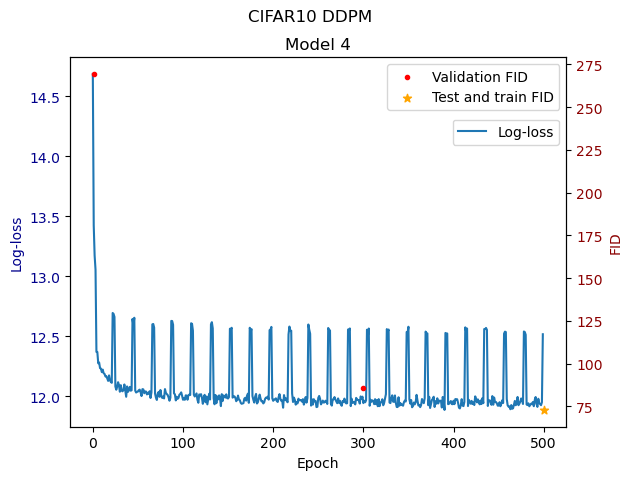

In [8]:
#valid_fid_scores = [349.9, 141.6, 150.1, 137.1, 125.4, 124.3, 121.4, 123.7, 117.3]
#test_fid_score = [107.5]
#train_fid_score = [107.8]

epochs_valid_fid = [1, 300]
epochs_loss = list(range(500))
test_fid_score = test_score
train_fid_score = train_score
fig, ax1 = plt.subplots()
plt.suptitle("CIFAR10 DDPM")
plt.title("Model 4")
ax1.plot(epochs_loss, np.log(np.array(all_epochs_loss)/64 * 16), label="Log-loss")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Log-loss', color='darkblue')
ax1.tick_params(axis='y', labelcolor='darkblue')
ax1.legend(loc="upper left", bbox_to_anchor=(0.757, 0.85))
ax2 = ax1.twinx()
ax2.scatter(epochs_valid_fid, validation_scores, color="red", marker=".", label="Validation FID")
ax2.set_ylabel('FID', color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')
ax2.scatter([500], test_fid_score, label="Test and train FID", marker="*", color="orange")
ax2.legend()
plt.savefig("model4.png")
plt.show()


In [21]:
plt.show()
plt.savefig("model4.png")

<Figure size 640x480 with 0 Axes>

# Overfit to one batch

In [7]:
batch_size = 16
model = UNET()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
single_batch, _ = next(iter(train_loader))
single_batch = single_batch[0].unsqueeze(0).to(device)
single_batchs = single_batch.repeat(batch_size, 1, 1, 1)
# Set the model to training mode
model.train()

for epoch in range(10000):
    x0 = single_batchs
    x0 = x0.to(device)
    t = torch.randint(1, T+1, (batch_size,)).to(device)
    #print(t.shape)
    eps = torch.randn(batch_size, 3, 32, 32).to(device)
    # print(eps.shape)
    # print(x0.shape)
    loss = criterion(eps, model(torch.sqrt(alpha_bar[t-1]) * x0 + 
                                torch.sqrt(1 - alpha_bar[t-1]) * eps, t.view(batch_size, 1, 1, 1).expand(batch_size, 1, 32, 32) / 1000))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(epoch)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

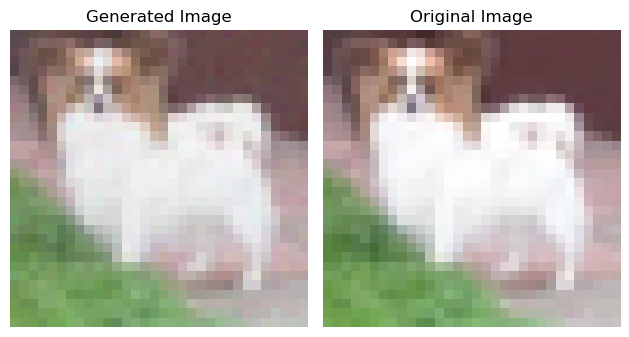

In [10]:
model.eval()
batch_size = 1
with torch.no_grad():
    xt = torch.randn(batch_size, 3, 32, 32).to(device)
    
    for t in torch.arange(T, 0, -1):
        #print(t)
        t = t.to(device)
        #print(t.view(batch_size, 1, 1, 1).expand(batch_size, 1, 32, 32))
        z = torch.randn(batch_size, 3, 32, 32).to(device) if t > 1 else torch.zeros(batch_size, 3, 32, 32).to(device)
        xt_new = 1 / torch.sqrt(alpha[t - 1]) * (xt - (1 - alpha[t - 1])/(torch.sqrt(1 - alpha_bar[t - 1])) * 
                                                       model(xt, t.view(batch_size, 1, 1, 1).expand(batch_size, 1, 32, 32)/1000)) + torch.sqrt(beta[t-1]) * z
        xt = xt_new
    
    # Plot the generated image
    fig,axs = plt.subplots(1, 2, tight_layout=True)
    im = xt[0].permute(1, 2, 0)
    im = im.cpu().detach().numpy()
    #print(im.max(), im.min())
    im = (im + 1) / 2 
    im = im.clip(0, 1)
    axs[0].imshow(im)
    axs[0].set_title("Generated Image")
    axs[0].axis("off")
    im_2 = single_batch[0].permute(1, 2, 0).cpu().detach().numpy()
    im_2 = (im_2 + 1)/2
    #im_2 = (im_2 - im_2.min()) / (im_2.max() - im_2.min()) 
    axs[1].imshow(im_2)
    axs[1].set_title("Original Image")
    axs[1].axis("off")
    plt.savefig("Model4Overfit.png")
    plt.show()